# Building version scaled to Ediacaran
##### Connor van Wieren, 2025

In [49]:
todays_date = str(datetime.now())[:16] # limit to minutes
display(Markdown(f'##### Date: {todays_date}'))
print(f'detected theme = {current_theme}')
plt.style.use(light_style) 
#plt.style.use(dark_style)

##### Date: 2025-12-17 09:50

detected theme = light


## Imports and paths

In [51]:
import pandas as pd
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection
from matplotlib.cbook import boxplot_stats
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
from cycler import cycler
import seaborn as sns
import pandas as pd 
import time
import os
from scipy import signal
from scipy.stats import norm, uniform, gaussian_kde
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import gaussian_filter
from scipy.stats import spearmanr
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import rasterio
import pickle
import dill
import sys
import string

# stuff for map
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from cartopy.io import shapereader as shpreader
from shapely.geometry import box
from rasterio.transform import rowcol

matplotlib.rcParams['pdf.fonttype'] = 42  # for acrobat? idk why i need this

# load funcs from .py files
sys.path.insert(0, '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/sed_transport/sed_transport')
from model_dev import run
from utils import *
from output import Model_output

# import facies
sys.path.insert(0, '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/shuram_TOC/code/')
from facies import facies

# interactive plots
from ipywidgets import interactive, interact
from IPython.display import clear_output, Video

sns.set_context('paper')

# data
data_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/shuram_TOC/data/'

# figures
fig_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/shuram_TOC/figures/'
tex_fig_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/Publications/PhD/Ch3_Shuram_TOC_EPSL/img/'
diss_fig_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/vanWieren_Dissertation25/img/ch3/'

# Model 1: TOC and Carbonates: 
- Aim: scale to 20Myr run time (200,000 steps of dt = 0.1, 20,000 timesteps each of 1kyr = 20,000,000 duration)

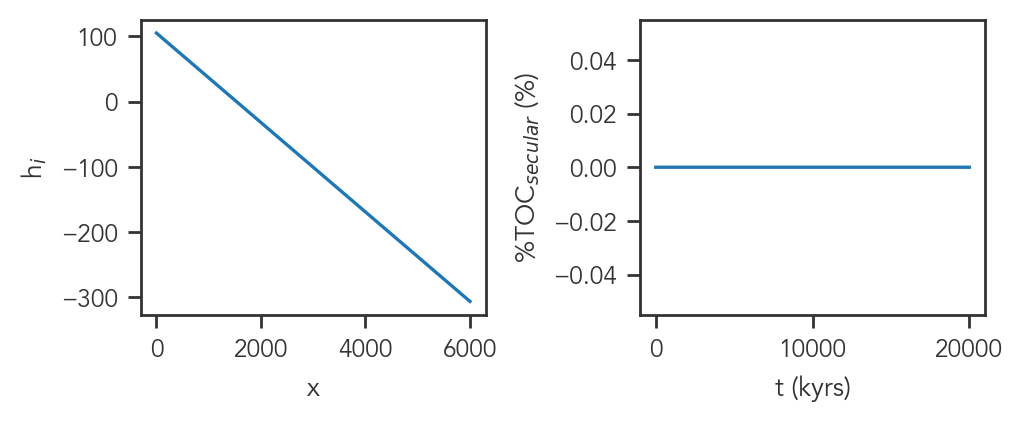

In [52]:
# from the current method
p1 = {'Nx':400,       
      'xmin':0, 
      'xmax':6000,     
      'dx':0.8,
      'start':0,
      'dt':0.1,
      'total_n':2000,
      'compiled_steps':100,
      'ep':-25,
      'org_epsilon': 0,
      'pel_epsilon':0,
      'alg_epsilon':0, 
      'coral_epsilon':0,
      'ocean_depth':0,  
      'org_coef':1,
      'alg_coef':1, 
      'marine_K':2.5e-1,
      'land_K':5e-1,  # 5e-1; 0.85e-1
      'smooth_K':6, # 6      
      'grid_ylen':1000,  # 1000
      'A':0.1,
      'f_react':0.00001,
      'tau':0.033,
      'base_depth':10,
      'toc_t_cutoff':250, # 250 # 2700; 1800; 2500 # prevent weird eroded wedge at start; no TOC accumulation for first 2500kyrs  
     }
x,t,end = init_vars(p1) # time in kyrs

# secular w array - want no change here
seawater = 0 # % TOC
sec_w_fun = lambda t: jnp.ones_like(t) * seawater

## Define h: initial topographic composition
hi = -0.0685*x+105

fig,ax = plt.subplots(1,2,figsize=(5,2),layout='constrained')

# initial proxy and topography
ax[0].plot(x,hi,label='h$_i$')
ax[0].set_xlabel('x')
ax[0].set_ylabel('h$_i$')

# proxy over time
ax[1].plot(t,sec_w_fun(t))
ax[1].set_ylabel(r'%TOC$_{secular}$ (%)')
ax[1].set_xlabel('t (kyrs)');

## RSL Curve

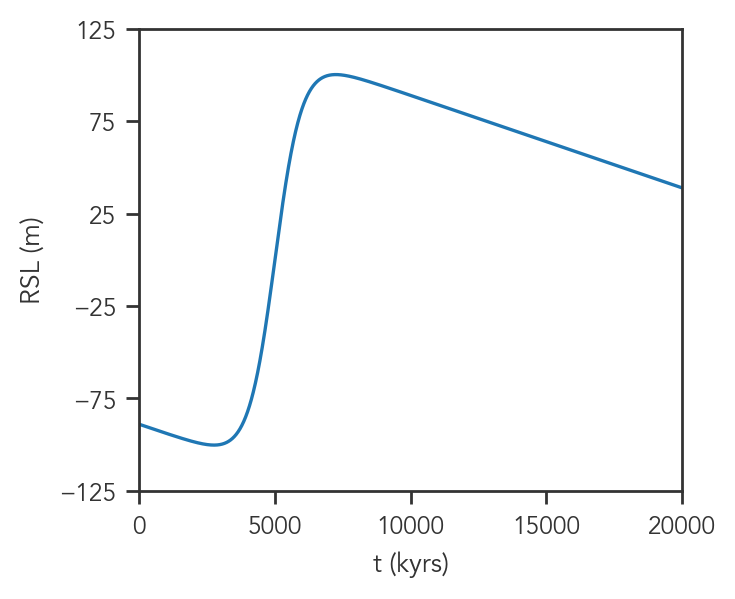

In [4]:
def sl_shuram(t, amp=250, cfall=0.01, center=5000, tau=0.002,
              flat_before_rise=False, flat_buffer=0,
              start_at_transgression=False, shift_time=None):
    """
    Sea level curve to generate Shuram excursion

    Parameters
    ----------
    t : array
        Time array (in kyr)
    amp : float
        Amplitude of the transgression
    cfall : float
        Rate of sea level fall (m/kyr)
    center : float
        Time of maximum transgression (kyr)
    tau : float
        Sigmoid steepness
    flat_before_rise : bool
        If True, flatten sea level before the rise
    flat_buffer : float
        Duration (kyr) to flatten before transgression
    start_at_transgression : bool
        If True, auto-shift so transgression rise starts at t = 0
    shift_time : float or None
        Optional manual time shift (in kyr); overrides auto-shift
    """
    if shift_time is not None:
        t_adj = t + shift_time
    elif start_at_transgression:
        t_adj = t + (0 - (center - 1 / tau))  # auto-shift to move rise to t = 0
    else:
        t_adj = t

    rise = amp / (1 + jnp.exp(-tau * (t_adj - center)))
    fall = -cfall * (t_adj - center)
    sl = rise + fall - amp / 2

    if flat_before_rise:
        t_flat = center - flat_buffer
        min_val = jnp.min(sl * (t_adj < t_flat))  # masked min
        sl = jnp.where(t_adj < t_flat, min_val, sl)

    return sl

# sea level
fig,ax = plt.subplots(figsize=(3.5,3))

ax.set_ylabel('RSL (m)')
ax.set_xlabel('t (kyrs)')
ax.set_xlim(0,20000)
ax.set_ylim(-125,125)
ax.set_yticks(np.linspace(-125,125,6));

# shuram-style sea level curve (50 m rise)
sl_fun = lambda t: sl_shuram(t,amp=228,cfall=0.005) 

ax.plot(t, sl_fun(t), label='current',color='tab:blue')

Model time unit:              1 kyr
Max TOC target:               2.00%
Final org/carb max ratio:     0.020408


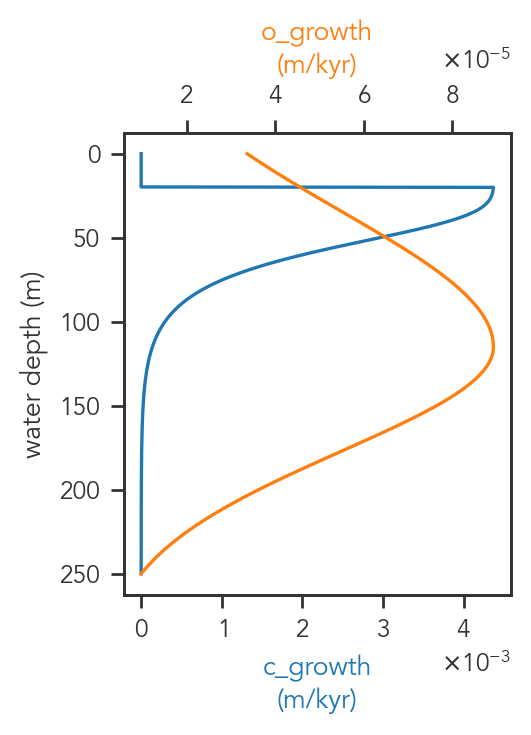

In [5]:
# setup
z = np.linspace(1e-5, 250, 1000)        # depth (m), positive down
Dt = 20                                 # tidal depth cutoff
max_TOC_percent = 2.0                   # max allowed TOC
alg_coef = 3.5                          # carbonate growth multiplier

# growth rates converted from m/yr to m/kyr (because model dt is in kyr)
Gm = Gmax = 0.00125 * alg_coef          # m/kyr, no division by 1000

# raw growth functions (unscaled)
carb_raw = lambda d: bosscher_G(d, Gm=Gm, Dt=Dt, k=0.05, Ik=200, out='growth')
org_raw = lambda d: erf_G_asym(d, Gmax=Gmax, G_depth=115, width_shallow=130, width_deep=100) # latest

# compute scaling for TOC ~2%
toc_target_frac = max_TOC_percent / 100
max_ratio = toc_target_frac / (1 - toc_target_frac)
org_scale = max_ratio * Gm / Gmax

# final scaled functions (m/kyr)
carb_growth = lambda d: carb_raw(d)
org_growth_base  = lambda d: org_raw_z(d) * org_scale
org_growth  = lambda d: org_raw(d) * org_scale

# plot 
fig, ax = plt.subplots(figsize=(2.5, 3))
ax.plot(carb_growth(z), z, label='carb', color='tab:blue')
axi = ax.twiny()
axi.plot(org_growth(z), z, label='org (asym)', color='tab:orange')
ax.set_ylabel('water depth (m)')
ax.set_xlabel('c_growth\n(m/kyr)', color='tab:blue')
axi.set_xlabel('o_growth\n(m/kyr)', color='tab:orange')
ax.invert_yaxis()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axi.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
axi.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

print(f'Model time unit:              1 kyr')
print(f'Max TOC target:               {max_TOC_percent:.2f}%')
print(f'Final org/carb max ratio:     {max_ratio:.6f}')

In [6]:
# initial sediment proxy
wi1 = jnp.ones_like(hi) * 0.0
scale_organics = True

calculated ymin,ymax = -406.25, 205.25
mean grid dy = 6.121e-01


running model: TOC total_A0.1_ylen1000_2025-12-16 09:52:   0%|          | 0/2000 [00:00<?, ? compiled steps/s]

plotting results:   0%|          | 0/2000 [00:00<?, ? beds/s]

actual ymin,ymax = -306.00, 105.00
mean eroded distance = 1.21e-01; mean deposited distance = 5.41e-02


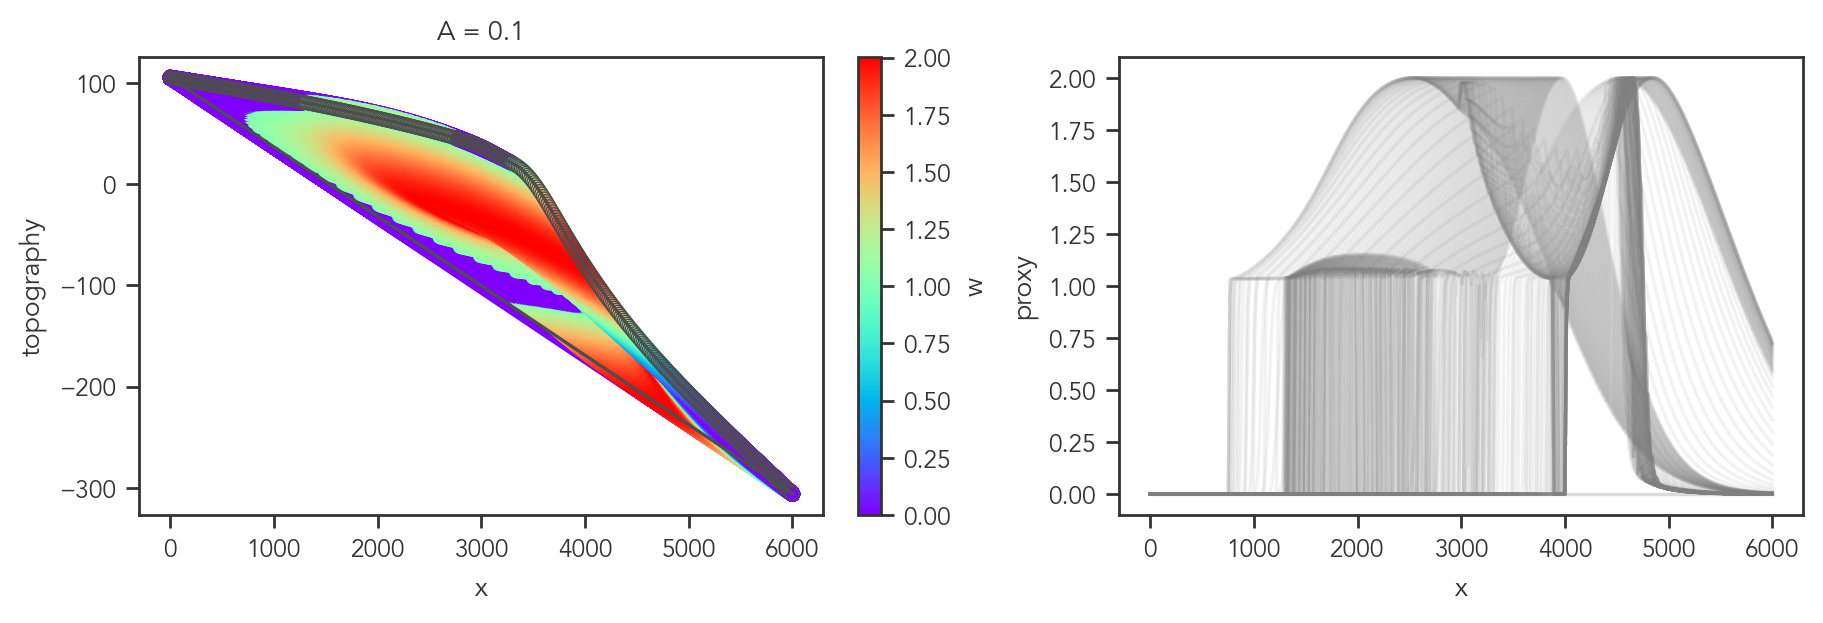

In [7]:
# run model
m1a = run(p1,                            
          model_desc = 'TOC total',                
          hi = hi,                            
          wi = wi1,                            
          sl_fun = sl_fun,                   
          sec_w_fun = sec_w_fun,           
          wi_sec = False,
          depth_w_fun = None,  
          carb_growth=True,
          org_growth=True,
          growth_fun_alg = carb_growth,     
          growth_fun_org = org_growth,                
          track_toc = True,
          scale_organics=scale_organics,
          w_set_erode = True,              
          full_storage = True,  
          storage_level = 'compiled',
          swi_dist_calc = False,
          track_react = 'respiration',
          swi_fun = None,
          w_transport=True)

im_ylen = 1000 matching grid_ylen


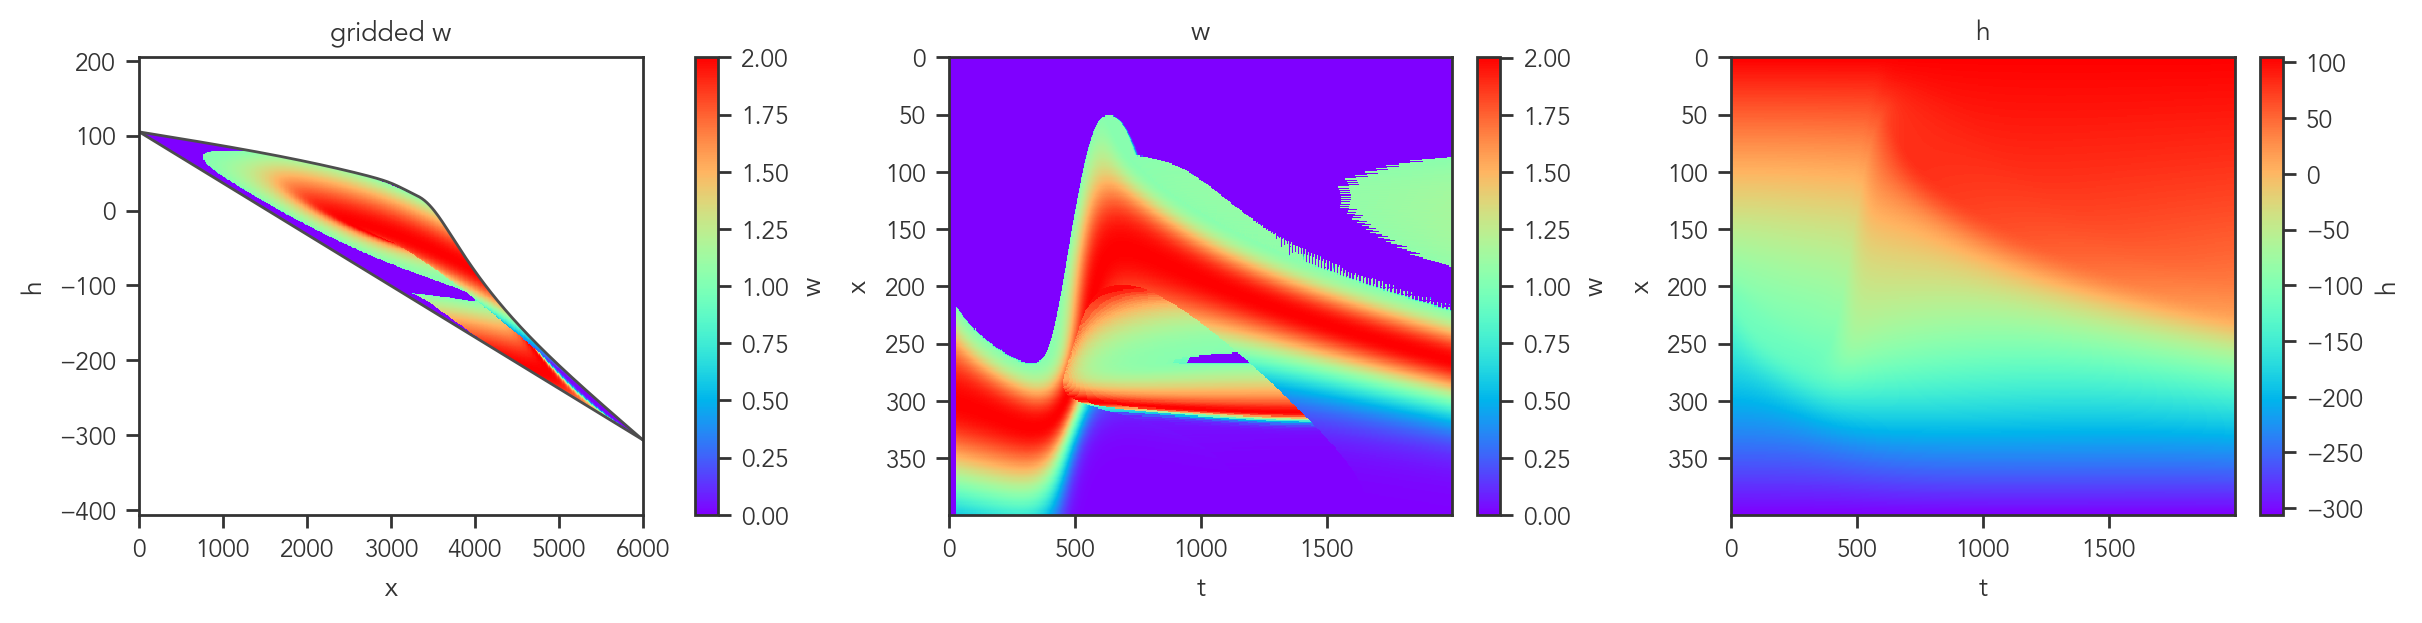

In [8]:
# reformulating for better boxplots and facies maps
facies_data = [{'name': 'Inner Shelf', 'type': 'uniform', 'max': 21.5, 'width': 0.8},
               {'name': 'Outer Shelf', 'type': 'uniform', 'min': 21.5, 'max': 35, 'width': 0.8},
               {'name': 'Upper Slope', 'type': 'uniform', 'min': 35, 'max': 75, 'width': 0.6},
               {'name': 'Middle Slope', 'type': 'uniform', 'min': 75, 'max': 110, 'width': 0.4},
               {'name': 'Lower Slope', 'type': 'uniform', 'min': 110, 'max': 145, 'width': 0.3},
               {'name': 'Deep Basin', 'type': 'uniform', 'min': 145, 'width': 0.2}]

# facies colours
facies_colours = list(sns.color_palette('coolwarm_r',n_colors=len(facies_data)-1).as_hex()) # add one as going to drop the white one; -1 as terrestrial is not here anymore
facies_colours = ['tab:red'] + facies_colours + ['tab:blue']

# model outputs
o1a = Model_output(**m1a,facies_data=facies_data,facies_colours=facies_colours,bc_filter=False,set_under_c='.3',im_ylen=None,images=True,swi_dist_calc=False)
o1a.plot_grids(cmap='rainbow')

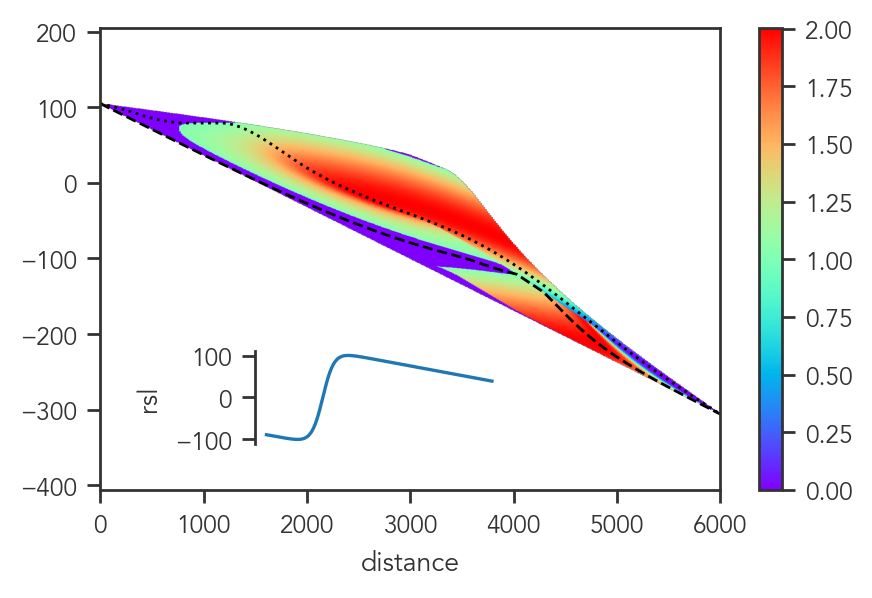

In [9]:
fig,ax = plt.subplots(figsize=(5,3))
im = ax.imshow(o1a.gridw,aspect='auto',origin='upper',cmap='rainbow',extent=o1a.extent)
plt.colorbar(im)
ax.set_xlabel('distance')
ax.plot(o1a.x,o1a.beds[o1a.reg_idx,:].T,alpha=1,ls=':',label='regressive surface',color='k',lw=1);
ax.plot(o1a.x,o1a.beds_eroded[o1a.tran_idx,:].T,alpha=1,ls='--',label='transgressive surface',color='k',lw=1);

axi = ax.inset_axes([0.25,0.1,0.4,0.2])
axi.set_xticks([]);
axi.plot(t,sl_fun(t))
axi.set_ylabel('rsl')
axi.spines[['right','top','bottom']].set_visible(False)

## Organic Respiration (Reaction Curve)

### Run (1b): Grow TOC *with* loss to respiration (see porosity profile in Berner)

R0 = 0.000008


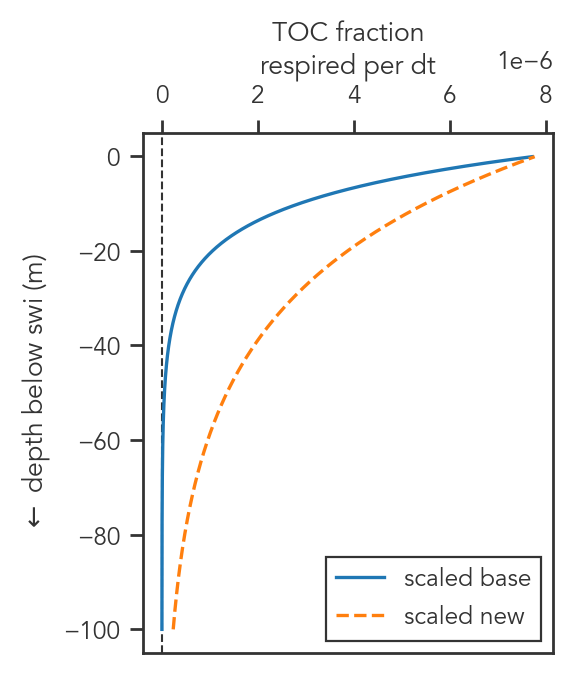

In [10]:
# compute reaction rate for respiration
trg1 = 7.5 #10 # % / Myr
R0 = compute_f_react(trg1, p1['dt']) # 10% / Myr
p1['f_react'] = R0 #0.00005   
print(f'R0 = {R0:8f}')

# how steep is curve for reaction; matches Fig 3.2 Berner porosity profile; more respiration in areas with more porespace
tau1 = 0.1 
tau2 = 0.035 # 0.035
p1['tau'] = tau2 # 0.1 #0.025 #0.1 #0.1 ; 0.4

zs = np.arange(-100, 0, 0.1)

def resp_fun(vertical_distance, d13c_seawater=1.0, base_value=0.0, tau=0.1, f_react=0.1):
    curve = (d13c_seawater * jnp.exp(tau * vertical_distance) +
             base_value * (1.0 - jnp.exp(tau * vertical_distance))) #+ 0.3 # can add this to match berner exactly
    return curve #* f_react  # scale the decay so SWI = f_react

resp_curve = resp_fun(zs, tau=tau1, f_react=p1['f_react'])
resp_curve_new = resp_fun(zs, tau=p1['tau'], f_react=p1['f_react'])

fig, ax = plt.subplots(figsize=(2.75, 3.25),layout='constrained')
ax.plot(resp_curve*p1['f_react'],zs,label='scaled base')
ax.plot(resp_curve_new*p1['f_react'],zs,ls='--',label='scaled new')

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel('TOC fraction\nrespired per dt')
ax.set_ylabel(r'$\leftarrow$ depth below swi (m)');
#ax.set_ylim(-50,0) # match berner figure
ax.axvline(0,color='.2',ls='--',zorder=0,lw=0.75)
ax.legend()

calculated ymin,ymax = -406.25, 205.25
mean grid dy = 6.121e-01


running model: TOC remaining_A0.1_ylen1000_2025-12-16 09:59:   0%|          | 0/2000 [00:00<?, ? compiled step…

plotting results:   0%|          | 0/2000 [00:00<?, ? beds/s]

actual ymin,ymax = -306.00, 105.00
mean eroded distance = 1.21e-01; mean deposited distance = 5.41e-02


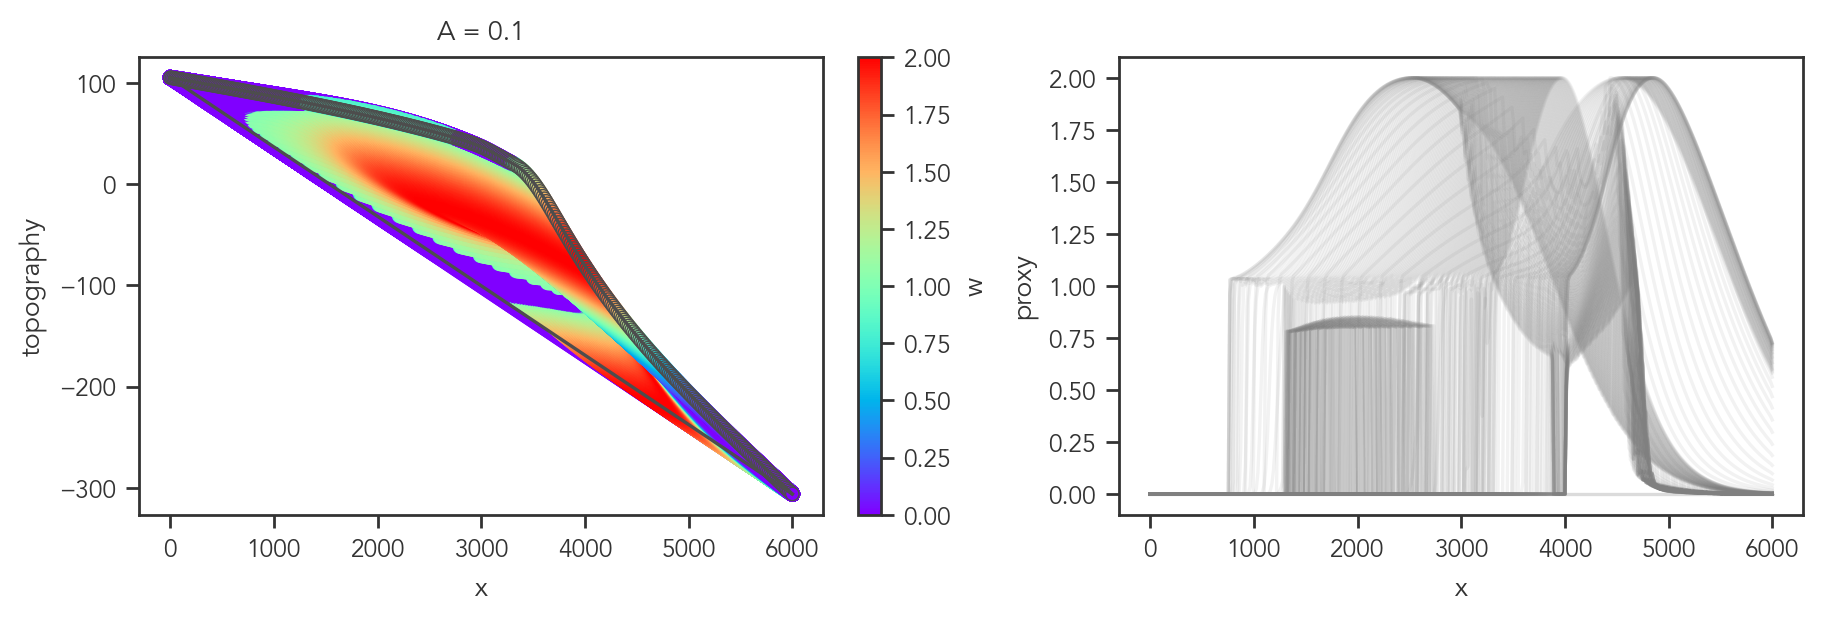

In [11]:
# run model
m1b = run(p1,                            
          model_desc = 'TOC remaining',                
          hi = hi,                            
          wi = wi1,                            
          sl_fun = sl_fun,                   
          sec_w_fun = sec_w_fun,
          wi_sec = False,
          depth_w_fun = None,  
          carb_growth=True,
          org_growth=True,
          growth_fun_alg = carb_growth,     
          growth_fun_org = org_growth,             
          track_toc = True,
          scale_organics=scale_organics,
          w_set_erode = True,              
          full_storage = True,  
          storage_level = 'compiled',
          grid_level='compiled',
          swi_dist_calc = True,
          track_react = 'respiration',
          swi_fun = resp_fun,
          porosity_fun = None,
          w_transport = True)     

im_ylen = 1000 matching grid_ylen


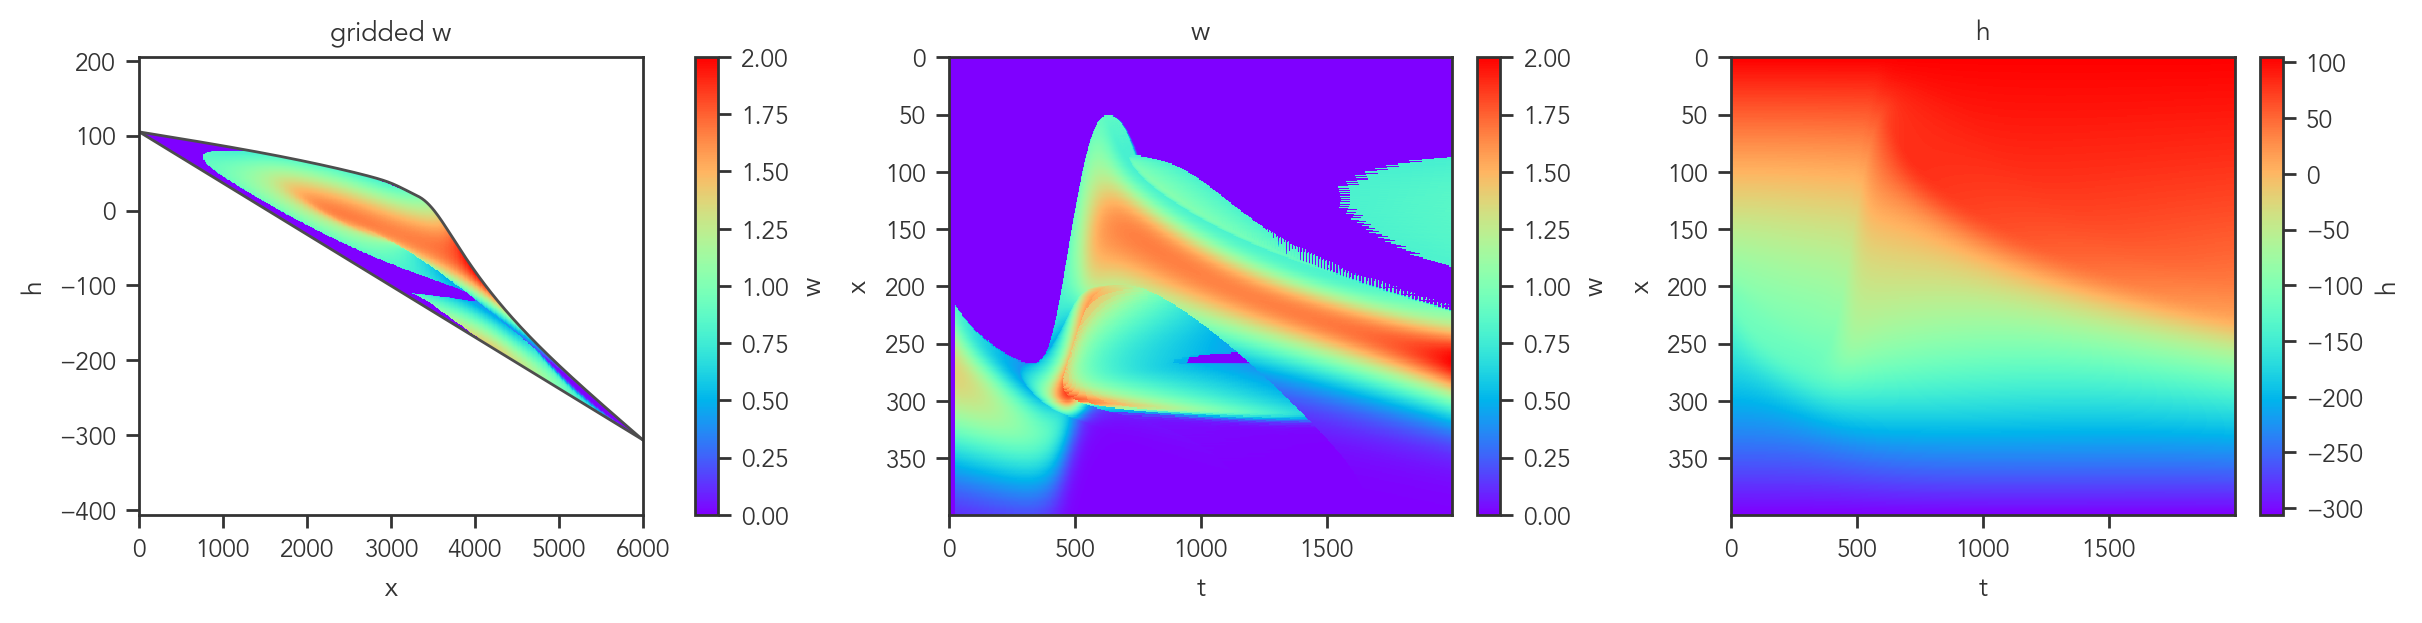

In [12]:
# model outputs
o1b = Model_output(**m1b,facies_data=facies_data,facies_colours=facies_colours,bc_filter=False,set_under_c='.3',im_ylen=None,images=True,swi_dist_calc=True)
o1b.plot_grids(cmap='rainbow')

## Determine difference between run 1a and 1b: Converting amount TOC remaining to amount TOC lost

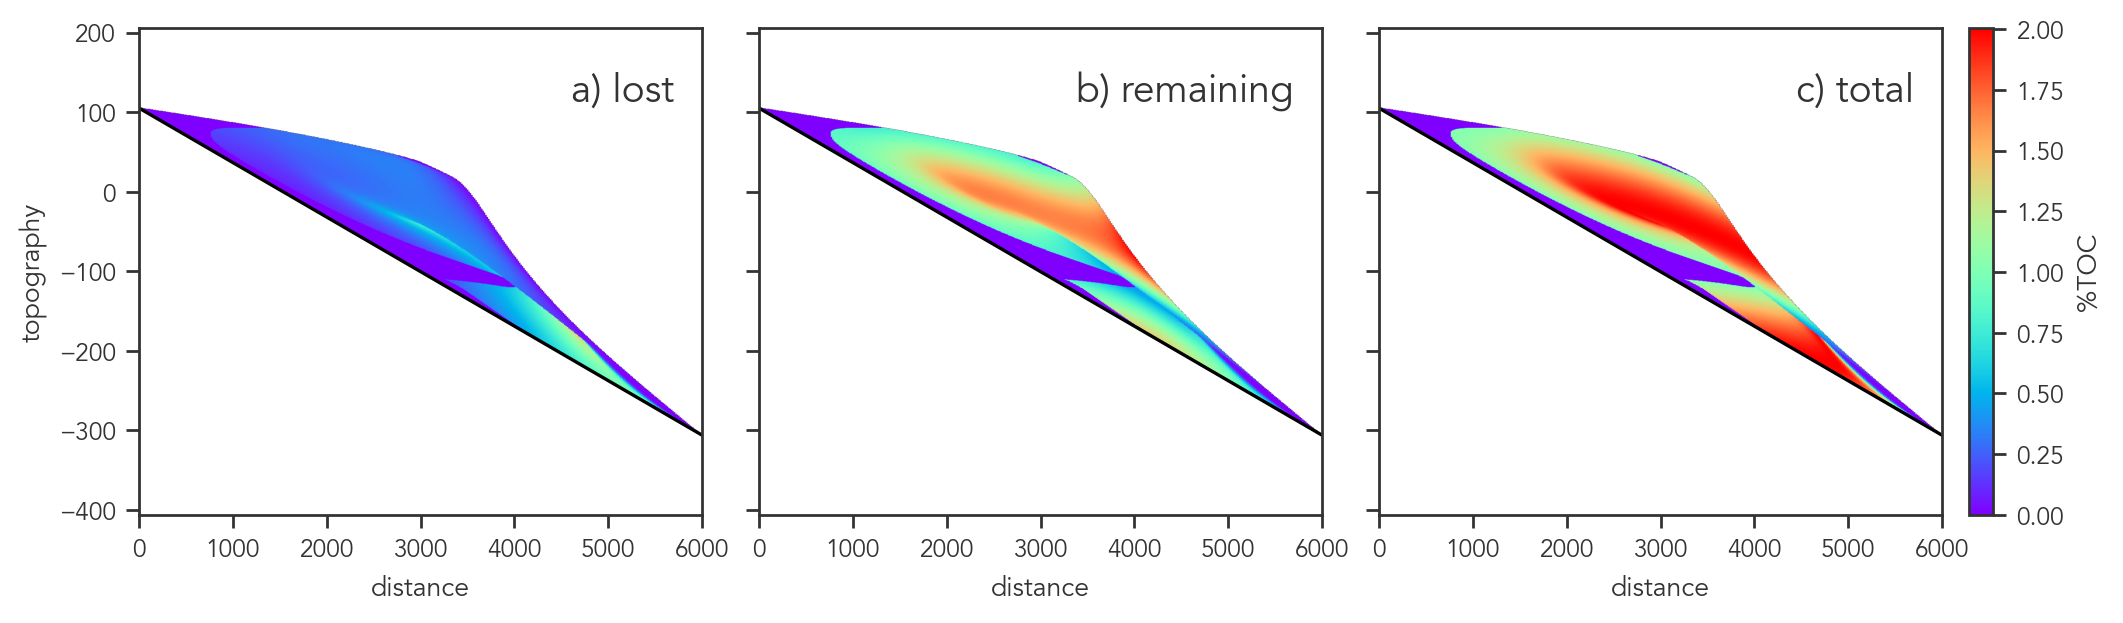

In [13]:
# TOC_loss = no_respiration - with_respiration = a - b
grid_d = o1a.gridw - o1b.gridw
grid_d = np.clip(grid_d, 0, None)            # remove erosion (negative loss)

# stack all three arrays to get global min/max
all_data = np.stack([grid_d, o1b.gridw, o1a.gridw])
vmin = np.nanmin(all_data)
vmax = np.nanmax(all_data)

# plot
fig,ax = plt.subplots(1,3,figsize=(10.5,3),sharey=True,layout='constrained')

# lost
im = ax[0].imshow(grid_d,aspect='auto',origin='upper',cmap='rainbow',extent=o1a.extent,vmin=vmin,vmax=vmax)
#plt.colorbar(im,label='%TOC loss to respiration',location='top')
ax[0].plot(x,o1a.beds[0],c='k')
#ax[0].plot(x,o1a.beds_eroded[-1],c='k')
ax[0].set_xlabel('distance')
ax[0].set_ylabel('topography')

# remain
im = ax[1].imshow(o1b.gridw,aspect='auto',origin='upper',cmap='rainbow',extent=o1a.extent,vmin=vmin,vmax=vmax)
#plt.colorbar(im,label='%TOC remaining after respiration',location='top')
ax[1].plot(x,o1a.beds[0],c='k')
#ax[1].plot(x,o1a.beds_eroded[-1],c='k')
ax[1].set_xlabel('distance')

# total
im = ax[2].imshow(o1a.gridw,aspect='auto',origin='upper',cmap='rainbow',extent=o1a.extent,vmin=vmin,vmax=vmax)
#plt.colorbar(im,label='total %TOC without respiration',location='top')
ax[2].plot(x,o1a.beds[0],c='k')
#ax[2].plot(x,o1a.beds_eroded[-1],c='k')
ax[2].set_xlabel('distance')

labs = ['a) lost','b) remaining','c) total']
for i,l in enumerate(labs):
    ax[i].text(0.95,0.85,l,transform=ax[i].transAxes,size=14,ha='right')

# shared colorbar on top
cbar = fig.colorbar(im, ax=ax[2], location='right', shrink=1, pad=0, aspect=20)
cbar.set_label('%TOC')

 # plot T-R surfaces
# for i in range(3):
#     ax[i].plot(o1b.x,o1b.beds_eroded[o1b.reg_idx,:].T,alpha=1,ls=':',label='regressive surface',color='w',lw=1);
#     ax[i].plot(o1b.x,o1b.beds_eroded[o1b.tran_idx,:].T,alpha=1,ls='--',label='transgressive surface',color='w',lw=1);

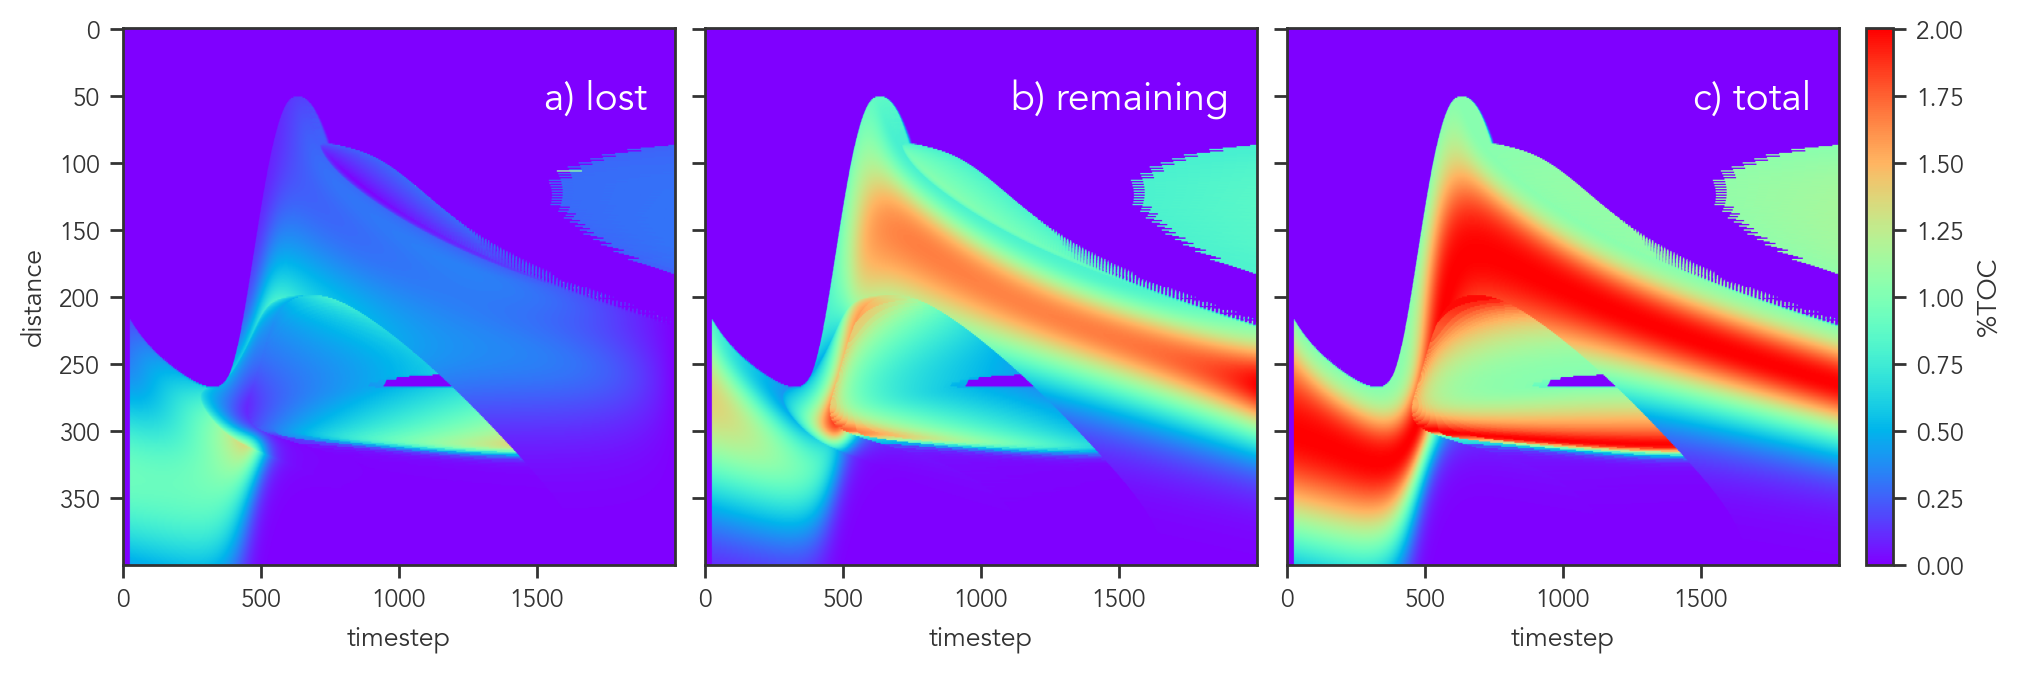

In [14]:
sto_d = o1a.sto[1::2] - o1b.sto[1::2]
sto_d = np.clip(sto_d, 0, None)            # remove erosion (negative loss)

# stack all three arrays to get global min/max
all_data = np.stack([sto_d, o1b.sto[1::2], o1a.sto[1::2]])
vmin = np.nanmin(all_data)
vmax = np.nanmax(all_data)

fig,ax = plt.subplots(1,3,figsize=(10,3.25),sharey=True,layout='constrained')

im = ax[0].imshow(sto_d,aspect='auto',cmap='rainbow',vmin=vmin,vmax=vmax)
im = ax[1].imshow(o1b.sto[1::2],aspect='auto',cmap='rainbow',vmin=vmin,vmax=vmax)
im = ax[2].imshow(o1a.sto[1::2],aspect='auto',cmap='rainbow',vmin=vmin,vmax=vmax)

labs = ['a) lost','b) remaining','c) total']
for i,l in enumerate(labs):
    ax[i].text(0.95,0.85,l,transform=ax[i].transAxes,size=14,ha='right',color='w')
    ax[i].set_xlabel('timestep')
ax[0].set_ylabel('distance')

# shared colorbar on top
cbar = fig.colorbar(im, ax=ax[2], location='right', shrink=1, pad=0.05, aspect=20)
cbar.set_label('%TOC')

### Convert TOC to mol C

Text(0, 0.5, 'x gridpoint')

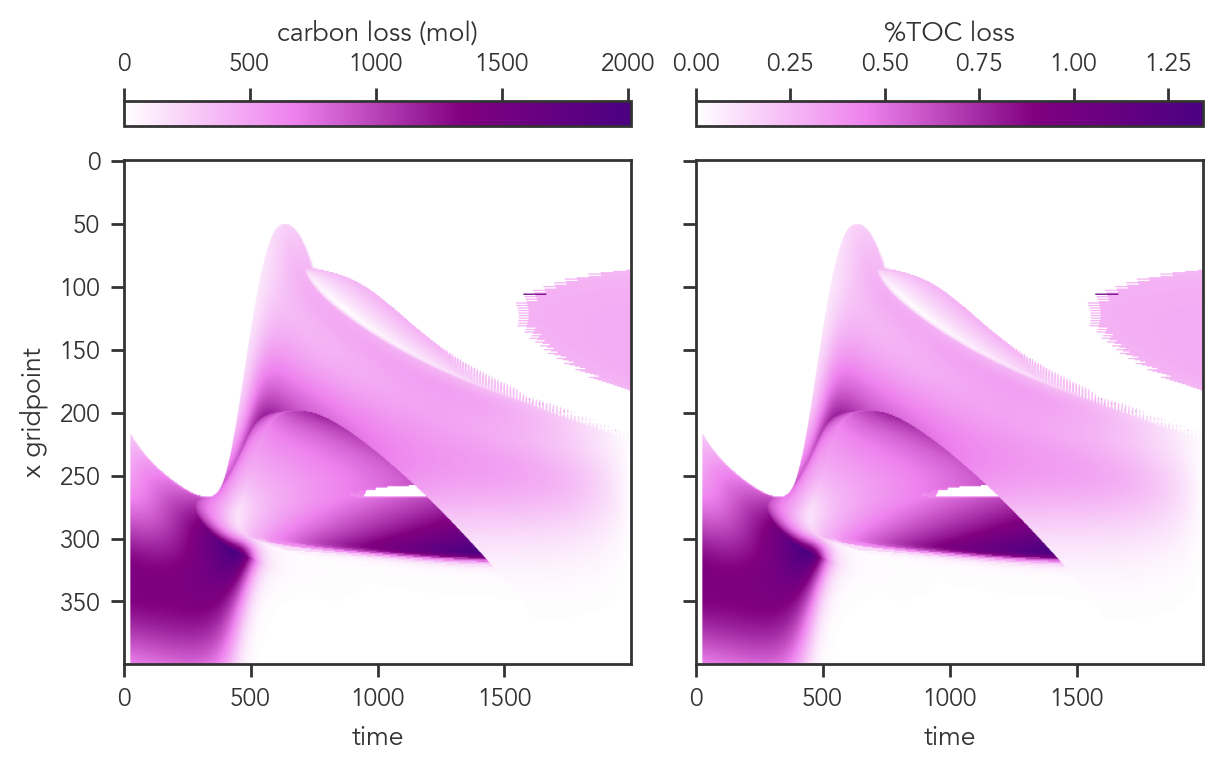

In [15]:
sed_scale = False

# extract topography and TOC data
beds_sto = o1b.sto[::2].T          # shape (Nt, Nx)
proxy_sto = sto_d                  # TOC% loss, shape (Nt, Nx)

# mask out eroded beds
beds_sto_eroded = np.minimum.accumulate(beds_sto[::-1, :], axis=0)[::-1, :]
mask_sto = (beds_sto > beds_sto_eroded)
beds_sto_eroded = np.where(mask_sto, np.nan, beds_sto)

# convert TOC% loss to mol C using new generalized function
mol_C_org, v_cm3 = calc_mol(toc_percent=proxy_sto, topo=beds_sto.T, mode='organic sediment', params=p1,frac_reactive=1,sed_scale=sed_scale) # 0.5; 0.8, 1.0

# remove eroded beds from mol_C_org using erosion mask
var = o1b.proxy_sto_eroded.T
# mol_C_org = jnp.where(jnp.isnan(var), jnp.nan, mol_C_org)
# proxy_sto = jnp.where(jnp.isnan(var), jnp.nan, proxy_sto)

#colors = ['white', 'violet', 'purple', 'black']
colors = ['white', 'violet', 'purple', 'indigo']
purps = sns.blend_palette(colors, as_cmap=True)
purps_r = sns.blend_palette(colors[::-1], as_cmap=True)

fig, ax = plt.subplots(1, 2, figsize=(6, 3.75), sharey=True, sharex=True, layout='constrained')

# mol C loss plot
im1 = ax[0].imshow(mol_C_org, aspect='auto', cmap=purps)
cb1 = plt.colorbar(im1, ax=ax[0], location='top', label='carbon loss (mol)')

# TOC % loss plot
im2 = ax[1].imshow(proxy_sto, aspect='auto', cmap=purps)
cb2 = plt.colorbar(im2, ax=ax[1], location='top', label='%TOC loss')

[ax[i].set_xlabel('time') for i in range(2)]
ax[0].set_ylabel('x gridpoint')

### Convert TOC Remaining to mol carbonate existing

molar mass of carbonate = 100.09, fraction carbon in carbonate = 0.12


Text(0.5, 1.0, 'moles C in remaining carb')

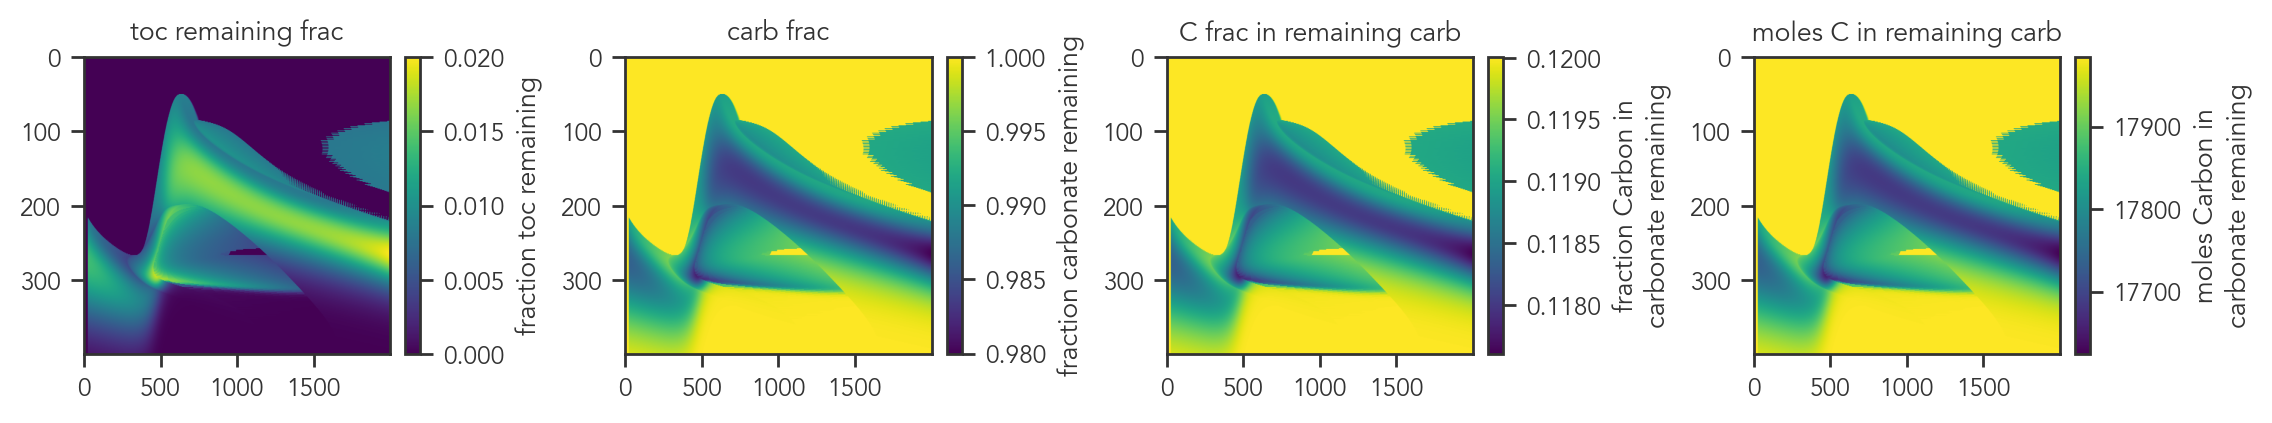

In [16]:
# extract topography and TOC data
beds_sto = o1b.sto[::2].T          # shape (Nt, Nx)
toc_rem = o1b.sto[1::2]/100         # TOC% remaining, shape (Nt, Nx) converted to fraction (0 to 1)
frac_carb = 1 - toc_rem

# molar masses
mm_Ca = 40.078 # g/mol
mm_C = 12.011 # g/mol
mm_O = 15.999 # g/mol
mm_carb = mm_Ca + mm_C + (3 * mm_O)
frac_C = mm_C / mm_carb # ~12% C in CaCO3
print(f'molar mass of carbonate = {mm_carb:.2f}, fraction carbon in carbonate = {frac_C:.2f}')

# convert remaining TOC to fraction carbon in existing carbonate sediments
frac_C = frac_carb * frac_C 

# convert to moles
mol_C_carb, _ = calc_mol(carb_frac=frac_C, topo=beds_sto.T, mode='carbonate sediment', params=p1,sed_scale=sed_scale) # 0.5; 0.8, 1.0

# visualize remaining toc
fig,ax = plt.subplots(1,4,figsize=(11.25,2),layout='constrained')

im = ax[0].imshow(toc_rem,aspect='auto',cmap='viridis')
plt.colorbar(im,label='fraction toc remaining')
ax[0].set_title('toc remaining frac')

im2 = ax[1].imshow(frac_carb,aspect='auto',cmap='viridis')
plt.colorbar(im2,label='fraction carbonate remaining')
ax[1].set_title('carb frac')

im3 = ax[2].imshow(frac_C,aspect='auto',cmap='viridis')
plt.colorbar(im3,label='fraction Carbon in\ncarbonate remaining')
ax[2].set_title('C frac in remaining carb')

im4 = ax[3].imshow(mol_C_carb,aspect='auto',cmap='viridis')
plt.colorbar(im4,label='moles Carbon in\ncarbonate remaining')
ax[3].set_title('moles C in remaining carb')

## Test: manual check for maximum excursion end-member mass balance with just carbonate and organics

- As the most negative part of the basin is deeper down slope and we want -12 at upper bit, I can show what TOC% is required for -12, but makee it a bit more negative to -15 so that I can get -12 where i want but all I need to report is for -12

In [419]:
def toc_delta(d_targ, d_sw, ep=p1['ep'], ec=0, f_carb=1.0):
    """
    solve for molar balance coefficients
    """
    d_org = d_sw + ep
    d_carb = d_sw + ec
    A = mol_C_carb * f_carb
    B = mol_C_org
    T = d_targ

    with np.errstate(divide='ignore', invalid='ignore'):
        denom = B * (T - d_org)
        numer = A * (d_carb - T)
        m_needed = numer / denom

    valid = (B > 0) & np.isfinite(m_needed) & (denom != 0) & (m_needed >= 0)
    org_mult = np.nanmin(m_needed[valid])
    return org_mult


Text(0.5, 1.0, 'multiple = 13.31$\\times$ (original = 2.0% TOC)\nrequires initial TOC = 26.6%')

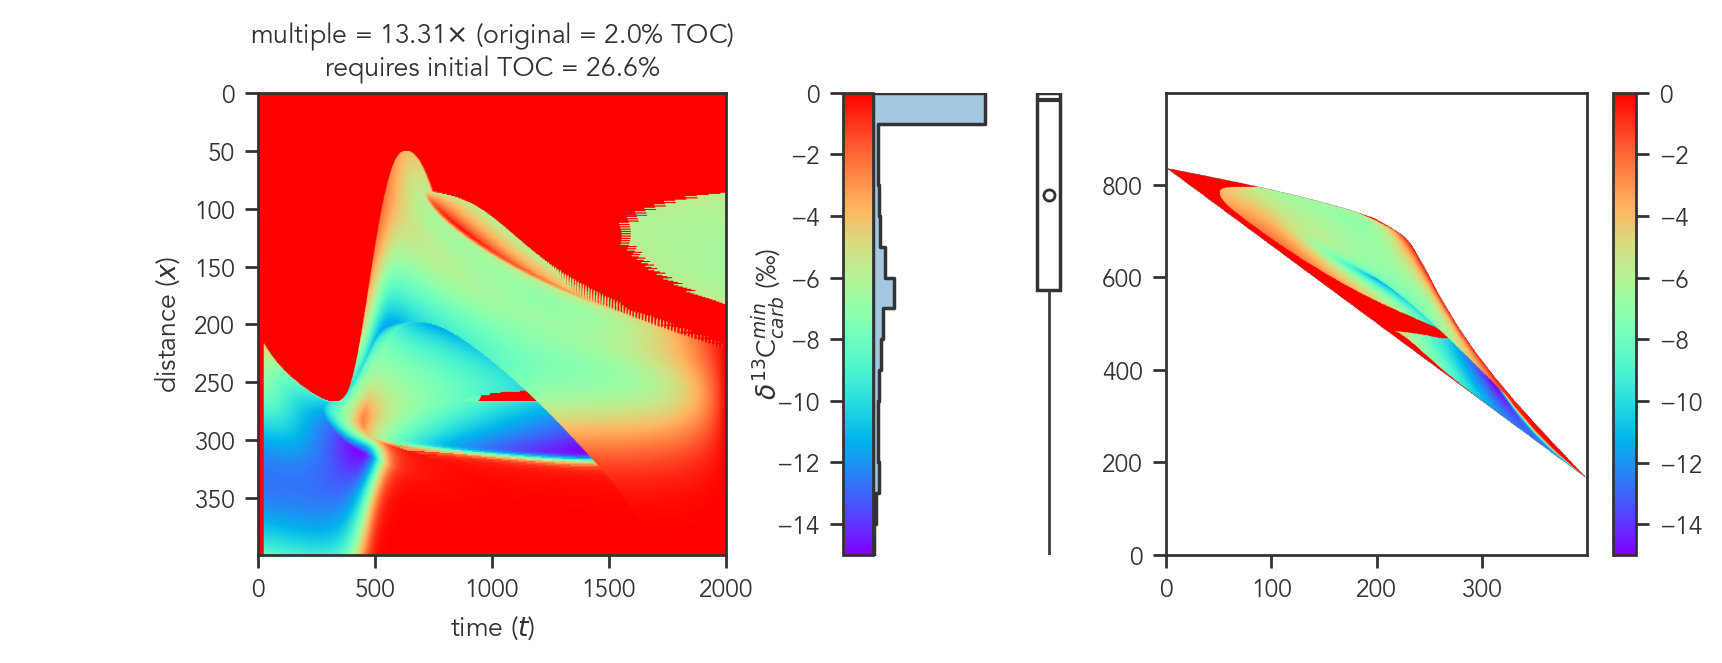

In [439]:
org_mult = toc_delta(d_targ=-15,d_sw=0)

# recompute fields using this org_mult
d_sw = 0.0 # ‰
#d_sw = 5.0 # ‰ 
ep = p1['ep']
ec = 0.0
d_org = d_sw + ep
d_carb = d_sw + ec
n_org = mol_C_org * org_mult
n_carb = mol_C_carb  # unchanged

d13c_max = (n_carb * d_carb + n_org * d_org) / (n_carb + n_org)
d13c_diff_max = d_carb - d13c_max

# pick what to visualize
var = d13c_max  # or d13c_diff_max
# make one cleaned 1d vector and its common limits
flat = np.asarray(var).ravel()
flat = flat[np.isfinite(flat)]
ymin, ymax = np.min(flat), np.max(flat)
# plot
fig, ax = plt.subplots(1,7,figsize=(9.25,3),width_ratios=[1,0.25,.065,.25,.25,0.125,1.125])
plt.subplots_adjust(wspace=0)
im = ax[0].imshow(var, aspect='auto', cmap='rainbow')
cbar = plt.colorbar(im, cax=ax[2])
cbar.set_label('$\\delta^{13}$C$^{min}_{carb}$ (‰)', labelpad=-4)
cbar.ax.yaxis.tick_left()
cbar.ax.yaxis.set_label_position('left')
ax[0].set_xlabel('time ($t$)')
ax[0].set_ylabel('distance ($x$)')
ax[0].set_xlim(0,p1['total_n'])

# spacer
ax[1].axis('off')

# histogram
ax[3].sharey(ax[2])
ax[3].tick_params(axis='y',length=0,labelleft=False)
sns.histplot(y=flat,ax=ax[3],bins=15,stat='density',element='step',edgecolor='.2',lw=1.25,fill=True,alpha=0.4)
ax[3].axis('off')

# boxplot
flier_props = dict(marker='o', markerfacecolor='w', markeredgecolor='.2',
                   markersize=5, linestyle='none', clip_on=False,alpha=0.125)
median_props = dict(color='.2', linewidth=1.5)
mean_props = dict(marker='o', markerfacecolor='w', markeredgecolor='.2',
                  markersize=4, clip_on=False)
cap_props=dict(linewidth=0, alpha=0)
box_props=dict(alpha=1, linewidth=1.25, facecolor='w', edgecolor='.2')

ax[4].sharey(ax[2])
sns.boxplot(
    y=flat,
    ax=ax[4],
    orient='v',
    width=0.2,
    showfliers=True,
    showmeans=True,
    flierprops=flier_props,
    medianprops=median_props,
    meanprops=mean_props,
    capprops=cap_props,
    boxprops=box_props
)

ax[4].axis('off');

# spacer
ax[5].axis('off')

# basin
bs = img(var.T,o1b)
im = ax[6].imshow(bs,aspect='auto',origin='lower',cmap='rainbow')
plt.colorbar(im)
ax[0].set_title(f'multiple = {org_mult:.2f}$\\times$ (original = {max_TOC_percent}% TOC)\nrequires initial TOC = {max_TOC_percent*org_mult:.1f}%')

Text(0, 0.5, '$x$')

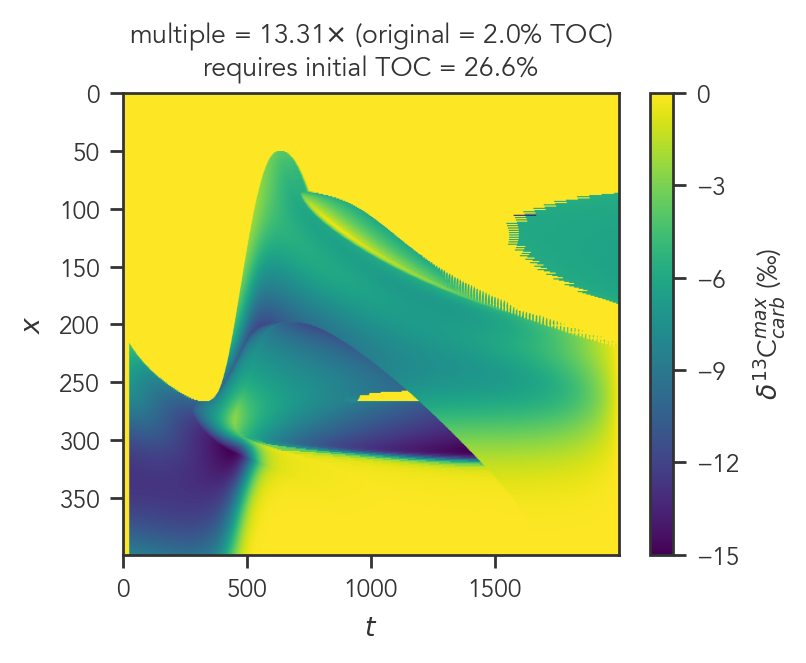

In [423]:
# balance
d13c_max = (n_carb * d_carb + n_org * d_org) / (n_carb + n_org)
d13c_diff_max = d_carb - d13c_max

r = n_org / (n_org + n_carb) # ratio of organics to total moles

d13c_solve = d13c_max
#var = d13c_diff_max
#var = r

fig,ax = plt.subplots(figsize=(4,3))
im = ax.imshow(d13c_solve,aspect='auto',cmap='viridis')
cbar = plt.colorbar(im,label='$\\delta^{13}$C$^{max}_{carb}$ (‰)')
cbar.ax.set_yticks(np.linspace(np.nanmin(d13c_solve),np.nanmax(d13c_solve),6))
ax.set_title(f'multiple = {org_mult:.2f}$\\times$ (original = {max_TOC_percent}% TOC)\nrequires initial TOC = {max_TOC_percent*org_mult:.1f}%')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')

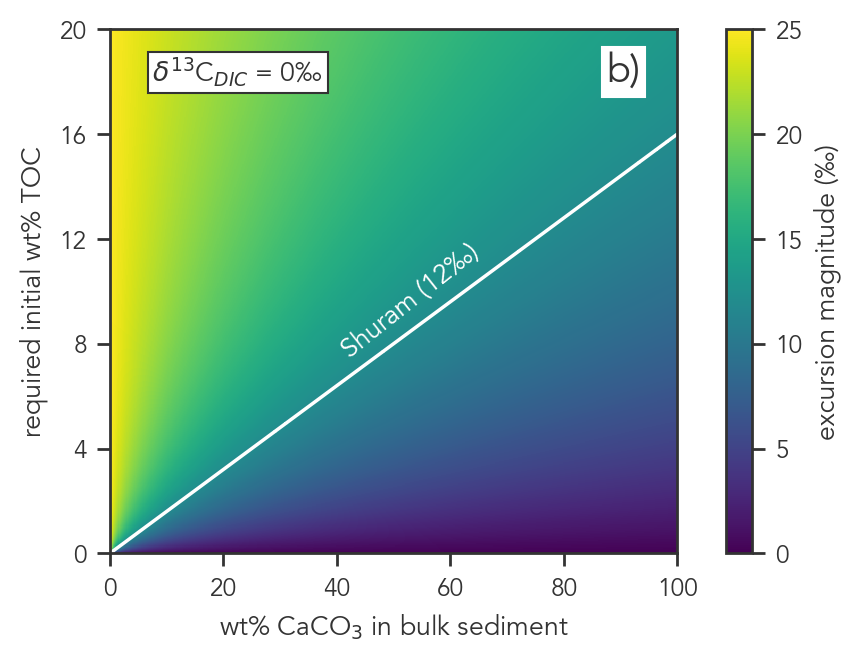

In [564]:
def plotmap_anchored(ax, tocmax=40, label=True,cmap='viridis',lcol='w'):
    # assumptions
    d_sw = 0.0
    ec = 0.0
    ep = -25.0

    d_carb = d_sw + ec
    d_org = d_sw + ep

    # anchor condition (this encodes your left-panel result)
    anchor_toc = 16.0     # %
    anchor_caco3 = 100.0  # %

    # grid
    caco3 = np.linspace(0, 100, 500)   # wt% CaCO3 (x)
    toc = np.linspace(0, tocmax, 500)  # required initial TOC (y)
    C, T = np.meshgrid(caco3, toc)

    # constants
    host_mass = 1.0
    mw_caco3 = 100.0869
    mw_c = 12.0107

    # --- anchor calibration ---
    m_carb_anchor = (anchor_caco3 / 100) * host_mass
    n_carb_anchor = m_carb_anchor / mw_caco3

    n_org_anchor = n_carb_anchor * (d_carb + 12.0) / (-12.0 - d_org)
    m_org_anchor = n_org_anchor * mw_c

    k_react = m_org_anchor / ((anchor_toc / 100) * host_mass)

    # --- compute reservoirs ---
    m_carb = (C / 100) * host_mass
    n_carb = m_carb / mw_caco3

    m_org_reacted = k_react * (T / 100) * host_mass
    n_org = m_org_reacted / mw_c

    # isotope mixing
    with np.errstate(divide='ignore', invalid='ignore'):
        d_mix = (n_carb * d_carb + n_org * d_org) / (n_carb + n_org)

    exc = d_carb - d_mix
    exc = np.where(np.isfinite(exc), exc, np.nan)

    # corner fix
    exc = np.where((C == 0) & (T == 0), 0.0, exc)

    # --- plot ---
    im = ax.pcolormesh(
        C, T, exc,
        shading='auto',
        cmap=cmap,
        rasterized=True
    )

    # if label:
    #     cbar = ax.figure.colorbar(im, ax=ax)
    #     cbar.set_label('excursion magnitude (‰)')

    #     cs = ax.contour(
    #         C, T, exc,
    #         levels=[12],
    #         colors=['w'],
    #         linewidths=1.5,
    #     )

    #     ax.clabel(
    #         cs,
    #         fmt={cs.levels[0]: 'Shuram (12‰)'},
    #         manual=[(60, 8)],
    #         inline=True,
    #         fontsize=10,
    #         colors=['w']
    #     )

    if label:
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.set_label('excursion magnitude (‰)')

        # background contours
        # levels_bg = [v for v in np.arange(2, 26, 2) if v != 12]
        # cs_bg = ax.contour(
        #     C, T, exc,
        #     levels=levels_bg,
        #     colors=['0.2'],
        #     linewidths=0.8,
        #     zorder=50,
        #     alpha=0.9
        # )

        # # label background contours with magnitude only
        # ax.clabel(
        #     cs_bg,
        #     fmt=lambda v: f'{v:.0f}%',
        #     inline=True,
        #     fontsize=8,
        #     colors=['0.2']
        # )

        # highlight shuram
        cs_shu = ax.contour(
            C, T, exc,
            levels=[12],
            colors=[lcol],
            linewidths=1.25,
        )

        # ax.clabel(
        #     cs_shu,
        #     fmt={12: 'Shuram (12‰)'},
        #     manual=[(60, 8)],
        #     inline=True,
        #     fontsize=10,
        #     colors=['w']
        # )
        
        ax.text(
            0.075, 0.9,
            f'$\\delta^{{13}}$C$_{{DIC}}$ = {d_sw:.0f}‰',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='.2', linewidth=0.75, pad=1.5)
        )

        ax.text(
            0.875, 0.9,
            'b)',
            fontsize=14,
            transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='w', linewidth=0.75, pad=1.5)
        )
    ax.text(40,7.5,'Shuram (12‰)',color=lcol,rotation=38.5)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, tocmax)
    ax.set_xlabel('wt% CaCO$_3$ in bulk sediment')
    ax.set_ylabel('required initial wt% TOC')
    ax.set_yticks(np.linspace(0,tocmax,6))

fig, ax = plt.subplots(figsize=(4.2, 3.2), layout='constrained')
plotmap_anchored(ax, tocmax=20)

## TOC vs d13c ranges and minimum required

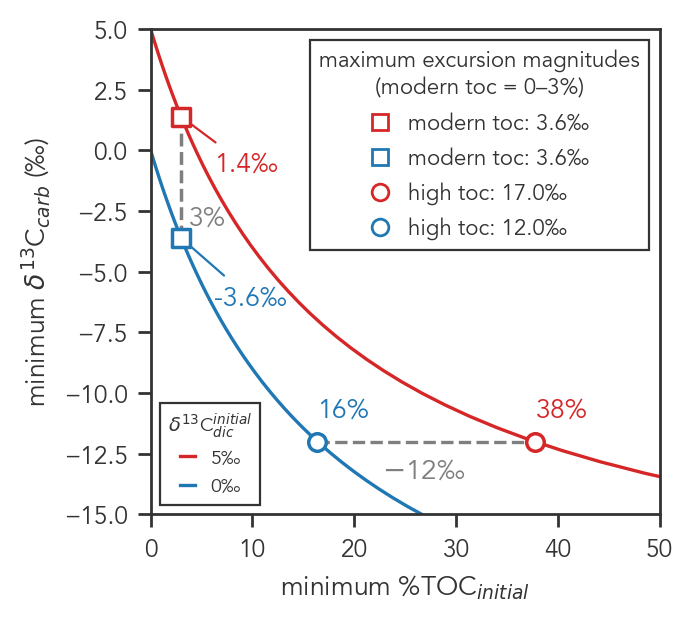

In [469]:
# helper: interpolate y at a given x (handles non-monotonic x by sorting)
def y_at_x(xarr, yarr, x0):
    order = np.argsort(xarr)
    xs, ys = xarr[order], yarr[order]
    if x0 < xs.min() or x0 > xs.max():
        return np.nan
    return np.interp(x0, xs, ys)

def bal1(ax):
    # inputs
    init, init1 = 0, 5
    num = 50
    ts  = np.linspace(-18, init,  num)   # y for blue curve
    ts1 = np.linspace(-18, init1, num)   # y for red curve
    
    # build x for each curve (% toc_initial)
    mt  = np.zeros_like(ts)
    mt1 = np.zeros_like(ts1)
    for i, (j, k) in enumerate(zip(ts, ts1)):
        om  = toc_delta(d_targ=j, d_sw=init)
        om1 = toc_delta(d_targ=k, d_sw=init1)
        mt[i]  = om  * max_TOC_percent
        mt1[i] = om1 * max_TOC_percent
    
    # plot the curves
    ax.plot(mt1, ts1, color='tab:red',  label=f'{init1}‰')
    ax.plot(mt,  ts,  color='tab:blue', label=f'{init}‰')
    ax.set_xlabel('minimum %TOC$_{initial}$')
    ax.set_ylabel('minimum $\\delta^{13}$C$_{carb}$ (‰)')
    ax.set_xlim(0, 50)
    ax.set_ylim(-15, np.ceil(np.max([ts, ts1])))
    
    # annotate the −12‰ targets (fixed-y case)
    x1 = toc_delta(d_targ=-12, d_sw=init1) * max_TOC_percent
    x2 = toc_delta(d_targ=-12, d_sw=init)  * max_TOC_percent
    ax.scatter(x1, -12, facecolor='w', edgecolor='tab:red',  s=40, lw=1.25, zorder=1000)
    ax.scatter(x2, -12, facecolor='w', edgecolor='tab:blue', s=40, lw=1.25, zorder=1000)
    ax.text(x1, -11, f'{x1:.0f}%', ha='left', color='tab:red')
    ax.text(x2, -11, f'{x2:.0f}%', ha='left', color='tab:blue')
    ax.hlines(y=-12, xmin=x2, xmax=x1, color='tab:grey', ls='--', zorder=0)
    ax.text(22.75, -13.5, '$-$12‰', fontsize=10, color='tab:grey')
    
    # excursion magnitudes for the fixed-y case
    ehigh_5 = abs(-12 - init1)   # 17‰ for baseline 5
    ehigh_0 = abs(-12 - init)    # 12‰ for baseline 0
    
    # compute excursion magnitudes at x = 3% toc
    x_mod = 3.0
    y_red_at3  = y_at_x(mt1, ts1, x_mod)
    y_blue_at3 = y_at_x(mt,  ts,  x_mod)
    
    # drop from each baseline to the value at x=3
    emod_5 = abs(y_red_at3  - init1)
    emod_0 = abs(y_blue_at3 - init)
    
    # dashed vertical line at 3% with label
    ax.vlines(x=x_mod, ymin=y_blue_at3, ymax=y_red_at3, color='tab:grey', lw=1.25, ls='--', zorder=0)
    ax.text(x_mod + 2.5, -2.25, '3%', ha='center', va='top', color='tab:grey')
    
    # plot the squares at x=3 so legend and markers match
    ax.scatter(x_mod, y_red_at3,  marker='s', facecolor='w', edgecolor='tab:red',  s=40, lw=1.25, zorder=1000)
    ax.scatter(x_mod, y_blue_at3, marker='s', facecolor='w', edgecolor='tab:blue', s=40, lw=1.25, zorder=1000)
    
    # annotate each square with a short connector so the text stays close
    ax.annotate(f'{y_red_at3:.1f}‰',
                xy=(x_mod, y_red_at3), xycoords='data',
                xytext=(x_mod + 3.25, y_red_at3 - 2), textcoords='data',
                arrowprops=dict(arrowstyle='-', color='tab:red', lw=0.8),
                ha='left', va='center', color='tab:red')
    
    ax.annotate(f'{y_blue_at3:.1f}‰',
                xy=(x_mod, y_blue_at3), xycoords='data',
                xytext=(x_mod + 3.25, y_blue_at3 - 2.5), textcoords='data',
                arrowprops=dict(arrowstyle='-', color='tab:blue', lw=0.8),
                ha='left', va='center', color='tab:blue')
    
    # keep your color legend for line colors
    leg_colors = ax.legend(loc=3, handlelength=0.75,
                           title='$\\delta^{13}$C$_{dic}^{initial}$',
                           title_fontsize=7, fontsize=7)
    ax.add_artist(leg_colors)
    
    # marker legend: values match markers at x=3 and circles at −12‰
    handles_markers = [
        Line2D([0], [0], marker='s', linestyle='none',
               markerfacecolor='w', markeredgecolor='tab:red', markersize=6,
               label=f'modern toc: {emod_5:.1f}‰'),
        Line2D([0], [0], marker='s', linestyle='none',
               markerfacecolor='w', markeredgecolor='tab:blue', markersize=6,
               label=f'modern toc: {emod_0:.1f}‰'),
        Line2D([0], [0], marker='o', linestyle='none',
               markerfacecolor='w', markeredgecolor='tab:red', markersize=6,
               label=f'high toc: {ehigh_5:.1f}‰'),
        Line2D([0], [0], marker='o', linestyle='none',
               markerfacecolor='w', markeredgecolor='tab:blue', markersize=6,
               label=f'high toc: {ehigh_0:.1f}‰'),
    ]
    leg = ax.legend(handles=handles_markers, loc=1, frameon=True,
                    fontsize=8,
                    title=f'maximum excursion magnitudes\n(modern toc = 0–{x_mod:.0f}%)',
                    title_fontsize=8, handlelength=0.9)
    leg.get_title().set_ha('center')

fig, ax = plt.subplots(figsize=(3.35, 3), layout='constrained')
bal1(ax)

# save
fig.savefig(tex_fig_dir + 'toc_mins.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)
#fig.savefig(diss_fig_dir + 'toc_mins.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

## Combo Figure V2

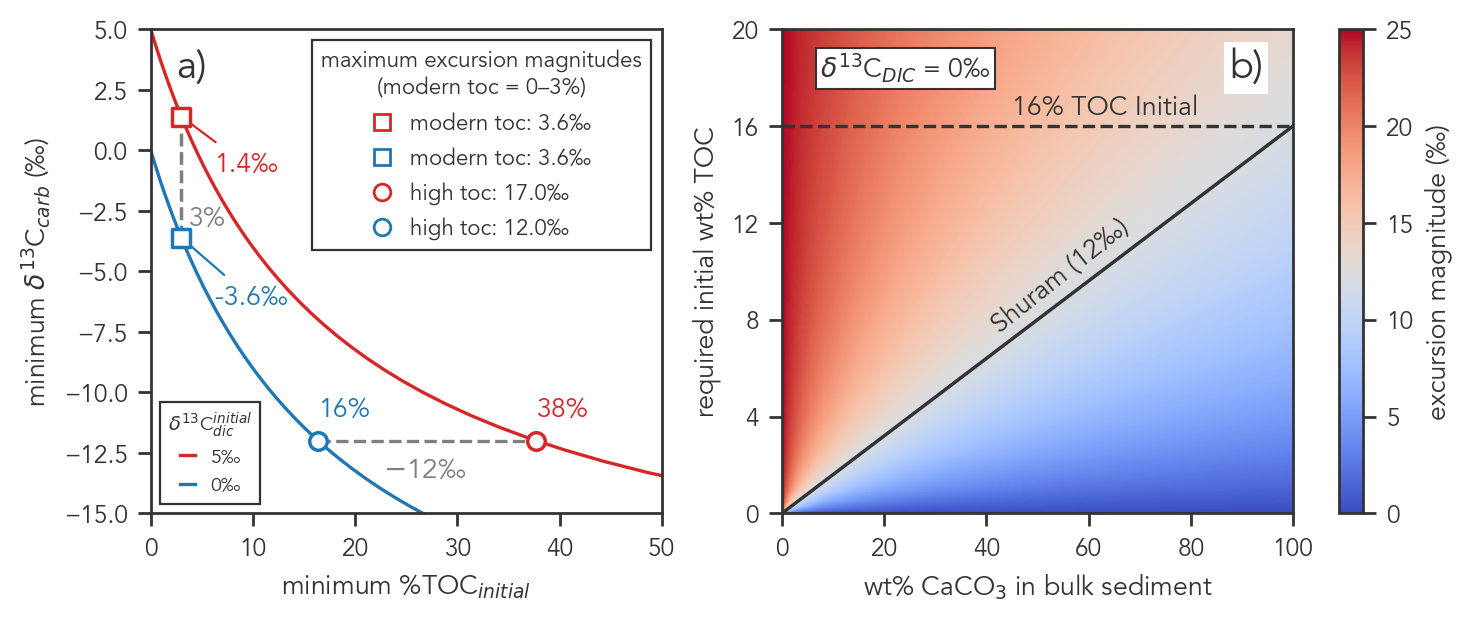

In [707]:
fig, ax = plt.subplots(1,2,figsize=(7.25, 3), layout='constrained')

## panel a
bal1(ax[0])

## panel b
plotmap_anchored(ax[1],tocmax=20,cmap='coolwarm',lcol='.2')

## label a,b
ax[0].text(0.05, 0.9, 'a)', transform=ax[0].transAxes, fontsize=14)
# ax[1].text(0.875,0.9,'b)',fontsize=14,transform=ax[1].transAxes)

# flag 16
ax[1].axhline(16,ls='--',color='.2')
ax[1].text(45,16.5,'16% TOC Initial',color='.2')

# save
fig.savefig(tex_fig_dir + 'toc_mins_combo.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=False)

- need to fix: need to make sure we are considering the same balance as the left, 100% caco3 reacts with 100% organic moles, and on the right, we need to show some non-100% caco3 fraction (rest is siliciclastics) reacting with organics

# End-member version: make all arrays based on my molar balance above

In [21]:
sto2 = d13c_solve
grid2 = img(sto2.T,o1b,ylen=1000)
print(sto2.shape)

(400, 2000)


Text(0, 0.5, '$h$')

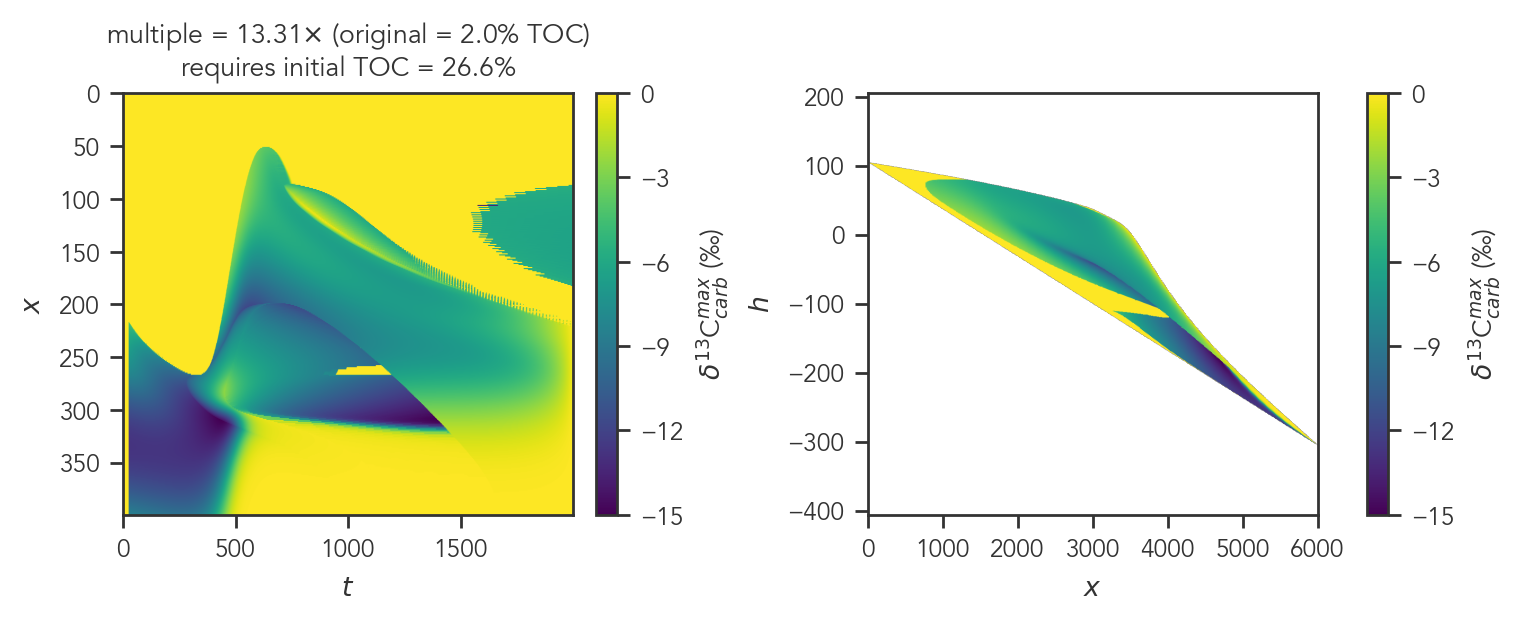

In [22]:
fig,ax = plt.subplots(1,2,figsize=(7.5,3),layout='constrained')
im = ax[0].imshow(sto2,aspect='auto',cmap='viridis')
cbar = plt.colorbar(im,label='$\\delta^{13}$C$^{max}_{carb}$ (‰)')
cbar.ax.set_yticks(np.linspace(np.nanmin(sto2),np.nanmax(sto2),6))
ax[0].set_title(f'multiple = {org_mult:.2f}$\\times$ (original = {max_TOC_percent}% TOC)\nrequires initial TOC = {max_TOC_percent*org_mult:.1f}%')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$x$')

im1 = ax[1].imshow(grid2,aspect='auto',origin='lower',cmap='viridis',extent=o1b.extent,vmin=np.nanmin(sto2),vmax=np.nanmax(sto2))
cbar1 = plt.colorbar(im1,label='$\\delta^{13}$C$^{max}_{carb}$ (‰)')
cbar1.ax.set_yticks(np.linspace(np.nanmin(sto2),np.nanmax(sto2),6))
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$h$')

## log carbonate sedimentation rate vs log toc

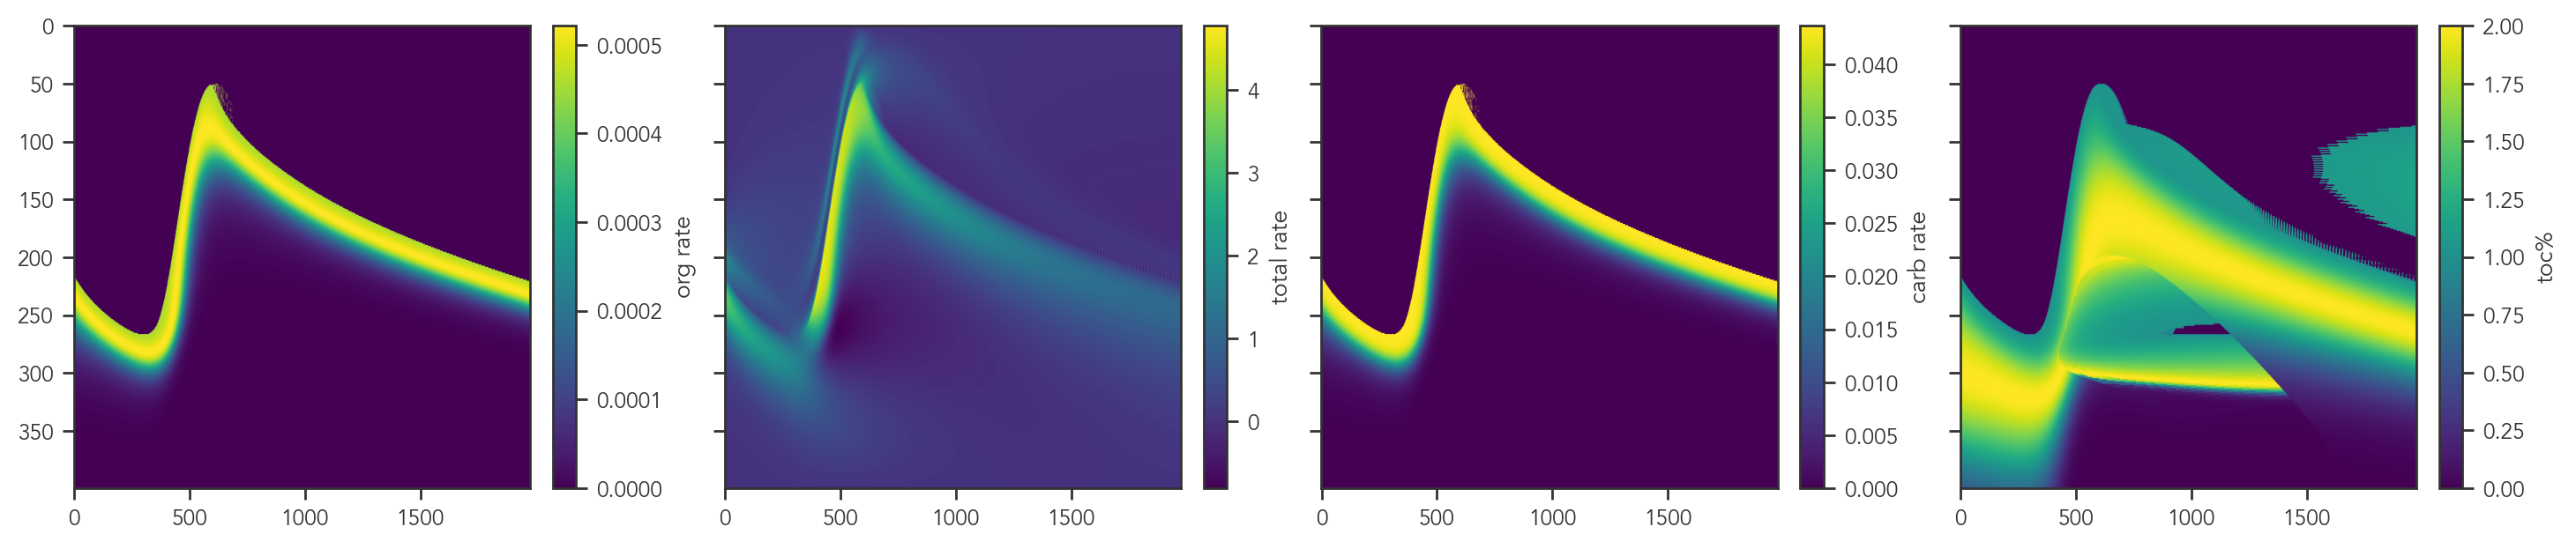

In [23]:
fig, ax = plt.subplots(1,4,figsize=(14.5, 3),sharey=True,layout='constrained')

# extract variables
cut = int(p1['toc_t_cutoff']*p1['dt'])
eroded = np.isnan(o1a.proxy_sto_eroded.T[:,cut:])
toc = o1a.sto[1::2,cut:]      # TOC% preserved (Nx, Nt)
orate = o1a.osed_sto[:,cut:]  # organic rate
crate = o1b.csed_sto[:,cut:]   # carbonate rate. both of these have div dt already in code
rate = o1b.dsed_sto[:,cut:]    # total change in topography
rmask = (rate>-6)


orate = np.where(eroded, np.nan, orate)
crate = np.where(eroded, np.nan, crate)
toc = np.where(eroded, np.nan, toc)
rate = np.where(eroded, np.nan, rate)

# crossplot: flatten and filter
orate_flat = orate.flatten()
rate_flat = rate.flatten()
toc_flat = toc.flatten()
crate_flat = crate.flatten()

# clean and log-transform data
mask = (~np.isnan(rate_flat)) & (~np.isnan(orate_flat)) & (~np.isnan(crate_flat)) & (~np.isnan(toc_flat)) \
       & (rate_flat > 0) & (orate_flat > 0) & (crate_flat > 0) & (toc_flat > 0)

csed_log = np.log10(crate_flat[mask])   # G_carb
tsed_log = np.log10(rate_flat[mask])    # G_total
osed_log = np.log10(orate_flat[mask])   # G_org
toc_log  = np.log10(toc_flat[mask])     # TOC wt%

# filter out low tsed outliers
lim = -4 # log scale
csed_log = np.where(tsed_log>lim,csed_log,np.nan)
tsed_log = np.where(tsed_log>lim,tsed_log,np.nan)
osed_log = np.where(tsed_log>lim,osed_log,np.nan)
toc_log = np.where(tsed_log>lim,toc_log,np.nan)

# remove nans again
mask1 = (~np.isnan(csed_log)) & (~np.isnan(tsed_log)) & (~np.isnan(osed_log)) & (~np.isnan(toc_log))
csed_log = csed_log[mask1]
tsed_log = tsed_log[mask1]
osed_log = osed_log[mask1]
toc_log = toc_log[mask1]

# filter out low tse
imt = ax[0].imshow(orate,aspect='auto')
plt.colorbar(imt,label='org rate')
imr = ax[1].imshow(rate,aspect='auto')
plt.colorbar(imr,label='total rate')
imc = ax[2].imshow(crate,aspect='auto')
plt.colorbar(imc,label='carb rate')
imo = ax[3].imshow(toc,aspect='auto')
plt.colorbar(imo,label='toc%');

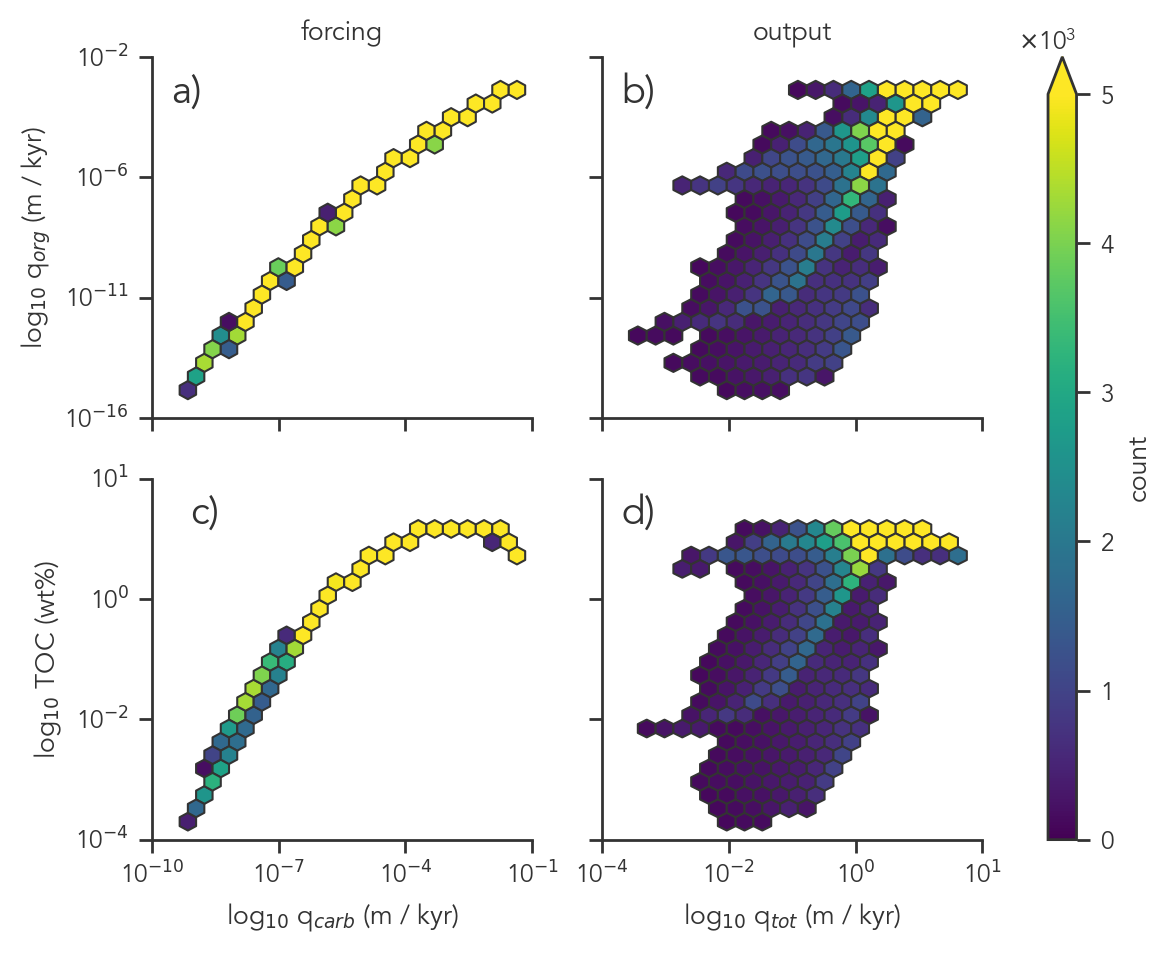

In [24]:
# define linear model
def loglog_linear(x, a, b):
    return a * x + b

# setup plot layout
fig, ax = plt.subplot_mosaic(
    """
    abe
    cde
    """, figsize=(5.75, 4.65), width_ratios=[1, 1, 0.075], layout='constrained'
)

axs = sorted(list(ax))
vmax = 5000
cmap = 'viridis'

# define data pairs for each subplot, numbers are max and min ranges for x_fit for linear fit
xys = {
    'a': (csed_log, osed_log, -10, -1),
    'b': (tsed_log, osed_log, -4, 1),
    'c': (csed_log, toc_log, -10, -1),
    'd': (tsed_log, toc_log, -4, 1),
}

for k, (x, y, mi, ma) in xys.items():

    hb = ax[k].hexbin(x, y, gridsize=20, clip_on=True, alpha=1,
                      edgecolor='.2', lw=0.75, cmap=cmap, mincnt=100,
                      vmin=0, vmax=vmax, zorder=1)

    # # compute spearman rho
    # rho, _ = spearmanr(x, y)

    # # fit and plot
    # popt, _ = curve_fit(loglog_linear, x, y)
    # #x_fit = np.linspace(x.min(), x.max(), 250)
    # x_fit = np.linspace(mi, ma, 250)
    # y_fit = loglog_linear(x_fit, *popt)
    # ax[k].plot(x_fit, y_fit, color='r', ls='--', lw=1.75,
    #            label=fr'$\rho = {rho:.2f}$', zorder=2)

    # leg = ax[k].legend(loc='lower right', fontsize=7, frameon=True, handlelength=1.25,bbox_to_anchor=(1.025,0.025))
    # leg.set_zorder(102)

# shared labels
ax['a'].set_ylabel('log$_{10}$ q$_{org}$ (m / kyr)')
ax['c'].set_xlabel('log$_{10}$ q$_{carb}$ (m / kyr)')
ax['c'].set_ylabel('log$_{10}$ TOC (wt%)')
ax['d'].set_xlabel('log$_{10}$ q$_{tot}$ (m / kyr)')

# axis linking and ticks
ax['c'].sharex(ax['a'])
ax['d'].sharex(ax['b'])
ax['b'].sharey(ax['a'])
ax['d'].sharey(ax['c'])
ax['b'].tick_params(labelleft=False, labelbottom=False)
ax['a'].tick_params(labelbottom=False)
ax['d'].tick_params(labelleft=False)

# tick formatting
def plain_power_format(x, _):
    return f'10$^{{{int(x)}}}$'

for i in axs[:-1]:
    ax[i].xaxis.set_major_formatter(ticker.FuncFormatter(plain_power_format))
    ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(plain_power_format))
    #ax[i].tick_params(axis='both', which='major', length=0, direction='out')
    #ax[i].set_facecolor('none')
    #ax[i].grid(zorder=0, ls='-')

# colorbar
cb = fig.colorbar(hb, cax=ax['e'], label='count', extend='max')
cb.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
cb.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# titles
ax['a'].set_title('forcing')
ax['b'].set_title('output')

# panel labels
labels = ['a)', 'b)', 'c)', 'd)']
for i, label in enumerate(labels):
    xi = 0.05 if axs[i] != 'c' else 0.1
    ax[axs[i]].text(xi, 0.875, label, transform=ax[axs[i]].transAxes, fontsize=14)

# format lims
ax['d'].set_xlim(-4,1)
ax['d'].set_xticks(np.linspace(-4,1,4))
ax['c'].set_xlim(-10,-1)
ax['c'].set_xticks(np.linspace(-10,-1,4))
ax['a'].set_ylim(-16,-2)
ax['a'].set_yticks(np.linspace(-16,-2,4))
ax['c'].set_ylim(-4,1)
ax['c'].set_yticks(np.linspace(-4,1,4))

for i in axs[:-1]:
    ax[i].spines[['top','right']].set_visible(False)
    #ax[i].tick_params(axis='both',direction='in')
    ax[i].set_zorder(1000000)

# save
fig.savefig(tex_fig_dir + 'carb_rate_vs_toc.pdf', format='pdf', dpi=600,bbox_inches='tight', transparent=True)
#fig.savefig(diss_fig_dir + 'carb_rate_vs_toc.pdf', format='pdf', dpi=600,bbox_inches='tight', transparent=True)

In [25]:
@interact(idx=(1,399))
def f(idx):
    fig,ax = plt.subplots(1,2,figsize=(6.25,4.5),layout='constrained',width_ratios=[1,0.5])
    
    im = ax[0].imshow(grid2,aspect='auto',cmap='rainbow',extent=o1b.extent,origin='lower')
    #im = ax[0].imshow(o1b.facies_pred,aspect='auto',cmap=o1b.cmap,origin='lower')
    cb = plt.colorbar(im,ax=ax[0],location='top',label='d13c_carb')
    cb.ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    toc = grid_d[:,idx]
    carb = np.flipud(grid2[:,idx])
    v = o1b.Nx_toX([idx], out='grid')
    ax[0].axvline(v,color='tab:orange',ls='--')
    ax[1].plot(carb,np.arange(len(carb)),label='carb')
    ax[1].set_xlabel('d13c_carb',color='tab:blue')
    ax1 = ax[1].twiny()
    ax1.plot(toc,np.arange(len(toc)),label='toc',color='tab:red',ls=':')
    ax1.set_xlabel('%toc loss',color='tab:red')
    #ax1.set_xlim(-0.05,1)
    #ax[1].set_xlim(p2['ep'],wi2[0])
    #ax[1].set_xticks(np.linspace(p2['ep'],wi2[0],3))
    ax[1].invert_yaxis()
    ax[0].plot(o1b.x,o1b.beds[o1b.reg_idx,:].T,alpha=1,ls=':',label='regressive surface',color='k',lw=1);
    ax[0].plot(o1b.x,o1b.beds_eroded[o1b.tran_idx,:].T,alpha=1,ls='--',label='transgressive surface',color='k',lw=1);
    ax[0].plot(o1b.x,o1b.beds[0],c='k',lw=1)
    ax[0].plot(o1b.x,o1b.beds_eroded[-1],c='k',lw=1)
    axi = ax[0].inset_axes([0.25,0.1,0.4,0.2])
    axi.set_xticks([]);
    axi.plot(t,sl_fun(t))
    axi.set_ylabel('rsl')
    axi.spines[['right','top','bottom']].set_visible(False)
    axi.set_facecolor('none')
    plt.show()

interactive(children=(IntSlider(value=200, description='idx', max=399, min=1), Output()), _dom_classes=('widge…

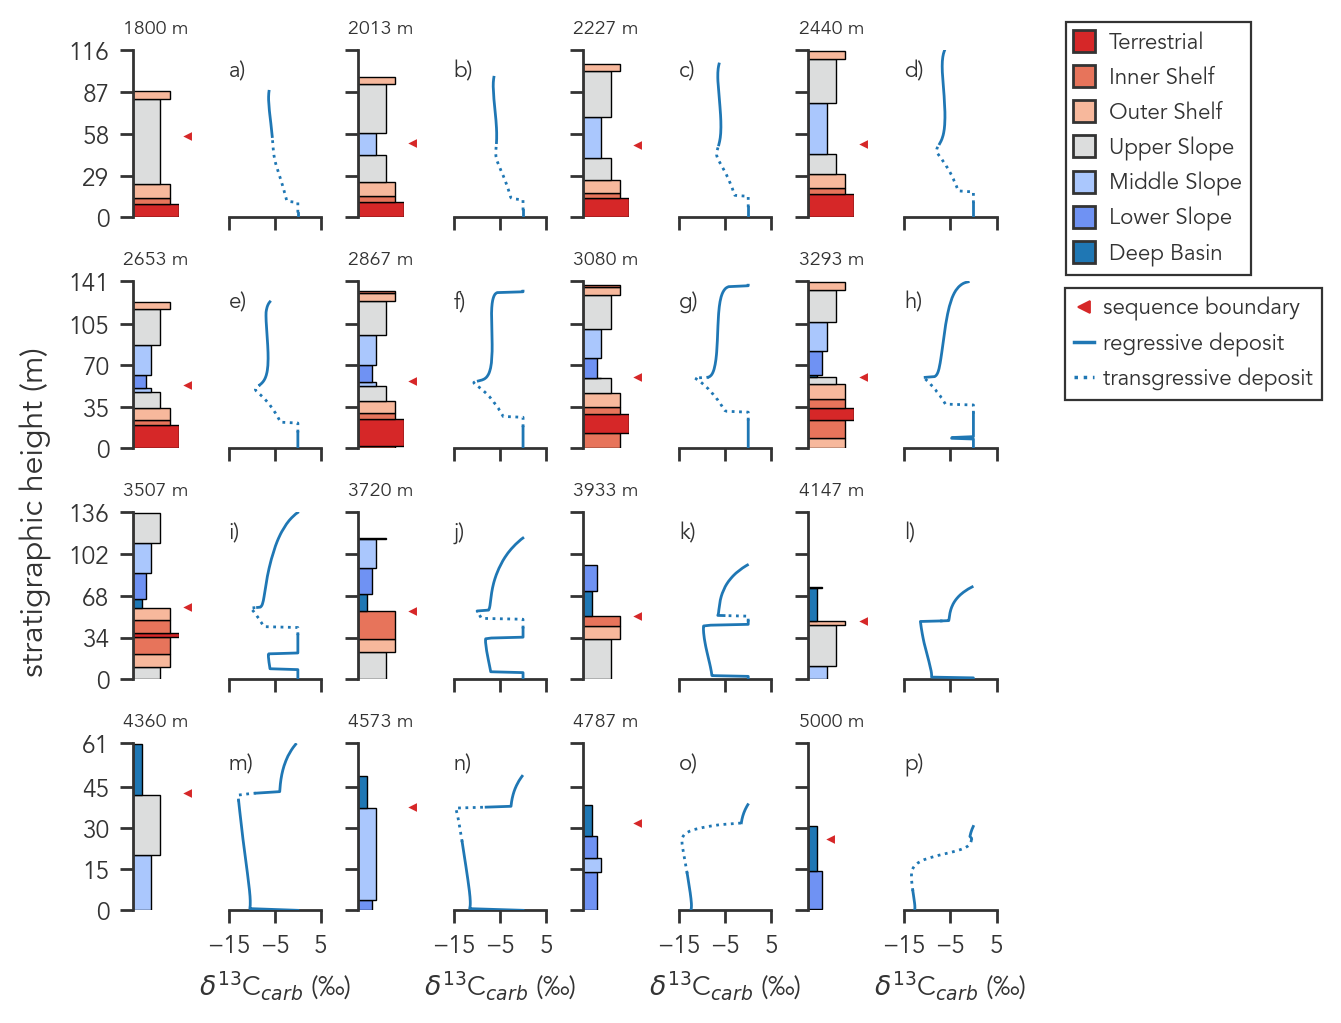

In [765]:
locs = np.linspace(1800, 5000, 16)
locs2 = o1b.Nx_toX(locs, out='Nx')
labels = [f'{l})' for l in string.ascii_lowercase[:16]]

fig, ax = plt.subplots(4, 8, figsize=(5, 5), width_ratios=[0.5, 1]*4, layout='constrained')

# store y_min/y_max per subplot
row_ranges = [[] for _ in range(4)]
y_lims = [[None, None] for _ in range(4)]

for i in range(16):
    row = i // 4
    col = i % 4
    strat_ax = ax[row, col * 2]
    chem_ax = ax[row, col * 2 + 1]
    l = locs2[i]
    l1 = locs[i]
    
    # strat column
    targ_val, new_y_val, y_min, y_max, seq_y = o1b.strat_col_im(
        l, targ=grid2, out=True, plot=True, ax=strat_ax,
        x_axis=False, seq_bounds=True, seq_color='#c74545', seq_lw=1.25)

    strat_ax.set_xlim(0, 1)  # force plot setup before reading limits
    ymin, ymax = strat_ax.get_ylim()
    row_ranges[row].append((i, ymax - ymin, ymin, ymax))

    # sequence boundaries
    for j, s in enumerate(seq_y[1:]):
        if j % 2 == 0:
            xi = 1.2 if i < len(locs) - 1 else 0.5
            strat_ax.plot(xi, s, marker='<', color='tab:red', zorder=1000, markersize=1.5, clip_on=False)

    # δ13C bars
    o1b.tr_bars(
        loc=l, ax=chem_ax, xval=targ_val, yval=new_y_val, line=True,
        lines=['-', ':'], colors=['tab:blue', 'tab:blue'], alpha=1, legend=False, edgecolor='w', lw=1, # lines need to be switched to properly match visually ['-', ':']
        xticks=True, zorder=1200)

    strat_ax.set_xlim(0, 1)
    chem_ax.set_xlim(-12, 5)
    chem_ax.set_xticks([-15, -5, 5])
    chem_ax.spines[['top', 'right', 'left']].set_visible(False)
    strat_ax.set_title(f'{l1:.0f} m', fontsize=7)

    if row == 3:
        chem_ax.set_xlabel(r'$\delta^{13}$C$_{carb}$ (‰)')
    else:
        chem_ax.set_xticklabels([])

    chem_ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    chem_ax.sharey(strat_ax)

    # subplot label
    chem_ax.text(0, 0.8, labels[i], transform=chem_ax.transAxes,
                 ha='left', va='bottom', fontsize=8, color='.2')

# set master y ticks and labels for each row
for row in range(4):
    # find the subplot in the row with the largest height range
    i_max, _, y_min, y_max = max(row_ranges[row], key=lambda x: x[1])
    ticks = np.linspace(np.floor(y_min), np.ceil(y_max), 5).astype(int)

    for j in range(4):
        idx = row * 4 + j
        strat_ax = ax[row, j * 2]
        chem_ax = ax[row, j * 2 + 1]
        strat_ax.set_yticks(ticks)
        
        if j == 0:
            strat_ax.set_yticklabels(ticks)
        else:
            strat_ax.set_yticklabels([])

fig.supylabel('stratigraphic height (m)')

legend_handles1 = [
    plt.Line2D([], [], marker='s', color='none', markerfacecolor=c, markeredgecolor='.2',
               markersize=8, label=l)
    for c, l in zip(colors1, elabs1)]

fig.legend(
    handles=legend_handles1,
    frameon=True,
    loc=1,
    bbox_to_anchor=(1.25, 1),
    ncols=1,
    handlelength=0.75,
    handletextpad=0.75,
    columnspacing=0.8,
    fontsize=8)

# legend 1: d13c stuff
el_d13C = [
    Line2D([0], [0], mew=0.65, lw=0, marker='<', color='tab:red', ls='-', label='sequence boundary', markerfacecolor='tab:red', markersize=4),
    Line2D([0], [0], mew=0.65, lw=1.25, marker='none', color='tab:blue', ls='-', label='regressive deposit', markerfacecolor='none', markersize=0),
    Line2D([0], [0], mew=0.65, lw=1.25, marker='none', color='tab:blue', ls=':', label='transgressive deposit', markerfacecolor='none', markersize=0)]

fig.legend(handles=el_d13C, loc=4, bbox_to_anchor=(1.32125, 0.6), ncols=1, frameon=True, framealpha=1, fontsize=8,
             handletextpad=0.4, markerfirst=True, handlelength=0.9, columnspacing=-2)#,title='$\\delta^{13}$C')

fig.savefig(tex_fig_dir + 'basin_variance.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)
#fig.savefig(diss_fig_dir + 'env_react.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

### Demonstration Figure for main text

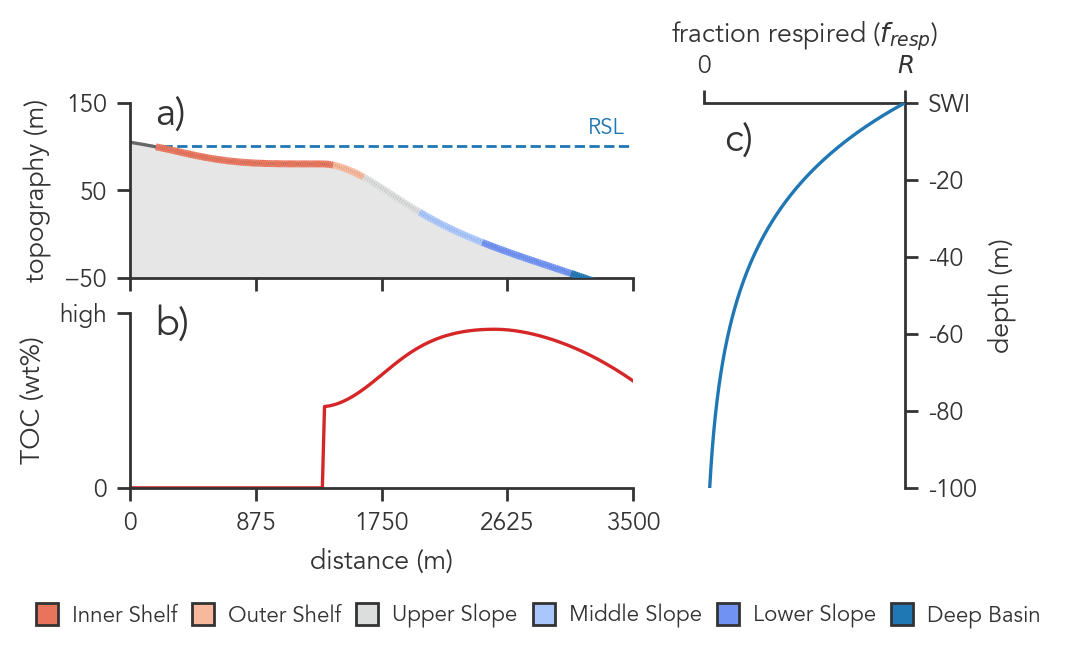

In [48]:
fig,ax = plt.subplot_mosaic(
    """
    ac
    bc
    """,figsize=(5,2.5),width_ratios=(1,.4))

a = list(ax)

# fig,ax = plt.subplot_mosaic(
#     """
#     ac.d
#     bc.d
#     """,figsize=(9,2.5),width_ratios=(1,.4,.1,.8))

a = list(ax)

# basin snapshot
tidx = 725 #1370 
bed = o1a.beds[tidx]
ax['a'].plot(o1a.x,bed,color='.4')
ax['a'].set_xlim(0,3500)
ax['a'].set_xticks(np.linspace(0,3500,5))
ax['a'].set_ylim(-50,150)
ax['a'].set_yticks(np.linspace(-50,150,3))
ax['a'].set_ylabel('topography (m)')
ax['a'].tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax['a'].fill_between(o1b.x, bed, y2=min(bed), color='.9')

# rsl
rsl = o1a.rsl_strat[tidx]
shore = o1b.sl[tidx]
ax['a'].hlines(y=rsl,xmin=shore,xmax=o1a.x[-1],zorder=0,ls='--',lw=1)

# coloured line
# compute depth and mask land
depth = rsl - bed
depth = np.where(depth > 0, depth, np.nan)

# build segments
x_vals = o1a.x
y_vals = bed
points = np.array([x_vals, y_vals]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# assign color to each segment based on depth
segment_colors = []
valid_segments = []

for i in range(len(segments)):
    d1, d2 = depth[i], depth[i+1]
    if np.isnan(d1) or np.isnan(d2):
        continue  # skip land or invalid
    avg_depth = 0.5 * (d1 + d2)
    for facies in o1b.facies_data[1:]:
        color = facies['colour']
        if facies['min'] <= avg_depth < facies['max']:
            valid_segments.append(segments[i])
            segment_colors.append(color)
            break

# plot colored topography
lc = LineCollection(valid_segments, colors=segment_colors, linewidths=2.5, zorder=10000)
ax['a'].add_collection(lc)

# TOC environments
ax['b'].sharex(ax['a'])
ax['b'].set_xlabel('distance (m)')

# calculating TOC with my masks and bias 
rsl = o1a.rsl_strat[tidx]
bed = o1a.beds[tidx]
depth = rsl - bed
mask = depth > 0
cg = o1a.csed_sto[:,tidx]
sed_rate_norm = cg / np.nanmax(cg + 1e-12)
og = org_growth(depth)
G_org = og * sed_rate_norm
h_org = np.where(mask, np.abs(G_org), 0.0)

h_carb = cg
tot_sed = h_org + h_carb + 1e-12
val = (h_org / tot_sed) 
toc = np.where(tot_sed > 0, val, 0.0)

ax['b'].plot(o1a.x,toc,color='tab:red',label='slope bias')
ax['b'].set_ylabel('TOC (wt%)')
max_ng = np.nanmax(toc)
rounded_max = round(max_ng , 4)  # rounds mantissa to 1 decimal
ax['b'].set_ylim(0,rounded_max+0.00025)
ax['b'].set_yticks([0,rounded_max+0.00025],['0','high'])

# format
for i,j in enumerate(a):
    if j not in ['c','d']:
        ax[j].spines[['right','top']].set_visible(False)

# loss rate plot
ax['c'].yaxis.tick_right()  
ax['c'].yaxis.set_label_position('right')
ax['c'].xaxis.tick_top()  
ax['c'].xaxis.set_label_position('top')
ax['c'].spines[['left','bottom']].set_visible(False)
ax['c'].plot(resp_curve_new , zs, label='$R$', color='tab:blue',ls='-',zorder=1000000)
ax['c'].set(xlabel='fraction respired ($f_{resp}$)', ylabel='depth (m)', ylim=(-100, 0), xlim=(0, 1))

# replace 0m with swi label
ax['c'].set_ylim(top=0)
yticks = ax['c'].get_yticks()
yticklabels = [f'{int(t)}' if t != 0 else 'SWI' for t in yticks]
ax['c'].set_yticks(yticks) # needs to be here to suppress warning
ax['c'].set_yticklabels(yticklabels);

# replace 1 with R
ax['c'].set_xlim(right=1)
xticks = [0,1] #ax['c'].get_xticks()
#xticklabels = [f'{int(t)}' if t != 1 else '$R$' for t in xticks]
xticklabels=['0','$R$']
ax['c'].set_xticks(xticks) # needs to be here to suppress warning
ax['c'].set_xticklabels(xticklabels);

# generate dummy scatter handles with circle markers for the legend
elabs = [i['name'] for i in o1b.facies_data][1:] # skip terrestrial
colors = facies_colours[1:] # skip terrestrial

legend_handles = [
    plt.Line2D([], [], marker='s', color='none', markerfacecolor=c, markeredgecolor='.2',
               markersize=8, label=l)
    for c, l in zip(colors, elabs)]

ax['a'].legend(
    handles=legend_handles,
    frameon=False,
    loc=1,
    bbox_to_anchor=(1.85, -1.75),
    ncols=len(elabs),
    handlelength=0.75,
    handletextpad=0.75,
    columnspacing=0.8,
    fontsize=8)

# label rsl
ax['a'].text(0.91,0.825,'RSL',color='tab:blue',fontsize=8,transform=ax['a'].transAxes)

# inset 
#axi = ax['b'].inset_axes([0.14,0.4,0.2,0.6])

# choose how many points to keep
n_keep = 2000 # 2000

# choose random indices and sort to preserve original order
idx = np.sort(np.random.choice(len(csed_log), n_keep, replace=False))

# downsampled data (full scatter makes a large image and slow latex compile)
subset_csed_log, subset_toc_log = csed_log[idx], toc_log[idx]
#subset_csed_log, subset_toc_log = csed_log, toc_log

# axi.tick_params(length=0,labelsize=5)
# axi.scatter(subset_csed_log,subset_toc_log,fc='tab:blue',ec='none',s=2)
# axi.set_xlabel('log$_{10}$\n$q_{carb}$ (m/kyr)',fontsize=6,labelpad=-5)
# axi.set_ylabel('log$_{10}$\nTOC (wt%)',fontsize=6,labelpad=-5)
# axi.set_xlim(-10,-1)
# axi.set_xticks(np.linspace(-10,-1,2))
# axi.set_ylim(-4,1)
# axi.set_yticks(np.linspace(-4,1,2))
# axi.spines[['right','top']].set_visible(False)
# axi.xaxis.set_major_formatter(ticker.FuncFormatter(plain_power_format))
# axi.yaxis.set_major_formatter(ticker.FuncFormatter(plain_power_format))
# axi.text(0.8,0.15,'d)',transform=axi.transAxes)

# label abc
# labels = ['a)', 'c)', 'd)', 'b)']
# for i, label in zip(a,labels):
#     xi = 0.05 #if i != 'c' else 0.1
#     #xi = xi if i!='b' else 0.95
#     ax[i].text(xi, 0.875, label, transform=ax[i].transAxes, fontsize=14)

# label abc
labels = ['a)', 'c)', 'b)']
for i, label in zip(a,labels):
    xi = 0.05 if i != 'c' else 0.1
    #xi = xi if i!='b' else 0.95
    ax[i].text(xi, 0.875, label, transform=ax[i].transAxes, fontsize=14)

# save figure
fig.savefig(tex_fig_dir + 'env_react.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)
#fig.savefig(diss_fig_dir + 'env_react.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

### Busch (Section 4.2.2) – Water Depth Trends

- A strong depth-dependent gradient is observed across multiple geochemical proxies in the Shuram CIE dataset.
- **Deeper-water (slope and outer shelf) samples**:
  - Predominantly limestone
  - d44Ca and d13C values: ~−15 to −8
  - Elevated Sr/Ca and U/Ca ratios
- **Shallower-water (inner and middle ramp) samples**:
  - Predominantly dolostone
  - d44Ca values: ~−1.4 to −0.3
  - d13C values: ~−6 to +8
  - Lower Sr/Ca and U/Ca ratios

### Busch environment binning

In [28]:
busch = pd.read_excel(data_dir + 'Busch/busch2022_shuram.xlsx')
print(busch.columns)
print(set(busch['water depth']))

Index(['location', 'section', 'mineralogy', 'water depth', 'height (m)',
       'd13C', 'd18O', '44/40Ca', '44/42Ca', '44/43Ca', 'd26Mg', 'd25Mg',
       'Sr/Ca (mmol/mol)', 'Mg/Ca (mmol/mol)', 'Mn/Ca (μmol/mol)',
       'U/Ca (μmol/mol)', 'Mn/Sr (mmol/mmol)'],
      dtype='object')
{1, 2, 3, 4, 5}


In [29]:
# map facies codes
busch_facies_labels = {
    1: 'Inner\nRamp',
    2: 'Middle\nRamp',
    3: 'Mid-Outer\nRamp',
    4: 'Outer\nRamp',
    5: 'Slope'}

# create a new column with labels
busch['environment'] = busch['water depth'].map(busch_facies_labels)
busch.head()

location section mineralogy  water depth  height (m)   d13C   d18O  \
0  Australia    J162  Limestone            5        44.4 -11.24 -15.46   
1  Australia    J162  Limestone            5        59.1 -10.70 -15.26   
2  Australia    J162  Limestone            5        64.1 -10.11 -15.32   
3  Australia    J162  Limestone            5        76.0  -9.61 -14.90   
4  Australia    J162  Limestone            5        87.3  -9.66 -15.52   

    44/40Ca   44/42Ca  44/43Ca  d26Mg  d25Mg  Sr/Ca (mmol/mol)  \
0 -0.891791  0.097092      NaN    NaN    NaN          0.174364   
1 -0.681694  0.199081      NaN    NaN    NaN          0.174153   
2       NaN       NaN      NaN    NaN    NaN          0.193629   
3 -0.659859  0.209680      NaN    NaN    NaN          0.224880   
4 -1.003054  0.043080      NaN    NaN    NaN          0.224457   

   Mg/Ca (mmol/mol)  Mn/Ca (μmol/mol)  U/Ca (μmol/mol)  Mn/Sr (mmol/mmol)  \
0             25.67         9159.2331              NaN          52.529412   
1             24.43         7027.5898              NaN          40.352941   
2             19.10         7785.9240              NaN          40.210526   
3             22.18         7093.9292              NaN          31.545455   
4             20.26         7182.6304              NaN          32.000000   

  environment  
0       Slope  
1       Slope  
2       Slope  
3       Slope  
4       Slope

In [30]:
np.nanmax(busch['d13C'])

np.float64(8.4965)

### Model environment binning

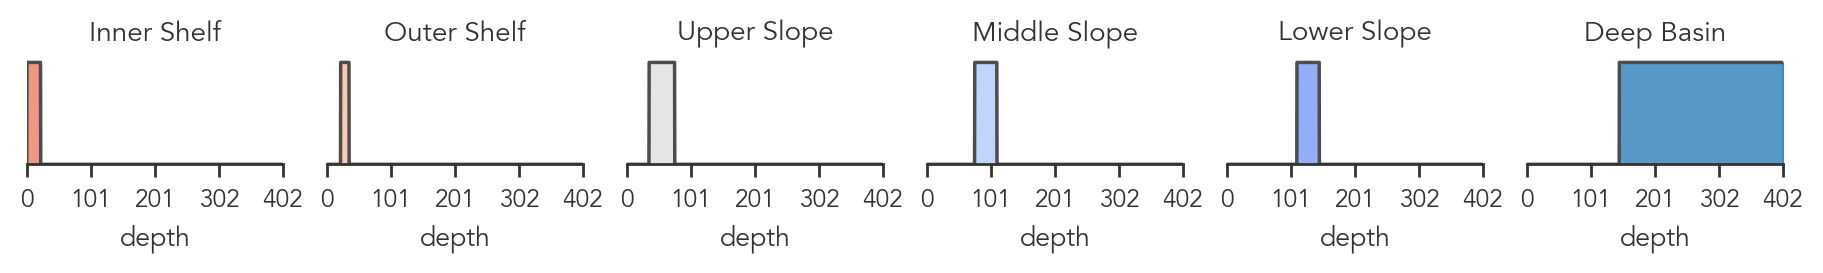

In [31]:
fig = o1b.show_facies_dists(o1b.im_d,out=True)

## Boxplots with Busch data

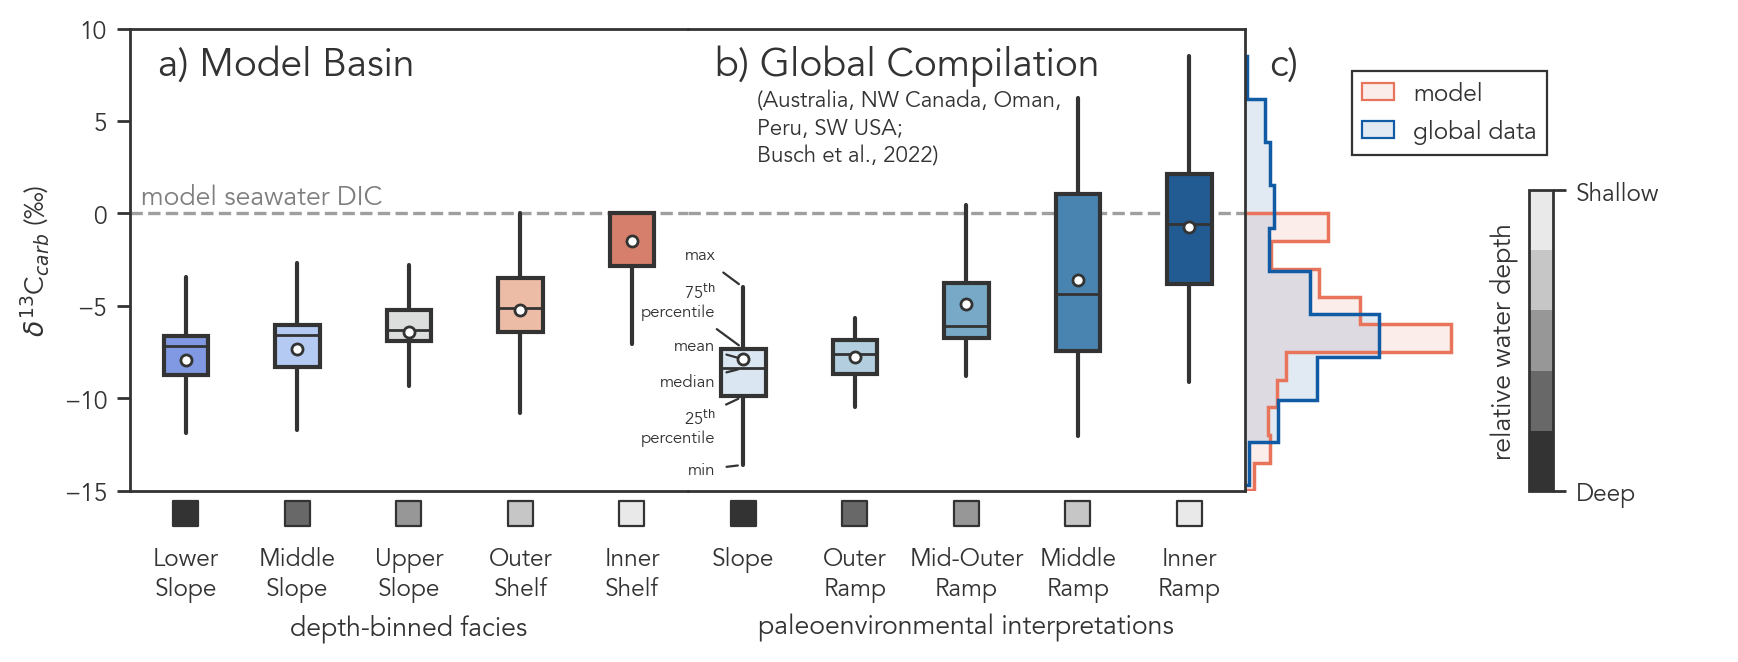

In [32]:
# grab binned isotopes
facies_w = o1b.get_facies_val(o1b.facies_pred, grid2)

# get original order of facies
facies_labels = list(facies_w.keys())

# convert dictionary to long-format DataFrame
df = pd.DataFrame([(facies, val) for facies, values in facies_w.items() for val in values],
                  columns=['dtype', 'd13c_carb'])

# add line breaks to facies labels for nicer x-axis display
df['dtype'] = df['dtype'].replace({
    'Deep Basin': 'Deep\nBasin',
    'Lower Slope': 'Lower\nSlope',
    'Middle Slope': 'Middle\nSlope',
    'Upper Slope': 'Upper\nSlope',
    'Outer Shelf': 'Outer\nShelf',
    'Inner Shelf': 'Inner\nShelf',
    'Terrestrial': 'Terrestrial'  # if needed
})

# skip the first facies (e.g., 'terrestrial')
skip_facies = ['Terrestrial', 'Deep\nBasin']  # skip both
df_filtered = df[~df['dtype'].isin(skip_facies)]
order_filtered = [f for f in df['dtype'].unique() if f not in skip_facies][::-1]


# compute means
means = df_filtered.groupby('dtype')['d13c_carb'].mean().reindex(order_filtered)

# delta matrix - find the mean differences in d13c between facies environments
delta_matrix = np.zeros((len(order_filtered), len(order_filtered)))
for i, f1 in enumerate(order_filtered):
    for j, f2 in enumerate(order_filtered):
        delta_matrix[i, j] = means[f1] - means[f2]

# plot: boxplot and heatmap
fig, ax = plt.subplots(1, 3, sharey=False,figsize=(10.25, 3),width_ratios=[1,1,.85])

# boxplot on ax[0]
sns.boxplot(x='dtype', y='d13c_carb', data=df_filtered, order=order_filtered, ax=ax[0],
            hue='dtype', palette='coolwarm_r', showfliers=False,
            capprops=dict(linewidth=0, alpha=1),
            boxprops=dict(alpha=1, linewidth=1.5, edgecolor='.2'),
            width=0.4,
            showmeans=True,
            meanprops=dict(marker='o', markerfacecolor='w', alpha=1, mec='.2', markersize=4),
            whiskerprops=dict(linewidth=1.5, solid_capstyle='round', color='.2'),
            medianprops=dict(color='.2', linewidth=1, alpha=1))

ax[0].set_xlabel(None)
ax[0].set_ylabel('$\\delta^{13}$C$_{carb}$ (‰)')

# Busch data
b_order = ['Slope','Outer\nRamp','Mid-Outer\nRamp','Middle\nRamp','Inner\nRamp']
sns.boxplot(x='environment', y='d13C', data=busch,order=b_order,ax=ax[1],
            hue='environment', palette='Blues', showfliers=False,hue_order=b_order,
            capprops=dict(linewidth=0, alpha=1),
            boxprops=dict(alpha=1, linewidth=1.5, edgecolor='.2'),
            width=0.4,
            showmeans=True,
            meanprops=dict(marker='o', markerfacecolor='w', alpha=1, mec='.2', markersize=4),
            whiskerprops=dict(linewidth=1.5, solid_capstyle='round', color='.2'),
            medianprops=dict(color='.2', linewidth=1, alpha=1))
ax[1].set_xlabel(None)

# label ab
labs = ['a) Model Basin','b) Global Compilation', 'c)']
for i,l in enumerate(labs):
    ax[i].text(0.05, 0.9, l, transform=ax[i].transAxes, fontsize=14)
    #ax[i].yaxis.grid(ls='-',zorder=0)

# label busch
ax[1].text(0.125, 0.7125, '(Australia, NW Canada, Oman,\nPeru, SW USA;\nBusch et al., 2022)', transform=ax[1].transAxes, fontsize=8) # 0.825
#ax[1].text(0.125, 0.725, '(Busch et al., 2022)', transform=ax[1].transAxes, fontsize=8) # 0.825
    
# format
ax[1].tick_params(axis='both',length=0)
ax[0].tick_params(axis='x',length=0)

plt.subplots_adjust(wspace=0)
ax[0].spines[['right']].set_visible(False)
ax[1].spines[['left']].set_visible(False)
ax[0].set_yticks(np.linspace(-15,10,6));

# label relative depths
rel_d = np.linspace(0,1,5)
xd = np.arange(0,len(rel_d),1)
yd = np.ones(len(rel_d))*0.5
rmap = 'Greys_r'
rmap = sns.color_palette(rmap,n_colors=len(rel_d))
rmap = ListedColormap(rmap)

ax1 = ax[0].inset_axes([0,-0.1,1,.1])
sc1 = ax1.scatter(x=xd,y=yd,c=rel_d,marker='s',cmap=rmap,edgecolor='.2',s=80)
ax1.sharex(ax[0])
ax1.set_yticks([])
#ax1.axis('off')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_facecolor('none')
ax1.tick_params(axis='x',length=0,labelbottom=True)
ax1.set_xlabel('depth-binned facies')

ax2 = ax[1].inset_axes([0,-0.1,1,.1])
sc2 = ax2.scatter(x=xd,y=yd,c=rel_d,marker='s',cmap=rmap,edgecolor='.2',s=80)
ax2.sharex(ax[1])
ax2.sharey(ax1)
ax2.set_yticks([])
#ax2.axis('off')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_facecolor('none')
ax2.tick_params(axis='x',length=0,labelbottom=True)
ax2.set_xlabel('paleoenvironmental interpretations')

# format
ax[0].tick_params(labelbottom=False)
ax[1].tick_params(labelbottom=False)

# modify to not add dummy inset
axi = ax[1]#.twiny()
axi.sharex(ax[0])

var = busch['d13C'][busch['environment']=='Slope']
var = var[~np.isnan(var)]
sns.boxplot(y=var,ax=axi,
            showfliers=False,
            capprops=dict(linewidth=0, alpha=0),
            boxprops=dict(alpha=0, linewidth=1.5, edgecolor='.2'),
            width=0.4,
            showmeans=True,
            meanprops=dict(marker='o', markerfacecolor='w', alpha=1, mec='.2', markersize=0),
            whiskerprops=dict(linewidth=1.5, solid_capstyle='round', color='.2',alpha=0),
            medianprops=dict(color='.2', linewidth=1, alpha=0))

q1, med, q3 = np.percentile(var, [25, 50, 75])
mean_val = np.mean(var)

# get whisker stats (handles outliers properly)
stats = boxplot_stats(var)[0]
min_val = stats['whislo']   # lower whisker
max_val = stats['whishi']   # upper whisker

bmin = -0.25 #-0.5
axi.annotate('max', xy=(0, max_val), xytext=(bmin, max_val + 1.5),ha='right',
             textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
axi.annotate('75$^{\\mathrm{th}}$\npercentile', xy=(0, q3), xytext=(bmin, q3 + 1.75),ha='right',
             textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
axi.annotate('mean', xy=(0, mean_val), xytext=(bmin, mean_val + .5),ha='right',
             textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
axi.annotate('median', xy=(0, med), xytext=(bmin, med - 1),ha='right',
             textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
axi.annotate('25$^{\\mathrm{th}}$\npercentile', xy=(0, q1), xytext=(bmin, q1 - 2.5),ha='right',
             textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
axi.annotate('min', xy=(0, min_val), xytext=(bmin, min_val - 0.5),ha='right',
             textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))

axi.set_facecolor('none')

# format
ax[1].sharey(ax[0])
ax[1].tick_params(labelleft=False)
ax[1].set_ylabel(None)

# histograms for ranges of d13c
mod_col = col = sns.color_palette('coolwarm_r',n_colors=5).as_hex()[0]
dat_col = sns.color_palette('Blues',n_colors=5).as_hex()[-1]
var = o1b.facies_pred
var = np.where((var==0)|(var==6),np.nan,var) # isolate to only the environments we compare to busch (excl terrestrial and deep basin)
var1 = np.where(np.isnan(var),np.nan,grid2)
# plot fills
ax[2].hist(var1.ravel(),orientation='horizontal',histtype='step',color=mod_col,fill=True,edgecolor='.2',linewidth=0,density=True,alpha=0.125)
ax[2].hist(busch['d13C'],orientation='horizontal',histtype='step',color=dat_col,fill=True,edgecolor='.2',linewidth=0,density=True,alpha=0.125)
# plot lines
ax[2].hist(var1.ravel(),orientation='horizontal',histtype='step',edgecolor=mod_col,fill=False,linewidth=1.25,density=True,alpha=1)
ax[2].hist(busch['d13C'],orientation='horizontal',histtype='step',edgecolor=dat_col,fill=False,linewidth=1.25,density=True,alpha=1)

# format
ax[2].set_ylabel(None)
ax[2].set_xlim(right=0.5)
ax[2].spines[['right','left','top','bottom']].set_visible(False)
ax[2].tick_params(axis='y',direction='out',length=0,labelleft=False)
ax[2].set_zorder(0)
ax[2].sharey(ax[0])
ax[1].set_zorder(10000)
ax[2].set_xticks([])

# label sequence boundaries
# create custom legend handles (bottom to top = Khufai -> Shuram -> Buah)
# convert a base color to RGBA with desired alpha
def rgba(color, alpha):
    return mcolors.to_rgba(color, alpha=alpha)

legend_handles = [
    patches.Patch(
        facecolor=rgba(mod_col, 0.125),      # semi-transparent fill
        edgecolor=rgba(mod_col, 1.0),      # fully opaque edge
        label='model'
    ),
    patches.Patch(
        facecolor=rgba(dat_col, 0.125),
        edgecolor=rgba(dat_col, 1),
        label='global data'
    )
]

ax[2].legend(handles=legend_handles, loc='lower left',bbox_to_anchor=(.2,0.7),
             frameon=True,handlelength=1.3)


# label seawater dic
vals = [d_sw]#,-12]
for i in range(2):
    for v in vals:
        ax[i].axhline(v,ls='--',color='tab:grey',zorder=0,alpha=0.75)
        
ax[0].text(-0.4,vals[0] + 0.5,'model seawater DIC',color='tab:grey')

# colorbar for facies
axii = ax[2].inset_axes([0.6,0,0.05,0.65])

# colorbar for relative depths
cb2 = plt.colorbar(sc2,cax=axii)
cb2.ax.set_yticks([0,1],['Deep','Shallow'])
cb2.set_label('relative water depth')
cb2.ax.yaxis.set_label_position('left')

# save
fig.savefig(tex_fig_dir + 'env_boxplots.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)
#fig.savefig(diss_fig_dir + 'env_boxplots.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

## Supplement basin maps

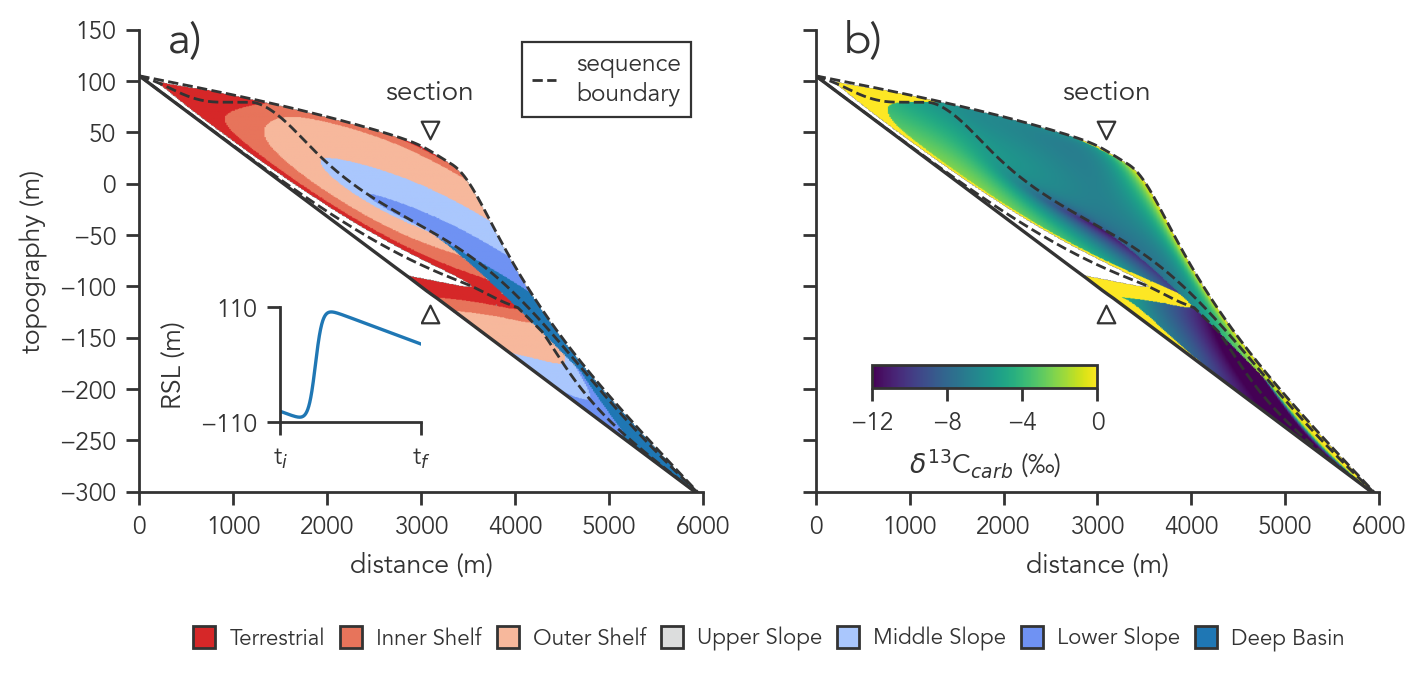

In [675]:
fig,ax = plt.subplots(1,2,figsize=(8,3),sharey=True)#,layout='constrained')

# facies
facies_data1 = np.where(o1b.facies_pred == 0, np.nan, o1b.facies_pred)
fim = ax[0].imshow(facies_data1,cmap=o1b.cmap,origin='lower',aspect='auto',extent=o1b.extent)

for i in range(2):
    ax[i].set_xlabel('distance (m)')

    # seqs
    ax[i].plot(o1b.x,o1b.beds[o1b.reg_idx,:].T,alpha=1,ls='--',color='.2',lw=1);
    ax[i].plot(o1b.x,o1b.beds_eroded[o1b.tran_idx,:].T,alpha=1,ls='--',color='.2',lw=1);
    ax[i].plot(o1b.x,o1b.beds_eroded[-1,:].T,alpha=1,ls='--',color='.2',lw=1,label='sequence\nboundary');
    ax[i].plot(o1b.x, o1b.beds[0], color='.2')

    # format basin ax
    ax[i].set_xlim(0,6000)
    ax[i].set_ylim(-300,150)
    ax[i].spines[['top','right']].set_visible(False)

ax[0].legend(loc=1,handlelength=1)


core_idx = 206 # chosen x-grid location for "drill core"
locs2 = o1b.Nx_toX(core_idx, out='grid')
for i in range(2):
    ax[i].scatter(x=locs2,y=o1b.beds_eroded[-1,core_idx]+20,marker='v',fc='w',ec='.2',s=40)
    ax[i].scatter(x=locs2,y=o1b.beds_eroded[0,core_idx]-20,marker='^',fc='w',ec='.2',s=40)
    ax[i].text(locs2,o1b.beds_eroded[-1,core_idx]+50,'section',ha='center',fontsize=10)

# isotopes
d13c1 = np.where(o1b.facies_pred == 0, np.nan, grid2)
cim = ax[1].imshow(d13c1,cmap='viridis',origin='lower',aspect='auto',extent=o1b.extent,vmin=-12)

# inset for d13c colorbar
axii = ax[1].inset_axes([0.1,0.225,0.4,0.05])
cb2 = plt.colorbar(cim,cax=axii,orientation='horizontal',label='$\\delta^{13}$C$_{carb}$ (‰)')
cb2.ax.set_xticks(np.linspace(-12,d_sw,4));

# inset for rsl
axi = ax[0].inset_axes([0.25,0.15,0.25,0.25])
axi.plot(o1b.rsl_strat)
axi.set_xticks([0,2000],['t$_i$','t$_f$'])
axi.set_xlim(0,2000)
axi.set_ylim(-110,110)
axi.set_yticks([-110,110])
axi.spines[['top','right']].set_visible(False)
axi.set_ylabel('RSL (m)')

# label a,b
labs = ['a)','b)']
for i,j in enumerate(labs):
    ax[i].text(0.05,0.95,j,transform=ax[i].transAxes,fontsize=16)

# label y
ax[0].set_ylabel('topography (m)')

# generate handles, including terrestrial here (supp fig)
elabs1 = [i['name'] for i in o1b.facies_data]#[1:] # skip terrestrial
colors1 = facies_colours#[1:] # skip terrestrial

legend_handles1 = [
    plt.Line2D([], [], marker='s', color='none', markerfacecolor=c, markeredgecolor='.2',
               markersize=8, label=l)
    for c, l in zip(colors1, elabs1)]

ax[1].legend(
    handles=legend_handles1,
    frameon=False,
    loc=1,
    bbox_to_anchor=(0.975, -0.25),
    ncols=len(elabs1),
    handlelength=0.75,
    handletextpad=0.75,
    columnspacing=0.8,
    fontsize=8)

# save
fig.savefig(tex_fig_dir + 'basin_sup.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)
#fig.savefig(diss_fig_dir + 'basin_sup.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

## Version of the above code combined into one large figure

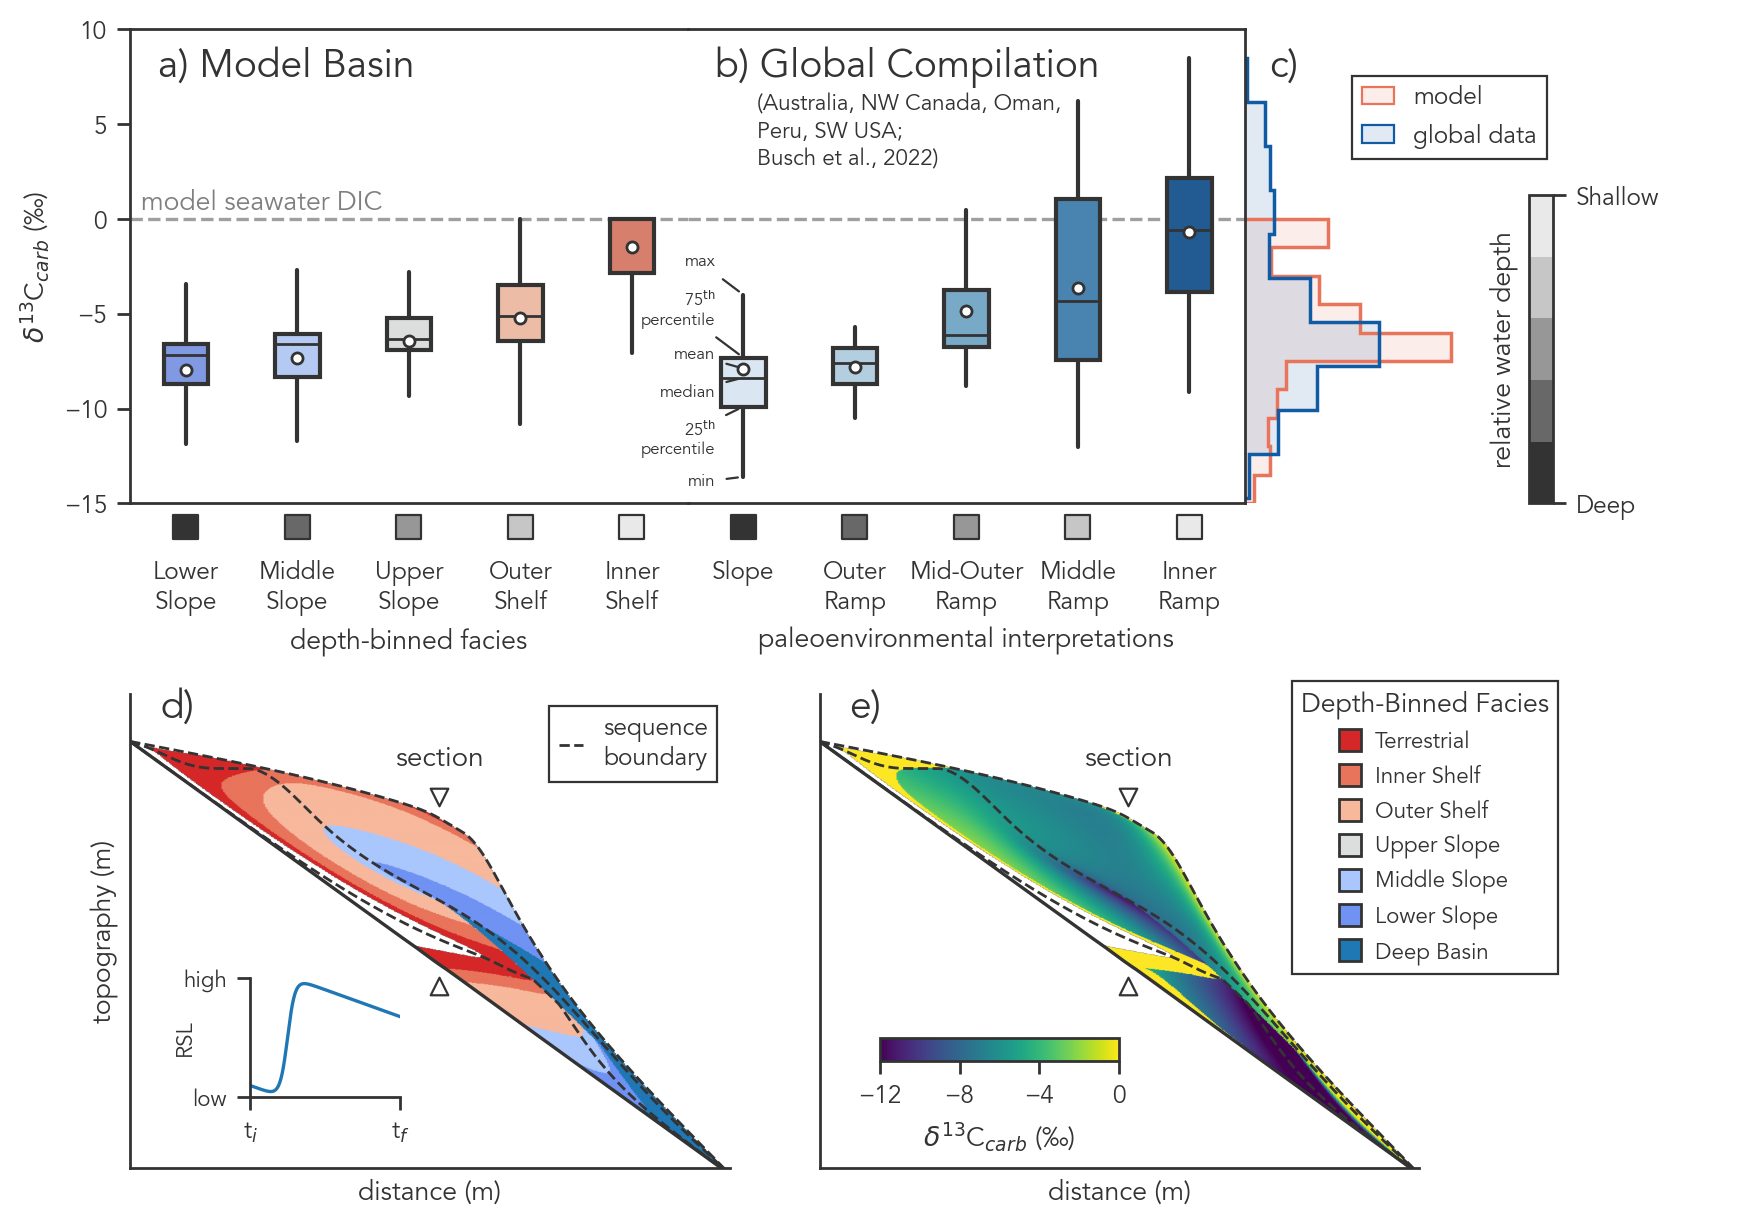

In [570]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from matplotlib.cbook import boxplot_stats

def shrink_ax(a, sx=0.9, sy=0.9):
    p = a.get_position()
    cx = p.x0 + p.width / 2
    cy = p.y0 + p.height / 2
    nw = p.width * sx
    nh = p.height * sy
    a.set_position([cx - nw / 2, cy - nh / 2, nw, nh])

def make_env_boxplots(subfig, o1b, grid2, busch, facies_colours, d_sw):
    # grab binned isotopes
    facies_w = o1b.get_facies_val(o1b.facies_pred, grid2)

    # get original order of facies
    facies_labels = list(facies_w.keys())

    # convert dictionary to long-format DataFrame
    df = pd.DataFrame(
        [(facies, val) for facies, values in facies_w.items() for val in values],
        columns=['dtype', 'd13c_carb']
    )

    # add line breaks to facies labels for nicer x-axis display
    df['dtype'] = df['dtype'].replace({
        'Deep Basin': 'Deep\nBasin',
        'Lower Slope': 'Lower\nSlope',
        'Middle Slope': 'Middle\nSlope',
        'Upper Slope': 'Upper\nSlope',
        'Outer Shelf': 'Outer\nShelf',
        'Inner Shelf': 'Inner\nShelf',
        'Terrestrial': 'Terrestrial'
    })

    # skip the first facies (e.g., 'terrestrial')
    skip_facies = ['Terrestrial', 'Deep\nBasin']
    df_filtered = df[~df['dtype'].isin(skip_facies)]
    order_filtered = [f for f in df['dtype'].unique() if f not in skip_facies][::-1]

    # compute means
    means = df_filtered.groupby('dtype')['d13c_carb'].mean().reindex(order_filtered)

    # delta matrix - find the mean differences in d13c between facies environments
    delta_matrix = np.zeros((len(order_filtered), len(order_filtered)))
    for i, f1 in enumerate(order_filtered):
        for j, f2 in enumerate(order_filtered):
            delta_matrix[i, j] = means[f1] - means[f2]

    # plot: boxplot and heatmap
    ax = subfig.subplots(1, 3, sharey=False, width_ratios=[1, 1, 0.85])

    # boxplot on ax[0]
    sc = sns.boxplot(
        x='dtype', y='d13c_carb', data=df_filtered, order=order_filtered, ax=ax[0],
        hue='dtype', palette='coolwarm_r', showfliers=False,
        capprops=dict(linewidth=0, alpha=1),
        boxprops=dict(alpha=1, linewidth=1.5, edgecolor='.2'),
        width=0.4,
        showmeans=True,
        meanprops=dict(marker='o', markerfacecolor='w', alpha=1, mec='.2', markersize=4),
        whiskerprops=dict(linewidth=1.5, solid_capstyle='round', color='.2'),
        medianprops=dict(color='.2', linewidth=1, alpha=1)
    )

    ax[0].set_xlabel(None)
    ax[0].set_ylabel('$\\delta^{13}$C$_{carb}$ (‰)')

    # Busch data
    b_order = ['Slope', 'Outer\nRamp', 'Mid-Outer\nRamp', 'Middle\nRamp', 'Inner\nRamp']
    sns.boxplot(
        x='environment', y='d13C', data=busch, order=b_order, ax=ax[1],
        hue='environment', palette='Blues', showfliers=False, hue_order=b_order,
        capprops=dict(linewidth=0, alpha=1),
        boxprops=dict(alpha=1, linewidth=1.5, edgecolor='.2'),
        width=0.4,
        showmeans=True,
        meanprops=dict(marker='o', markerfacecolor='w', alpha=1, mec='.2', markersize=4),
        whiskerprops=dict(linewidth=1.5, solid_capstyle='round', color='.2'),
        medianprops=dict(color='.2', linewidth=1, alpha=1)
    )
    ax[1].set_xlabel(None)

    # label a b c
    labs = ['a) Model Basin', 'b) Global Compilation', 'c)']
    for i, l in enumerate(labs):
        ax[i].text(0.05, 0.9, l, transform=ax[i].transAxes, fontsize=14)

    # label busch
    ax[1].text(
        0.125, 0.7125,
        '(Australia, NW Canada, Oman,\nPeru, SW USA;\nBusch et al., 2022)',
        transform=ax[1].transAxes,
        fontsize=8
    )

    # format
    ax[1].tick_params(axis='both', length=0)
    ax[0].tick_params(axis='x', length=0)

    subfig.subplots_adjust(wspace=0)
    ax[0].spines[['right']].set_visible(False)
    ax[1].spines[['left']].set_visible(False)
    ax[0].set_yticks(np.linspace(-15, 10, 6))

    # label relative depths
    rel_d = np.linspace(0, 1, 5)
    xd = np.arange(0, len(rel_d), 1)
    yd = np.ones(len(rel_d)) * 0.5

    rmap = 'Greys_r'
    rmap = sns.color_palette(rmap, n_colors=len(rel_d))
    rmap = ListedColormap(rmap)

    ax1 = ax[0].inset_axes([0, -0.1, 1, 0.1])
    sc1 = ax1.scatter(x=xd, y=yd, c=rel_d, marker='s', cmap=rmap, edgecolor='.2', s=80)
    ax1.sharex(ax[0])
    ax1.set_yticks([])
    ax1.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    ax1.set_facecolor('none')
    ax1.tick_params(axis='x', length=0, labelbottom=True)
    ax1.set_xlabel('depth-binned facies')

    ax2 = ax[1].inset_axes([0, -0.1, 1, 0.1])
    sc2 = ax2.scatter(x=xd, y=yd, c=rel_d, marker='s', cmap=rmap, edgecolor='.2', s=80)
    ax2.sharex(ax[1])
    ax2.sharey(ax1)
    ax2.set_yticks([])
    ax2.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    ax2.set_facecolor('none')
    ax2.tick_params(axis='x', length=0, labelbottom=True)
    ax2.set_xlabel('paleoenvironmental interpretations')

    # format
    ax[0].tick_params(labelbottom=False)
    ax[1].tick_params(labelbottom=False)

    # modify to not add dummy inset
    axi = ax[1]
    axi.sharex(ax[0])

    var = busch['d13C'][busch['environment'] == 'Slope']
    var = var[~np.isnan(var)]

    sns.boxplot(
        y=var, ax=axi,
        showfliers=False,
        capprops=dict(linewidth=0, alpha=0),
        boxprops=dict(alpha=0, linewidth=1.5, edgecolor='.2'),
        width=0.4,
        showmeans=True,
        meanprops=dict(marker='o', markerfacecolor='w', alpha=1, mec='.2', markersize=0),
        whiskerprops=dict(linewidth=1.5, solid_capstyle='round', color='.2', alpha=0),
        medianprops=dict(color='.2', linewidth=1, alpha=0)
    )

    q1, med, q3 = np.percentile(var, [25, 50, 75])
    mean_val = np.mean(var)

    stats = boxplot_stats(var)[0]
    min_val = stats['whislo']
    max_val = stats['whishi']

    bmin = -0.25
    axi.annotate('max', xy=(0, max_val), xytext=(bmin, max_val + 1.5), ha='right',
                 textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
    axi.annotate('75$^{\\mathrm{th}}$\npercentile', xy=(0, q3), xytext=(bmin, q3 + 1.75), ha='right',
                 textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
    axi.annotate('mean', xy=(0, mean_val), xytext=(bmin, mean_val + 0.5), ha='right',
                 textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
    axi.annotate('median', xy=(0, med), xytext=(bmin, med - 1), ha='right',
                 textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
    axi.annotate('25$^{\\mathrm{th}}$\npercentile', xy=(0, q1), xytext=(bmin, q1 - 2.5), ha='right',
                 textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
    axi.annotate('min', xy=(0, min_val), xytext=(bmin, min_val - 0.5), ha='right',
                 textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))

    axi.set_facecolor('none')

    # format
    ax[1].sharey(ax[0])
    ax[1].tick_params(labelleft=False)
    ax[1].set_ylabel(None)

    # histograms for ranges of d13c
    mod_col = sns.color_palette('coolwarm_r', n_colors=5).as_hex()[0]
    dat_col = sns.color_palette('Blues', n_colors=5).as_hex()[-1]

    var = o1b.facies_pred
    var = np.where((var == 0) | (var == 6), np.nan, var)
    var1 = np.where(np.isnan(var), np.nan, grid2)

    ax[2].hist(var1.ravel(), orientation='horizontal', histtype='step', color=mod_col, fill=True,
               edgecolor='.2', linewidth=0, density=True, alpha=0.125)
    ax[2].hist(busch['d13C'], orientation='horizontal', histtype='step', color=dat_col, fill=True,
               edgecolor='.2', linewidth=0, density=True, alpha=0.125)

    ax[2].hist(var1.ravel(), orientation='horizontal', histtype='step', edgecolor=mod_col, fill=False,
               linewidth=1.25, density=True, alpha=1)
    ax[2].hist(busch['d13C'], orientation='horizontal', histtype='step', edgecolor=dat_col, fill=False,
               linewidth=1.25, density=True, alpha=1)

    # format
    ax[2].set_ylabel(None)
    ax[2].set_xlim(right=0.5)
    ax[2].spines[['right', 'left', 'top', 'bottom']].set_visible(False)
    ax[2].tick_params(axis='y', direction='out', length=0, labelleft=False)
    ax[2].set_zorder(0)
    ax[2].sharey(ax[0])
    ax[1].set_zorder(10000)
    ax[2].set_xticks([])

    # create custom legend handles
    def rgba(color, alpha):
        return mcolors.to_rgba(color, alpha=alpha)

    legend_handles = [
        patches.Patch(facecolor=rgba(mod_col, 0.125), edgecolor=rgba(mod_col, 1.0), label='model'),
        patches.Patch(facecolor=rgba(dat_col, 0.125), edgecolor=rgba(dat_col, 1.0), label='global data')
    ]

    ax[2].legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(0.2, 0.7),
                 frameon=True, handlelength=1.3)

    # label seawater dic
    vals = [d_sw]
    for i in range(2):
        for v in vals:
            ax[i].axhline(v, ls='--', color='tab:grey', zorder=0, alpha=0.75)

    ax[0].text(-0.4, vals[0] + 0.5, 'model seawater DIC', color='tab:grey')

    # colorbar for relative depths
    axii = ax[2].inset_axes([0.6, 0, 0.05, 0.65])
    cb2 = plt.colorbar(sc2, cax=axii)
    cb2.ax.set_yticks([0, 1], ['Deep', 'Shallow'])
    cb2.set_label('relative water depth')
    cb2.ax.yaxis.set_label_position('left')

    return ax


def make_basin_panels(subfig, o1b, grid2, facies_colours, d_sw):
    # real, pad, real, pad
    axb = subfig.subplots(
        1, 5,
        sharey=True,
        width_ratios=[0,1, 0.15, 1, 0.5] #0.92
    )

    # turn off dummy pad axes
    axb[0].axis('off')
    axb[2].axis('off')
    axb[4].axis('off')

    # alias the real axes to match your original ax[0], ax[1] usage
    ax0 = axb[1]
    ax1 = axb[3]

    # facies
    facies_data1 = np.where(o1b.facies_pred == 0, np.nan, o1b.facies_pred)
    ax0.imshow(facies_data1, cmap=o1b.cmap, origin='lower', aspect='auto', extent=o1b.extent)

    for a in [ax0, ax1]:
        a.set_xlabel('distance (m)')

        # seqs
        a.plot(o1b.x, o1b.beds[o1b.reg_idx, :].T, alpha=1, ls='--', color='.2', lw=1)
        a.plot(o1b.x, o1b.beds_eroded[o1b.tran_idx, :].T, alpha=1, ls='--', color='.2', lw=1)
        a.plot(o1b.x, o1b.beds_eroded[-1, :].T, alpha=1, ls='--', color='.2', lw=1, label='sequence\nboundary')
        a.plot(o1b.x, o1b.beds[0], color='.2')

        # format basin ax
        a.set_xlim(0, 6000)
        a.set_ylim(-300, 150)
        a.spines[['top', 'right']].set_visible(False)

    ax0.legend(loc=1, handlelength=1)

    core_idx = 206
    locs2 = o1b.Nx_toX(core_idx, out='grid')
    for a in [ax0, ax1]:
        a.scatter(x=locs2, y=o1b.beds_eroded[-1, core_idx] + 20, marker='v', fc='w', ec='.2', s=40)
        a.scatter(x=locs2, y=o1b.beds_eroded[0, core_idx] - 20, marker='^', fc='w', ec='.2', s=40)
        a.text(locs2, o1b.beds_eroded[-1, core_idx] + 50, 'section', ha='center', fontsize=10)

    # isotopes
    d13c1 = np.where(o1b.facies_pred == 0, np.nan, grid2)
    cim = ax1.imshow(d13c1, cmap='viridis', origin='lower', aspect='auto', extent=o1b.extent, vmin=-12)

    # inset for d13c colorbar
    axii = ax1.inset_axes([0.1, 0.225, 0.4, 0.05])
    cb2 = plt.colorbar(cim, cax=axii, orientation='horizontal', label='$\\delta^{13}$C$_{carb}$ (‰)')
    cb2.ax.set_xticks(np.linspace(-12, d_sw, 4))

    # inset for rsl
    axi = ax0.inset_axes([0.2, 0.15, 0.25, 0.25])
    axi.plot(o1b.rsl_strat)
    axi.set_xticks([0, 2000], ['t$_i$', 't$_f$'])
    axi.set_xlim(0, 2000)
    axi.set_ylim(-110, 110)
    axi.set_yticks([-110, 110], ['low', 'high'],fontsize=8)
    axi.spines[['top', 'right']].set_visible(False)
    axi.set_ylabel('RSL',labelpad=-5,fontsize=8)

    # label a,b
    ax0.text(0.05, 0.95, 'd)', transform=ax0.transAxes, fontsize=14)
    ax1.text(0.05, 0.95, 'e)', transform=ax1.transAxes, fontsize=14)

    # label y
    ax0.set_ylabel('topography (m)')

    # facies legend anchored to ax1 (the second real basin panel)
    elabs1 = [i['name'] for i in o1b.facies_data]
    colors1 = facies_colours

    legend_handles1 = [
        plt.Line2D([], [], marker='s', color='none', markerfacecolor=c, markeredgecolor='.2',
                   markersize=8, label=l)
        for c, l in zip(colors1, elabs1)
    ]

    ax1.legend(
        title='Depth-Binned Facies',
        handles=legend_handles1,
        frameon=True,
        loc=1,
        bbox_to_anchor=(1.25, 1.05),
        ncols=1,
        handlelength=0.75,
        handletextpad=0.75,
        columnspacing=0.8,
        fontsize=8
    )

    # optional: hide y tick labels on the second real axis (like your original)
    ax1.tick_params(labelleft=False)

    # shrink the two basin panels within the bottom subfigure
    # shrink_ax(ax0, sx=0.88, sy=0.82)
    # shrink_ax(ax1, sx=0.88, sy=0.82)
    ax0.set_yticks([])
    ax0.set_xticks([])
    ax1.set_xticks([])
    # ax0.set_xlim(left=1000)
    # ax1.set_xlim(left=1000)

    return axb


# ---- compose the stacked figure ----
fig = plt.figure(figsize=(10.25, 6.4), constrained_layout=False)

subfigs = fig.subfigures(
    2, 1,
    height_ratios=[1, 1],
    hspace=0.08 # 0.08
)

ax_top = make_env_boxplots(subfigs[0], o1b=o1b, grid2=grid2, busch=busch, facies_colours=facies_colours, d_sw=d_sw)
ax_bot = make_basin_panels(subfigs[1], o1b=o1b, grid2=grid2, facies_colours=facies_colours, d_sw=d_sw)

fig.savefig(tex_fig_dir + 'spatial_comp.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

## Remaking above figure

In [585]:
# fix,ax = plt.subplot_mosaic(
#     """
#     aabbc
#     aabbc
#     .efg.
#     """,figsize=(10.25,6.4))

# plt.subplots_adjust(wspace=0)

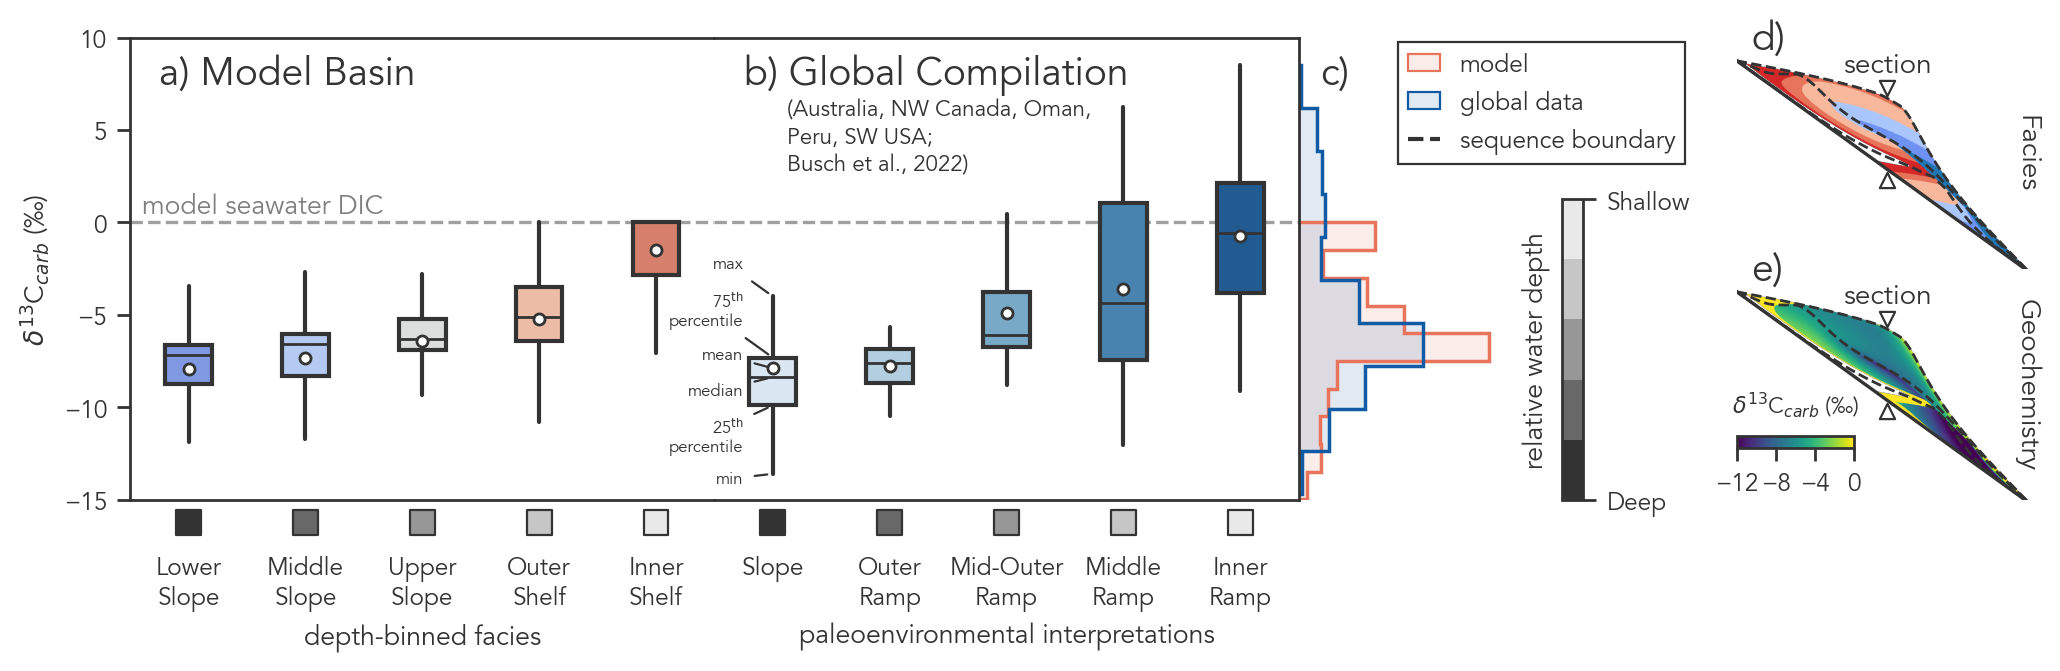

In [691]:
fig,ax = plt.subplot_mosaic(
    """
    abcd
    abce
    """,figsize=(12.25,3),width_ratios=[1,1,.75,0.5])

# boxplot on ax['a']
sns.boxplot(x='dtype', y='d13c_carb', data=df_filtered, order=order_filtered, ax=ax['a'],
            hue='dtype', palette='coolwarm_r', showfliers=False,
            capprops=dict(linewidth=0, alpha=1),
            boxprops=dict(alpha=1, linewidth=1.5, edgecolor='.2'),
            width=0.4,
            showmeans=True,
            meanprops=dict(marker='o', markerfacecolor='w', alpha=1, mec='.2', markersize=4),
            whiskerprops=dict(linewidth=1.5, solid_capstyle='round', color='.2'),
            medianprops=dict(color='.2', linewidth=1, alpha=1))

ax['a'].set_xlabel(None)
ax['a'].set_ylabel('$\\delta^{13}$C$_{carb}$ (‰)')

plt.subplots_adjust(wspace=0,hspace=0)

# Busch data
b_order = ['Slope','Outer\nRamp','Mid-Outer\nRamp','Middle\nRamp','Inner\nRamp']
sns.boxplot(x='environment', y='d13C', data=busch,order=b_order,ax=ax['b'],
            hue='environment', palette='Blues', showfliers=False,hue_order=b_order,
            capprops=dict(linewidth=0, alpha=1),
            boxprops=dict(alpha=1, linewidth=1.5, edgecolor='.2'),
            width=0.4,
            showmeans=True,
            meanprops=dict(marker='o', markerfacecolor='w', alpha=1, mec='.2', markersize=4),
            whiskerprops=dict(linewidth=1.5, solid_capstyle='round', color='.2'),
            medianprops=dict(color='.2', linewidth=1, alpha=1))
ax['b'].set_xlabel(None)

# label ab
labs = ['a) Model Basin','b) Global Compilation', 'c)']
for i,l in zip(['a','b','c'],labs):
    ax[i].text(0.05, 0.9, l, transform=ax[i].transAxes, fontsize=14)
    #ax[i].yaxis.grid(ls='-',zorder=0)

# label busch
ax['b'].text(0.125, 0.7125, '(Australia, NW Canada, Oman,\nPeru, SW USA;\nBusch et al., 2022)', transform=ax['b'].transAxes, fontsize=8) # 0.825
#ax['b'].text(0.125, 0.725, '(Busch et al., 2022)', transform=ax['b'].transAxes, fontsize=8) # 0.825
    
# format
ax['b'].tick_params(axis='both',length=0)
ax['a'].tick_params(axis='x',length=0)

plt.subplots_adjust(wspace=0)
ax['a'].spines[['right']].set_visible(False)
ax['b'].spines[['left']].set_visible(False)
ax['a'].set_yticks(np.linspace(-15,10,6));

# label relative depths
rel_d = np.linspace(0,1,5)
xd = np.arange(0,len(rel_d),1)
yd = np.ones(len(rel_d))*0.5
rmap = 'Greys_r'
rmap = sns.color_palette(rmap,n_colors=len(rel_d))
rmap = ListedColormap(rmap)

ax1 = ax['a'].inset_axes([0,-0.1,1,.1])
sc1 = ax1.scatter(x=xd,y=yd,c=rel_d,marker='s',cmap=rmap,edgecolor='.2',s=80)
ax1.sharex(ax['a'])
ax1.set_yticks([])
#ax1.axis('off')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_facecolor('none')
ax1.tick_params(axis='x',length=0,labelbottom=True)
ax1.set_xlabel('depth-binned facies')

ax2 = ax['b'].inset_axes([0,-0.1,1,.1])
sc2 = ax2.scatter(x=xd,y=yd,c=rel_d,marker='s',cmap=rmap,edgecolor='.2',s=80)
ax2.sharex(ax['b'])
ax2.sharey(ax1)
ax2.set_yticks([])
#ax2.axis('off')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_facecolor('none')
ax2.tick_params(axis='x',length=0,labelbottom=True)
ax2.set_xlabel('paleoenvironmental interpretations')

# format
ax['a'].tick_params(labelbottom=False)
ax['b'].tick_params(labelbottom=False)

# modify to not add dummy inset
axi = ax['b']#.twiny()
axi.sharex(ax['a'])

var = busch['d13C'][busch['environment']=='Slope']
var = var[~np.isnan(var)]
sns.boxplot(y=var,ax=axi,
            showfliers=False,
            capprops=dict(linewidth=0, alpha=0),
            boxprops=dict(alpha=0, linewidth=1.5, edgecolor='.2'),
            width=0.4,
            showmeans=True,
            meanprops=dict(marker='o', markerfacecolor='w', alpha=1, mec='.2', markersize=0),
            whiskerprops=dict(linewidth=1.5, solid_capstyle='round', color='.2',alpha=0),
            medianprops=dict(color='.2', linewidth=1, alpha=0))

q1, med, q3 = np.percentile(var, [25, 50, 75])
mean_val = np.mean(var)

# get whisker stats (handles outliers properly)
stats = boxplot_stats(var)[0]
min_val = stats['whislo']   # lower whisker
max_val = stats['whishi']   # upper whisker

bmin = -0.25 #-0.5
axi.annotate('max', xy=(0, max_val), xytext=(bmin, max_val + 1.5),ha='right',
             textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
axi.annotate('75$^{\\mathrm{th}}$\npercentile', xy=(0, q3), xytext=(bmin, q3 + 1.75),ha='right',
             textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
axi.annotate('mean', xy=(0, mean_val), xytext=(bmin, mean_val + .5),ha='right',
             textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
axi.annotate('median', xy=(0, med), xytext=(bmin, med - 1),ha='right',
             textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
axi.annotate('25$^{\\mathrm{th}}$\npercentile', xy=(0, q1), xytext=(bmin, q1 - 2.5),ha='right',
             textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))
axi.annotate('min', xy=(0, min_val), xytext=(bmin, min_val - 0.5),ha='right',
             textcoords='data', fontsize=6, arrowprops=dict(arrowstyle='-', color='.2'))

axi.set_facecolor('none')

# format
ax['b'].sharey(ax['a'])
ax['b'].tick_params(labelleft=False)
ax['b'].set_ylabel(None)

# histograms for ranges of d13c
mod_col = col = sns.color_palette('coolwarm_r',n_colors=5).as_hex()[0]
dat_col = sns.color_palette('Blues',n_colors=5).as_hex()[-1]
var = o1b.facies_pred
var = np.where((var==0)|(var==6),np.nan,var) # isolate to only the environments we compare to busch (excl terrestrial and deep basin)
var1 = np.where(np.isnan(var),np.nan,grid2)
# plot fills
ax['c'].hist(var1.ravel(),orientation='horizontal',histtype='step',color=mod_col,fill=True,edgecolor='.2',linewidth=0,density=True,alpha=0.125)
ax['c'].hist(busch['d13C'],orientation='horizontal',histtype='step',color=dat_col,fill=True,edgecolor='.2',linewidth=0,density=True,alpha=0.125)
# plot lines
ax['c'].hist(var1.ravel(),orientation='horizontal',histtype='step',edgecolor=mod_col,fill=False,linewidth=1.25,density=True,alpha=1)
ax['c'].hist(busch['d13C'],orientation='horizontal',histtype='step',edgecolor=dat_col,fill=False,linewidth=1.25,density=True,alpha=1)

# format
ax['c'].set_ylabel(None)
ax['c'].set_xlim(right=0.5)
ax['c'].spines[['right','left','top','bottom']].set_visible(False)
ax['c'].tick_params(axis='y',direction='out',length=0,labelleft=False)
ax['c'].set_zorder(0)
ax['c'].sharey(ax['a'])
ax['b'].set_zorder(10000)
ax['c'].set_xticks([])

# label sequence boundaries
def rgba(color, alpha):
    return mcolors.to_rgba(color, alpha=alpha)

legend_handles = [
    patches.Patch(
        facecolor=rgba(mod_col, 0.125),      # semi-transparent fill
        edgecolor=rgba(mod_col, 1.0),      # fully opaque edge
        label='model'
    ),
    patches.Patch(
        facecolor=rgba(dat_col, 0.125),
        edgecolor=rgba(dat_col, 1),
        label='global data'
    ),
     Line2D(
        [0], [0],
        color='0.2',
        lw=1.5,
        ls='--',
        label='sequence boundary'
    )]

ax['c'].legend(handles=legend_handles, loc='lower left',bbox_to_anchor=(.2,0.7),
             frameon=True,handlelength=1.3)


# label seawater dic
vals = [d_sw]#,-12]
for i in ['a','b']:
    for v in vals:
        ax[i].axhline(v,ls='--',color='tab:grey',zorder=0,alpha=0.75)
        
ax['a'].text(-0.4,vals[0] + 0.5,'model seawater DIC',color='tab:grey')

# colorbar for facies
axii = ax['c'].inset_axes([0.6,0,0.05,0.65])

# colorbar for relative depths
cb2 = plt.colorbar(sc2,cax=axii)
cb2.ax.set_yticks([0,1],['Deep','Shallow'])
cb2.set_label('relative water depth')
cb2.ax.yaxis.set_label_position('left')

# basins

# facies
facies_data1 = np.where(o1b.facies_pred == 0, np.nan, o1b.facies_pred)
fim = ax['d'].imshow(facies_data1,cmap=o1b.cmap,origin='lower',aspect='auto',extent=o1b.extent)

for i in ['d','e']:
    #ax[i].set_xlabel('distance (m)')

    # seqs
    ax[i].plot(o1b.x,o1b.beds[o1b.reg_idx,:].T,alpha=1,ls='--',color='.2',lw=1);
    ax[i].plot(o1b.x,o1b.beds_eroded[o1b.tran_idx,:].T,alpha=1,ls='--',color='.2',lw=1);
    ax[i].plot(o1b.x,o1b.beds_eroded[-1,:].T,alpha=1,ls='--',color='.2',lw=1,label='sequence\nboundary');
    ax[i].plot(o1b.x, o1b.beds[0], color='.2')

    # format basin ax
    ax[i].set_xlim(0,6000)
    ax[i].set_ylim(-300,150)
    ax[i].spines[['top']].set_visible(False)

#ax['d'].legend(loc=1,handlelength=1,bbox_to_anchor=(0.2,.8))


core_idx = 206 # chosen x-grid location for "drill core"
locs2 = o1b.Nx_toX(core_idx, out='grid')
for i in ['d','e']:
    ax[i].scatter(x=locs2,y=o1b.beds_eroded[-1,core_idx]+20,marker='v',fc='w',ec='.2',s=30)
    ax[i].scatter(x=locs2,y=o1b.beds_eroded[0,core_idx]-20,marker='^',fc='w',ec='.2',s=30)
    ax[i].text(locs2,o1b.beds_eroded[-1,core_idx]+50,'section',ha='center',fontsize=10)

# isotopes
d13c1 = np.where(o1b.facies_pred == 0, np.nan, grid2)
cim = ax['e'].imshow(d13c1,cmap='viridis',origin='lower',aspect='auto',extent=o1b.extent,vmin=-12)

# inset for d13c colorbar
axii = ax['e'].inset_axes([0,0.225,0.4,0.05])
cb2 = plt.colorbar(cim,cax=axii,orientation='horizontal')
cb2.ax.set_xticks(np.linspace(-12,d_sw,4))
cb2.ax.set_xlabel('$\\delta^{13}$C$_{carb}$ (‰)',fontsize=8)
cb2.ax.xaxis.set_label_coords(0.5, 5)

# inset for rsl
# axi = ax['d'].inset_axes([0.25,0.15,0.25,0.25])
# axi.plot(o1b.rsl_strat)
# axi.set_xticks([0,2000],['t$_i$','t$_f$'])
# axi.set_xlim(0,2000)
# axi.set_ylim(-110,110)
# axi.set_yticks([-110,110])
# axi.spines[['top','right']].set_visible(False)
# axi.set_ylabel('RSL (m)')

# label a,b
labs = ['d)','e)']
for i,j in zip(['d','e'],labs):
    ax[i].text(0.05,0.95,j,transform=ax[i].transAxes,fontsize=14)

# label y
# ax['d'].set_ylabel('topography (m)')
# ax['e'].set_ylabel('topography (m)')
ax['d'].set_ylabel('Facies',rotation=270,fontsize=10)
ax['e'].set_ylabel('Geochemistry',rotation=270,fontsize=10)


# clean
ax['d'].set_xticks([])
ax['e'].set_xticks([])
ax['d'].set_yticks([])
ax['e'].set_yticks([])
#ax['d'].spines[['bottom']].set_visible(False)
ax['d'].yaxis.tick_right()
ax['d'].yaxis.set_label_position('right')
ax['d'].spines[['left','bottom','right']].set_visible(False)
ax['d'].tick_params(axis='y', left=False)
ax['e'].yaxis.tick_right()
ax['e'].yaxis.set_label_position('right')
ax['e'].spines[['left','right','bottom']].set_visible(False)
ax['e'].tick_params(axis='y', left=False)

# save
fig.savefig(tex_fig_dir + 'spatial_comp2.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=False)
#fig.savefig(diss_fig_dir + 'basin_sup.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

## Huqf Comparison

In [34]:
huqf = pd.read_excel(data_dir + 'Huqf/Fike_2006.xls')
huqf.head()

Unit        Lithology  Depth (m)  d13c_carb  d18o_carb   d13c_org  \
0  Buah  silty dolostone       3200   2.416857  -1.799543 -26.762000   
1  Buah  silty dolostone       3202   2.679235  -1.987958        NaN   
2  Buah  silty dolostone       3204   3.323006  -1.475678 -26.616294   
3  Buah  silty dolostone       3206   4.796145  -1.248721 -26.210816   
4  Buah  silty dolostone       3208   4.667006  -1.237679 -26.696886   

     δ34SSO4    δ34Spyr      Δδ34S  TOC (wt%)  Pyrite (wt%)   [SO4]     Mn/Sr  \
0  24.741797 -25.532431  50.274227        NaN           NaN   860.0  0.423488   
1  25.792399        NaN        NaN    0.10015      0.034443     NaN  0.395199   
2  26.233228 -18.777120  45.010349        NaN           NaN  1800.0       NaN   
3  26.188508 -24.108774  50.297282        NaN           NaN   430.0       NaN   
4  26.006517 -24.101590  50.108106        NaN           NaN   830.0       NaN   

   Mn (ppm)  Sr (ppm)  Fe (wt%)  
0   254.563   601.110     0.808  
1   209.336   529.698     0.518  
2       NaN       NaN       NaN  
3       NaN       NaN       NaN  
4       NaN       NaN       NaN

In [35]:
# isolate columns
h_d13c = huqf['d13c_carb']
h_d18o = huqf['d18o_carb']
h_d13c_org = huqf['d13c_org']
h_toc = huqf['TOC (wt%)']
h_depth = huqf['Depth (m)']
h_lith = huqf['Lithology']
h_unit = huqf['Unit']

In [36]:
set(h_lith)

{'calcareous shale',
 'dolomaceous shale',
 'dolostone',
 'limestone',
 'limestone/sandstone',
 'silty dolostone',
 'silty limestone'}

### Huqf Stratigraphy

In [37]:
def init_lith_styles(lithology_series, width_range=(0.2, 0.8), palette='Set3'):
    """
    Initializes a dictionary of lithology styles from a pandas Series.

    Parameters
    ----------
    lithology_series : pd.Series
        Column containing lithology names (strings).
    width_range : tuple
        Min and max width for bar plotting (between 0 and 1).
    palette : str
        Seaborn or matplotlib-compatible colormap name.

    Returns
    -------
    lith_styles : dict
        Dictionary mapping each lithology to a width and color.
    """
    unique_liths = lithology_series.dropna().unique()
    n = len(unique_liths)
    widths = np.linspace(width_range[0], width_range[1], n)
    colors = sns.color_palette(palette, n)

    lith_styles = {
        lith: {'width': w, 'color': c}
        for lith, w, c in zip(unique_liths, widths, colors)
    }

    return lith_styles

def plot_strat_column(ax, depths, liths, lith_styles, bar_edgecolor='k',xspine=False):
    """
    Plot a stratigraphic column on a provided axis with grouped lithologies.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Matplotlib axis object to plot into.
    depths : array-like
        Depth values (positive down, increasing).
    liths : array-like
        Lithology labels (same length as depths).
    lith_styles : dict
        Dictionary with keys as lithology names and values as {'color': ..., 'width': ...}.
    bar_edgecolor : str
        Color of the rectangle borders (default 'k').
    """
    depths = np.asarray(depths)
    liths = np.asarray(liths)
    ax0 = plt.gca() if not ax else ax
    
    # group by consecutive lithologies
    grouped = []
    start = 0
    for i in range(1, len(liths)):
        if liths[i] != liths[i - 1]:
            grouped.append((start, i - 1, liths[i - 1]))
            start = i
    grouped.append((start, len(liths) - 1, liths[-1]))  # final group

    # plot each group as one rectangle
    for start_idx, end_idx, lith in grouped:
        if lith not in lith_styles:
            continue
        top = depths[start_idx]
        base = depths[end_idx + 1] if end_idx + 1 < len(depths) else depths[end_idx]
        width = lith_styles[lith]['width']
        color = lith_styles[lith]['color']
        ax0.barh(
            y=(top + base) / 2,
            width=width,
            height=abs(base - top),
            left=0,
            color=color,
            edgecolor=bar_edgecolor
        )

    #ax0.set_xlim(0, 1)
    ax0.set_xticks([])
    if not xspine:
        ax0.spines[['top','bottom','right']].set_visible(False)
    else:
        ax0.spines[['top','right']].set_visible(False)


In [38]:
lith_styles = init_lith_styles(h_lith,palette='BrBG')
print(lith_styles.keys())
print(len(lith_styles))
lith_styles

dict_keys(['silty dolostone', 'dolostone', 'silty limestone', 'calcareous shale', 'limestone/sandstone', 'limestone', 'dolomaceous shale'])
7


{'silty dolostone': {'width': np.float64(0.2),
  'color': (0.6000000000000001, 0.3656286043829296, 0.07420222991157246)},
 'dolostone': {'width': np.float64(0.30000000000000004),
  'color': (0.8129950019223375, 0.635832372164552, 0.33640907343329485)},
 'silty limestone': {'width': np.float64(0.4),
  'color': (0.9434832756632064, 0.8747404844290657, 0.7001153402537484)},
 'calcareous shale': {'width': np.float64(0.5),
  'color': (0.9572472126105345, 0.9599384851980008, 0.9595540176855056)},
 'limestone/sandstone': {'width': np.float64(0.6000000000000001),
  'color': (0.7039600153787008, 0.8864282968089198, 0.8592848904267592)},
 'limestone': {'width': np.float64(0.7000000000000002),
  'color': (0.346251441753172, 0.6918108419838525, 0.653056516724337)},
 'dolomaceous shale': {'width': np.float64(0.8),
  'color': (0.0479046520569012, 0.44144559784698195, 0.4100730488273741)}}

In [39]:
# define palettes
brbg = sns.color_palette('BrBG', 11)
tans = brbg[:5][::-1]      # deeper blues first
blues = brbg[6:]             # tan/brown tones
greys = sns.color_palette('Greys', 6)[2:]  # skip very light greys

# change widths
lith_styles['limestone/sandstone']['width'] = 0.8
lith_styles['silty dolostone']['width'] = 0.5
lith_styles['silty limestone']['width'] = 0.5
lith_styles['limestone']['width'] = 0.3
lith_styles['dolostone']['width'] = 0.3
lith_styles['dolomaceous shale']['width'] = 0.2
lith_styles['calcareous shale']['width'] = 0.2

# assign colors
# limestones
lith_styles['limestone/sandstone']['color'] = greys[2]  # override with grey due to 'sdstone'
lith_styles['silty limestone']['color'] = blues[1]
lith_styles['limestone']['color'] = blues[2]

# dolostones
lith_styles['silty dolostone']['color'] = tans[0]
lith_styles['dolostone']['color'] = tans[1]

# shales
lith_styles['dolomaceous shale']['color'] = greys[0]
lith_styles['calcareous shale']['color'] = greys[1]

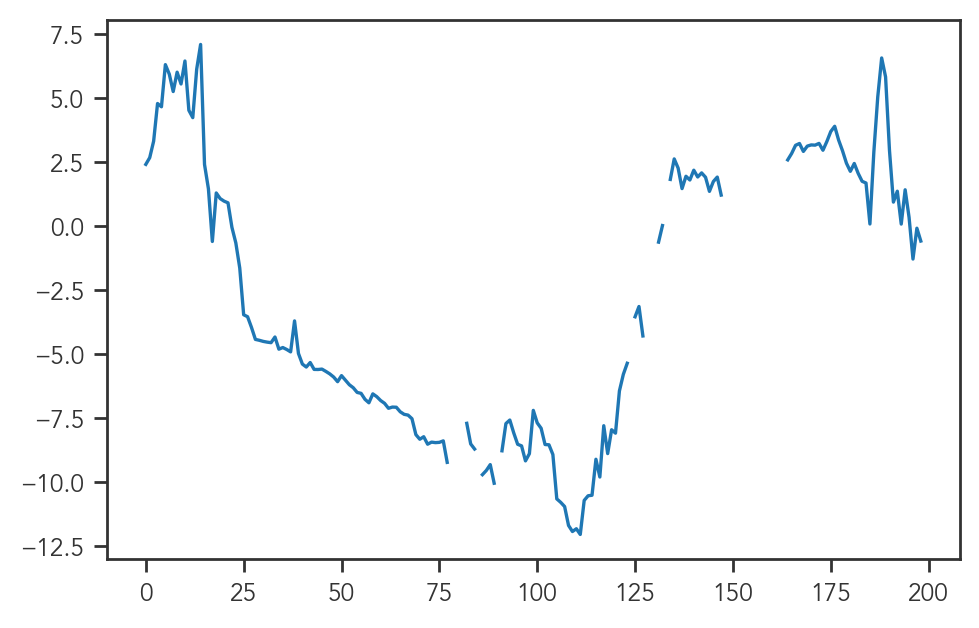

In [40]:
plt.plot(h_d13c)

In [41]:
@interact(idx=(1,399,1))
def f(idx):
    fig,ax = plt.subplots(1,5,figsize=(5,3),sharey=True,layout='constrained')
    #[ax[i].grid(ls='-',zorder=0) for i in range(4)]
    ax[0].set_ylabel('core depth (m)') 
    #ax[0].set_ylim(3300,4000)
    ax[0].set_ylim(3200,4250)
    ax[0].invert_yaxis()

    # strat
    plot_strat_column(ax[0], h_depth, h_lith, lith_styles)
    ax[0].set_title('Huqf strat')
    
    # d13c carb
    ax[1].scatter(x=h_d13c,y=h_depth,zorder=1000,ec='none',fc='tab:blue',marker='o',s=20)
    ax[1].set_xlabel('$\\delta^{13}$C$_{carb}$ (‰)')
    
    # d13c org
    ax[2].scatter(x=h_d13c_org,y=h_depth,zorder=1000,ec='none',fc='tab:red',marker='o',s=20)
    ax[2].set_xlabel('$\\delta^{13}$C$_{org}$ (‰)')
    
    # d18o carb
    ax[3].scatter(x=h_d18o,y=h_depth,zorder=1000,ec='none',fc='tab:purple',marker='o',s=20)
    ax[3].set_xlabel('$\\delta^{18}$O$_{carb}$ (‰)')
    
    # TOC
    ax[4].scatter(x=h_toc,y=h_depth,zorder=1000,ec='none',fc='tab:brown',marker='o',s=20)
    ax[4].set_xlabel('TOC (%)')
    #ax[4].set_xscale('log')
    
    # model
    #idx = 185
    carb = np.flipud(grid2[:,idx])
    toc = np.flipud(o1b.im_w[:,idx]) #grid_d[:,idx]
    axi = ax[1].twinx()
    axii = ax[4].twinx()
    axi.invert_yaxis()
    axii.invert_yaxis()
    axi.set_yticks([])
    axi.plot(carb,np.arange(len(carb)),color='tab:orange',zorder=2000)
    axii.plot(toc,np.arange(len(toc)),color='tab:orange',zorder=2000)

    ax[1].set_xlim(-15,5)
    ax[1].set_xticks(np.linspace(-15,5,3));
    ax[0].set_ylim(bottom=4000)
    #ax[-1].set_xlim(0,0.2)
    plt.show()    

interactive(children=(IntSlider(value=200, description='idx', max=399, min=1), Output()), _dom_classes=('widge…

### Figure for Shuram vs model data and sequence stratigraphy
- maybe data strat, data d13c, model strat, model d13c carb, and then highlight similarities and difference in sequence stratigraphy

In [42]:
set(h_unit)

{'Buah', 'Hadash', 'Khufai', 'M. Bay', 'Shuram'}

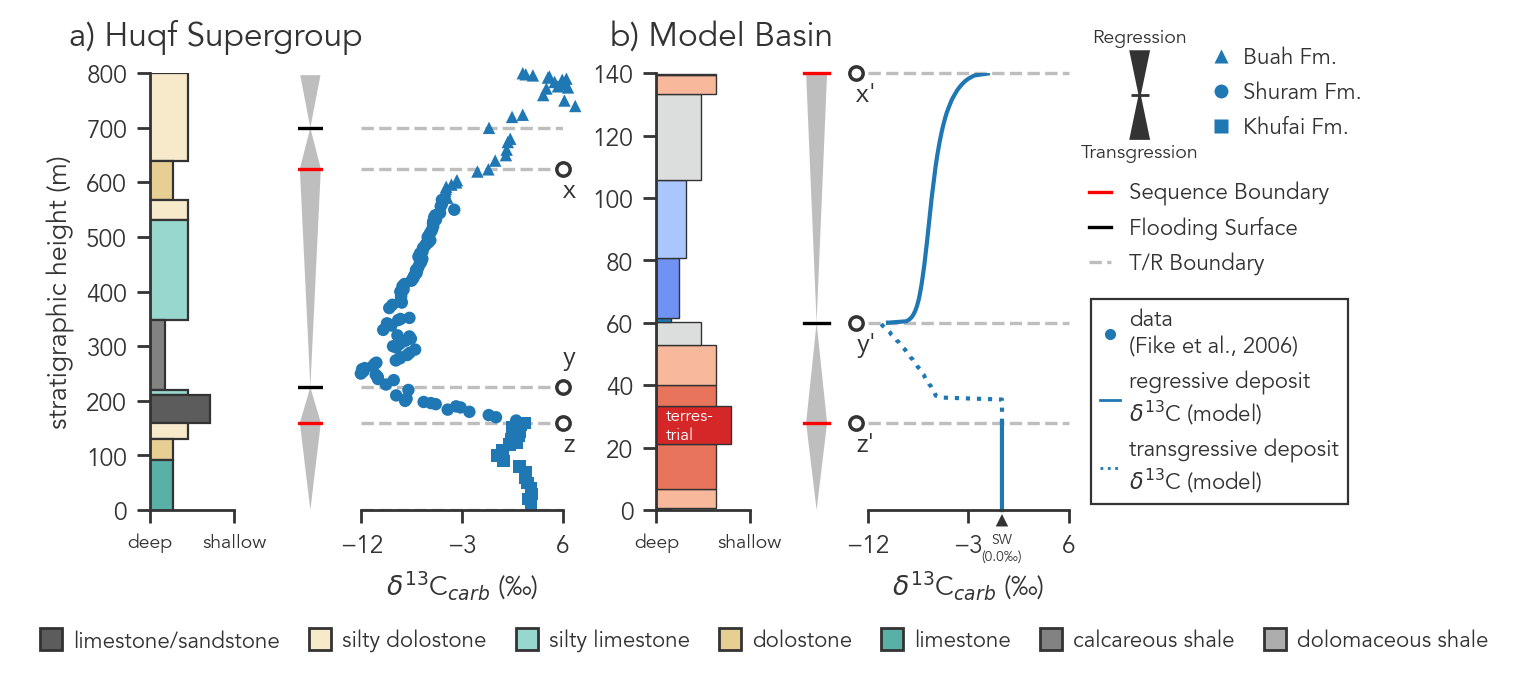

In [43]:
fig, ax = plt.subplots(1, 6, figsize=(6, 3), sharey=False, width_ratios=[0.65, 0.125, 1, 0.65, 0.125, 1], layout='constrained')

# d13c_lims
dmin = -12
dmax = 6

ax[0].set_ylim(3200, 4000)
ax[0].invert_yaxis()
ax[0].set_ylabel('stratigraphic height (m)')
ax[0].set_xlim(0, 1.75)

# strat column for huqf
plot_strat_column(ax[0], h_depth, h_lith, lith_styles, xspine=False,bar_edgecolor='.2')

# turn off spacer 1 ticks
ax[1].sharey(ax[0])
ax[1].tick_params(labelleft=False, left=False, length=0)

# d13c carb
# marker map for each unit
unit_marker_map = {
    'Buah': '^',       
    'Khufai': 's', 
    'Shuram': 'o'}     

# scatter each group with its marker
h_d13c = np.where(h_depth>=4000,np.nan,h_d13c) # mask out lower data to fit with clip_on=False and current lims
for unit in unit_marker_map:
    mask = (h_unit == unit)
    ax[2].scatter(h_d13c[mask], h_depth[mask],
                  marker=unit_marker_map[unit],
                  s=20, ec='none', fc='tab:blue', zorder=1, clip_on=False) # ec='none', fc='tab:blue'
#ax[2].scatter(x=h_d13c, y=h_depth, zorder=1000, ec='none', fc='tab:blue', marker='o', s=20, clip_on=True)
ax[2].set_xlabel('$\\delta^{13}$C$_{carb}$ (‰)')
ax[2].set_xlim(dmin, dmax)
ax[2].set_xticks(np.linspace(dmin, dmax, 3))
ax[2].sharey(ax[0])
ax[2].tick_params(labelleft=False, left=True)

# model strat
core_idx = 216 #216 #206 # chosen x-grid location for "drill core"

# strat column for model
targ_val, new_y_val, y_min, y_max, seq_y = o1b.strat_col_im(
    core_idx, targ=grid2, out=True, plot=True, ax=ax[3],
    x_axis=False, seq_bounds=True,edgecolor='.2')
ax[3].set_xticks([])
ax[3].spines[['top', 'bottom', 'right']].set_visible(False)
ax[3].set_xlim(0, 1.75)
ax[3].set_ylim(0,140)

# turn off spacer 2 ticks
ax[4].sharey(ax[3])
ax[4].tick_params(labelleft=False, left=False, length=0)

# model d13c
ax[5].sharey(ax[3])
ax[5].tick_params(labelleft=False, left=True)
ax[5].set_xlim(dmin,dmax)
ax[5].set_xticks(np.linspace(dmin, dmax, 3))
carb = np.flipud(grid2[:, core_idx])
o1b.tr_bars(
    loc=core_idx, ax=ax[5], xval=targ_val, yval=new_y_val, line=True,
    lines=['-', ':'], colors=['tab:blue','tab:blue'] * 2, alpha=1, legend=False, edgecolor='w', lw=1.5, # ['-', ':']
    xticks=True, zorder=1,clip=False)
ax[5].spines[['right', 'left', 'top']].set_visible(False)
ax[5].set_xlabel('$\\delta^{13}$C$_{carb}$ (‰)')

# model seq boundaries
seq_y = np.append(seq_y, 140)#-3) # add last timestep as that will be a sequence boundary; subtract to account for linewidth
for s in seq_y:
    color = 'r' if s!= seq_y[1] else 'k'
    #ax[3].scatter(x=1.25, y=s, color='r', s=20, marker='<')
    #ax[3].axhline(s,xmin=0,xmax=0.7, color='r',zorder=20000,ls='--')
    ax[4].axhline(s, color=color,zorder=20000,ls='-',clip_on=False)
    #if s!=seq_y[-1]:
    ax[5].axhline(s,color='tab:grey',zorder=0,ls='--',alpha=0.5,clip_on=False)

# format
ax[2].spines[['right', 'left', 'top']].set_visible(False)
ax[5].tick_params(axis='y', length=0)
ax[2].tick_params(axis='y', length=0)
ax[1].set_xticks([])
ax[4].set_xticks([])

# legend 1: d13c stuff
el_d13C = [
    Line2D([0], [0], mew=0.65, lw=0, markeredgewidth=4, marker='o', markeredgecolor='none', ls='-', label='data\n(Fike et al., 2006)', markerfacecolor='tab:blue', markersize=4),
    Line2D([0], [0], mew=0.65, lw=1, marker='none', color='tab:blue', ls='-', label='regressive deposit\n$\\delta^{13}$C (model)', markerfacecolor='none', markersize=0),
    Line2D([0], [0], mew=0.65, lw=1, marker='none', color='tab:blue', ls=':', label='transgressive deposit\n$\\delta^{13}$C (model)', markerfacecolor='none', markersize=0)]

fig.legend(handles=el_d13C, loc=4, bbox_to_anchor=(1.1, 0.16), ncols=1, frameon=True, framealpha=1, fontsize=8,
             handletextpad=0.4, markerfirst=True, handlelength=0.9, columnspacing=-2)#,title='$\\delta^{13}$C')

ax[1].axis('off')
ax[4].axis('off')

# label model vs data
ax[0].set_title('a) Huqf Supergroup',pad=10,fontsize=12)
ax[3].set_title('b) Model Basin',pad=10,fontsize=12)

# example: ax[4] is your spacer, shared with ax[2]
ax[4].set_xlim(-0.6, 0.6)
ax[1].set_xlim(-0.6, 0.6)

ax[4].spines[['top','right','bottom','left']].set_visible(False)

# define boundaries for triangle zones (e.g., tops of cycles)
boundaries = [0]+list(seq_y)  # heights of systems tracts
width = 1

for i in range(len(boundaries)-1):
    y0, y1 = boundaries[i], boundaries[i+1]
    y_mid = (y0 + y1) / 2

    if i % 2 == 0:
        # upward triangle (RST)
        ax[4].fill([0, -width/2, width/2], [y0, y1, y1], facecolor='tab:grey', alpha=0.5,edgecolor='none')
    else:
        # downward triangle (TST)
        ax[4].fill([0, -width/2, width/2], [y1, y0, y0], facecolor='tab:grey', alpha=0.5,edgecolor='none')

# Huqf, sequence boundaries are from Fike 2006, Bergmann 2025, and then inferred flooding surfaces are compiled from stratigraphy in Busch 2022 and bergmann 2025
seqs_h = [3840, 3775, 3375, 3300]
huqf_boundaries = [4000] + seqs_h + [3200]  # example input

for s in huqf_boundaries:
    #ax[0].scatter(x=1.25, y=s, color='r', s=20, marker='<')
    #ax[0].axhline(s, xmin=0,xmax=0.7, color='r',zorder=20000,ls='--')
    color = 'r' if s not in [3775,3300] else 'k'
    color = color if s not in [4000,3200] else 'w'
    ax[1].axhline(s,color=color,zorder=20000,ls='-')
    if s!=3200:
        ax[2].axhline(s,color='tab:grey',zorder=0,ls='--',alpha=0.5)

# define boundaries for Huqf (core) cycles
for i in range(len(huqf_boundaries) - 1):
    y_bot, y_top = huqf_boundaries[i], huqf_boundaries[i + 1]

    if i % 2 == 0:
        # upward triangle = regressive
        ax[1].fill([0, -width/2, width/2], [y_bot, y_top, y_top],
                   facecolor='tab:grey', alpha=0.5, edgecolor='none')
    else:
        # downward triangle = transgressive
        ax[1].fill([0, -width/2, width/2], [y_top, y_bot, y_bot],
                   facecolor='tab:grey', alpha=0.5, edgecolor='none')

# relabel huqf strat y-axis as net height
yticks = ax[0].get_yticks()
ax[0].set_yticks(yticks)
ax[0].set_yticklabels((4000 - yticks).astype(int))

# add inset for TR cycle diagram
axt = ax[5].inset_axes([1.35, 0.85, 0.45, 0.2])  # adjust width to reveal full shape

axt.set_xlim(-0.2, 0.2)
axt.set_ylim(0, 1)
axt.set(xticks=[], yticks=[])
axt.axis('off')

tri_w = 0.1  # triangle half-width
mid = 0.5    # midpoint of hourglass

# upper triangle (regression)
axt.fill([-tri_w, 0, tri_w], [1, mid, 1], color='.2', transform=axt.transAxes, clip_on=False)

# lower triangle (transgression)
axt.fill([-tri_w, 0, tri_w], [0, mid, 0], color='.2', transform=axt.transAxes, clip_on=False)

# central horizontal line
axt.hlines(mid, -tri_w, tri_w, color='.2', linewidth=1, transform=axt.transAxes,clip_on=False)

axt.text(0, 1.05, 'Regression', ha='center', va='bottom', fontsize=7, transform=axt.transAxes)
axt.text(0, -0.05, 'Transgression', ha='center', va='top', fontsize=7, transform=axt.transAxes)

# define custom line handles
line_seq = Line2D([0], [0], color='r', label='Sequence Boundary')
line_flood = Line2D([0], [0], color='k', label='Flooding Surface')
line_cyc = Line2D([0], [0], color='tab:grey', alpha=0.5, ls='--', label='T/R Boundary')

# create custom legend
fig.legend(handles=[line_seq, line_flood,line_cyc],loc='lower center',bbox_to_anchor=(0.975, 0.525),ncols=1,frameon=False,fontsize=8,handlelength=1)

# formatting
ax[0].set_xticks([0,1.125],['deep','shallow'],fontsize=7)
ax[0].plot([0,1.125], [0, 0], color='.2', lw=1, transform=ax[0].get_xaxis_transform(), clip_on=False)
ax[3].set_xticks([0,1.25],['deep','shallow'],fontsize=7)
ax[3].plot([0,1.25], [0, 0], color='.2', lw=1, transform=ax[3].get_xaxis_transform(), clip_on=False)

# label terrestrial
ax[3].text(0.125,22.5,'terres-\ntrial',color='w',fontsize=6)

# legend for Huqf strat
# sort by width descending
ordered_lith = sorted(lith_styles.items(), key=lambda x: -x[1]['width'])

# create legend handles with circle markers
handles = [Line2D([0], [0],
                  marker='s',
                  markersize=8,
                  markerfacecolor=style['color'],
                  markeredgecolor='.2',
                  lw=0,
                  label=label)
           for label, style in ordered_lith]

legend = fig.legend(handles=handles,
                   loc='center',
                   bbox_to_anchor = (0.6,-0.05),
                   ncol=len(handles),
                   frameon=False,
                   handletextpad=0,
                   columnspacing=0.8,
                   fontsize=8)

# formation legend
# create custom legend handles (bottom to top = Khufai → Shuram → Buah)
legend_handles = [
    Line2D([0], [0], marker=unit_marker_map['Khufai'], color='none',mec='none',
           markerfacecolor='tab:blue', markersize=5, label='Khufai Fm.'),
    Line2D([0], [0], marker=unit_marker_map['Shuram'], color='none',mec='none',
           markerfacecolor='tab:blue', markersize=5, label='Shuram Fm.'),
    Line2D([0], [0], marker=unit_marker_map['Buah'], color='none',mec='none',
           markerfacecolor='tab:blue', markersize=5, label='Buah Fm.'),
]

# add legend somewhere on the figure (adjust location as needed)
fig.legend(handles=legend_handles[::-1], loc='upper left',bbox_to_anchor=(.95,.975),
             frameon=False, fontsize=8, title_fontsize=8,handletextpad=0)

# tie point correlations between model and data
# huqf
htie = [huqf_boundaries[1],huqf_boundaries[-4],huqf_boundaries[-3]]
hlabs = ['z','y','x']
for i,l in zip(htie,hlabs):
    ax[2].scatter(dmax,i,clip_on=False,zorder=10000,ec='.2',fc='w',lw=1.25)
    v = 15 if l != 'y' else 28
    v = -80 if l =='y' else v
    ax[2].text(dmax,i+v,l,va='top')

# model
mtie = boundaries[1:] #[boundaries[1],boundaries[-1]]
mlabs = ["z'","y'","x'"]
for i,l in zip(mtie,mlabs):
    ax[5].scatter(dmin-1,i,clip_on=False,zorder=10000,ec='.2',fc='w',lw=1.25)
    v = 2.5 #if l != "y'" else 5.5
    ax[5].text(dmin-1,i-v,l,va='top')

# label DIC
dic = d_sw #o1b.dic[0]
ax[5].scatter(x=dic,y=-3.25,clip_on=False,zorder=1000000,fc='.2',ec='none',marker='^',s=20)
ax[5].text(dic,dmin-4.25,f'SW\n({d_sw}‰)',ha='center',fontsize=5)

# save
fig.savefig(tex_fig_dir + 'strat_compare.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)
#fig.savefig(diss_fig_dir + 'strat_compare.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

### Notes
- Busch's compilation heaviest value has median values of around 0‰, maybe a good piece of evidence for using that as baseline value

## Organic Density (Diesing, 2021)

In [44]:
# path to your tif
raster_path = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/shuram_TOC/data/Organic Carbon Modern/Diesing_2021/OCdensity_quantrf_mean.tif'
sup_path = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/shuram_TOC/data/Organic Carbon Modern/Diesing_2021/supp/SupplementaryDataTable2.xlsx'
sup = pd.read_excel(sup_path)

In [45]:
dst_crs = 'EPSG:4326'
with rasterio.open(raster_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    arr_ll = np.full((height, width), np.nan, dtype='float32')  # fill with nan
    reproject(
        source=rasterio.band(src, 1),
        destination=arr_ll,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear
    )

# mask garbage: anything <=0 or absurdly large
arr_ll = np.where((arr_ll <= 0) | (arr_ll > 1e5), np.nan, arr_ll)

xmin = transform.c
xmax = transform.c + transform.a * width
ymax = transform.f
ymin = transform.f + transform.e * height
extent_ll = [xmin, xmax, ymin, ymax]

# land + borders
land_shp   = shpreader.natural_earth(resolution='10m', category='physical', name='land')
admin0_shp = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')

land = gpd.read_file(land_shp).to_crs(dst_crs)
admin0 = gpd.read_file(admin0_shp).to_crs(dst_crs)

bbox = gpd.GeoDataFrame(geometry=[box(xmin, ymin, xmax, ymax)], crs=dst_crs)
land_clip = gpd.clip(land, bbox)
admin0_clip = gpd.clip(admin0, bbox)

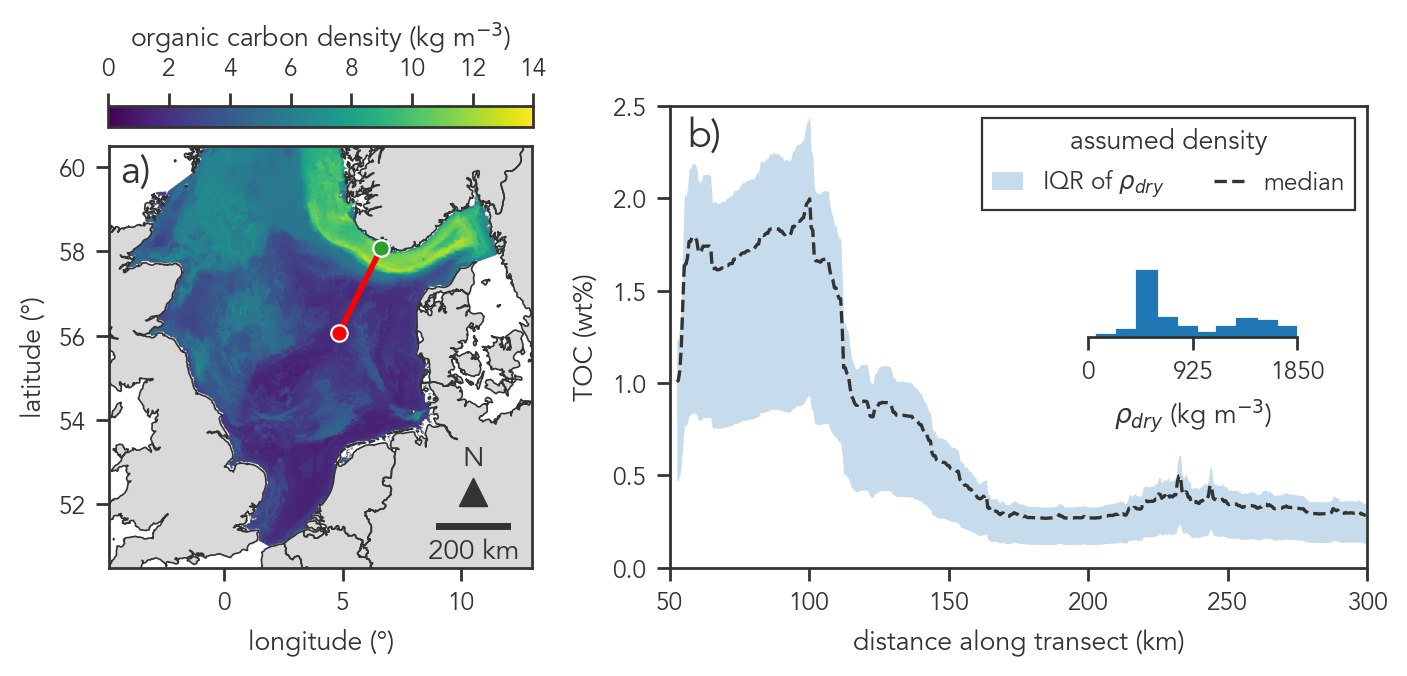

In [46]:
def add_north_and_scale(ax,
                        tri_loc=(9.5, 52.0),     # (lon, lat) for the triangle marker
                        n_loc=(9.5, 52.6),       # (lon, lat) for the "N" text
                        scale_loc=(9.0, 51.8),   # (lon, lat) for the center of the scale bar
                        length_km=200,           # scale bar length (km)
                        tri_size=120,            # triangle size (points^2)
                        n_fontsize=10,
                        bar_height_deg=0.03,     # half-height of bar ticks in degrees
                        bar_lw=2.5,
                        color='.2'):
    """
    Add an upright triangle (north arrow), an 'N' label, and a km scale bar
    to a lon/lat map with independent positions.

    Notes
    -----
    - Positions are long/lat in *data* coordinates.
    - Scale-bar length in degrees is computed from latitude at `scale_loc`.
    """

    # north arrow (upright triangle)
    ax.scatter(tri_loc[0], tri_loc[1],
               marker='^', s=tri_size, facecolor=color,
               edgecolor='.2', linewidth=0.6, zorder=5)
    ax.text(n_loc[0], n_loc[1], 'N', ha='center', va='bottom',
            fontsize=n_fontsize, color=color, zorder=5)

    # scale bar
    lon_c, lat_c = scale_loc
    # km per degree of longitude at this latitude
    km_per_deg_lon = 111.32 * np.cos(np.radians(lat_c))
    if km_per_deg_lon <= 0:
        km_per_deg_lon = 1e-6
    half_len_deg = (length_km / km_per_deg_lon) / 2.0

    x0, x1 = lon_c - half_len_deg, lon_c + half_len_deg
    y  = lat_c

    # main bar
    ax.plot([x0, x1], [y, y], color=color, lw=bar_lw, zorder=5)
    # label
    ax.text(lon_c, y - 10*bar_height_deg, f'{length_km:.0f} km',
            ha='center', va='top', fontsize=n_fontsize, color=color, zorder=5)

# great-circle distance (haversine) in km
def haversine_km(lon1, lat1, lon2, lat2):
    r = 6371.0088
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    return 2*r*np.arcsin(np.sqrt(a))

def plot_transect_map_and_profile(
    arr_ll, transform, extent_ll, land_clip, admin0_clip,
    start_lon, start_lat, end_lon, end_lat,
    n_samples=1000, max_km=None, cmap='viridis', reverse=False
):
    # sample lon/lat points along transect
    xs = np.linspace(start_lon, end_lon, n_samples)
    ys = np.linspace(start_lat, end_lat, n_samples)

    # distance along track (km)
    seg_km = haversine_km(xs[:-1], ys[:-1], xs[1:], ys[1:])
    dist_km = np.concatenate(([0.0], np.cumsum(seg_km)))

    # optionally limit by max_km
    if max_km is not None:
        keep = dist_km <= max_km
        if keep.sum() < 2:
            keep[:2] = True
        xs, ys, dist_km = xs[keep], ys[keep], dist_km[keep]

    # sample raster values
    rr, cc = rowcol(transform, xs, ys)
    rr = np.clip(rr, 0, arr_ll.shape[0]-1)
    cc = np.clip(cc, 0, arr_ll.shape[1]-1)
    vals = arr_ll[rr, cc]

    # mask invalids
    good = np.isfinite(vals)
    xs_g, ys_g, dkm_g, vals_g = xs[good], ys[good], dist_km[good], vals[good]

    # flip direction if requested (so start=continent, end=basin)
    if reverse:
        xs_g  = xs_g[::-1]
        ys_g  = ys_g[::-1]
        vals_g = vals_g[::-1]
        dkm_g  = (dkm_g[-1] - dkm_g)[::-1]

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(9,3),width_ratios=(1,1))

    # left: map
    im = ax[0].imshow(arr_ll, origin='upper', extent=extent_ll, cmap=cmap,vmin=0,vmax=14,rasterized=True)
    land_clip.plot(ax=ax[0], facecolor='0.85', edgecolor='none')
    admin0_clip.boundary.plot(ax=ax[0], color='.2', linewidth=0.6)

    ax[0].plot(xs_g, ys_g, color='r', ls='-', lw=2)
    ax[0].scatter(xs_g[0], ys_g[0], facecolor='tab:green',edgecolor='w', s=35, zorder=3)
    ax[0].scatter(xs_g[-1], ys_g[-1], facecolor='r',edgecolor='w', s=35, zorder=3)
    ax[0].set_xlim(extent_ll[0], extent_ll[1])
    ax[0].set_ylim(extent_ll[2], extent_ll[3])
    cb = plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04,orientation='horizontal',location='top')
    cb.ax.set_xticks(np.linspace(0,14,8))
    cb.set_label('organic carbon density (kg m$^{-3}$)')
    ax[0].set_xlabel('longitude (°)')
    ax[0].set_ylabel('latitude (°)')

    # right: profile
    #ax[1].plot(dkm_g, vals_g, lw=1.6)
    ax[1].set_xlabel('distance along transect (km)')
    ax[1].set_ylabel('organic carbon density (kg m$^{-3}$)')
    ax[1].set_xlim(50,300)
    #ax[1].spines[['top','right']].set_visible(False)
    #ax[1].set_ylim(0,14)
    ax[0].set_ylim(50.5,60.5)
    ax[0].set_xlim(-4.85,13)
    ax[0].text(0.025,0.9125,'a)',transform=ax[0].transAxes,fontsize=14)
    ax[1].text(0.025,0.9125,'b)',transform=ax[1].transAxes,fontsize=14)
    
    # add start (green) and end (red) markers
    #ax[1].scatter(dkm_g[0], vals_g[0], facecolor='tab:green', edgecolor='w', s=40, zorder=3,clip_on=False)
    #ax[1].scatter(dkm_g[-1], vals_g[-1], facecolor='r', edgecolor='w', s=40, zorder=100,clip_on=False)
    rho = sup['DBD']  # dry bulk density data

    rho_lo, rho_hi = np.min(sup['DBD']), np.max(sup['DBD'])
    rho_mean = np.mean(sup['DBD'])
    rho_med = np.median(sup['DBD'])
    rho_sd = np.std(rho)
    toc_lo = 100.0 * vals_g / rho_hi
    toc_hi = 100.0 * vals_g / rho_lo
    toc_mean = 100.0 * vals_g / rho_mean
    toc_med = 100.0 * vals_g / rho_med

    # calculate TOC% from dry bulk density range

    # IQR version
    q25, q75 = np.percentile(rho, [25, 75])  # interquartile range
    
    # convert oc density to TOC% range
    toc_q25 = 100.0 * vals_g / q75   # use high rho for lower TOC%
    toc_q75 = 100.0 * vals_g / q25   # use low rho for higher TOC%

    # mean sigma version
    # +/- 1σ band in TOC induced by ρ_dry +/- σ
    rho_hi_1s = rho_mean + rho_sd   # higher density, lower TOC
    rho_lo_1s = rho_mean - rho_sd   # lower density, higher TOC
    toc_lo_1s = 100.0 * vals_g / rho_hi_1s           # lower bound of TOC
    toc_hi_1s = 100.0 * vals_g / rho_lo_1s           # upper bound of TOC
    
    # (optional) ±2σ band
    rho_hi_2s = rho_mean + 2*rho_sd
    rho_lo_2s = rho_mean - 2*rho_sd
    toc_lo_2s = 100.0 * vals_g / rho_hi_2s
    toc_hi_2s = 100.0 * vals_g / rho_lo_2s
        
    # add TOC% band
    ax[1].fill_between(dkm_g, toc_q25, toc_q75, color='tab:blue', alpha=0.25,lw=0,label='IQR of $\\rho_{dry}$')
    #ax[1].fill_between(dkm_g, toc_lo_1s, toc_hi_1s, color='tab:blue', alpha=0.25, lw=0,label='1$\\sigma$')   
    ax[1].plot(dkm_g,toc_med,label='median',color='.2',ls='--')
    ax[1].set_ylabel('TOC (wt%)')
    
    # add legend entry for the shaded band
    ax[1].legend(title='assumed density',loc='upper right',ncols=2,handlelength=1.25)
    
    ymin, ymax = ax[1].get_ylim()
    ax[1].set_ylim(0,2.5)
    ax[1].set_ylabel('TOC (wt%)')

    axi = ax[1].inset_axes([0.6,0.5,0.3,0.15])
    # sns.kdeplot(rho,ax=axi,fill=True)
    axi.hist(rho,histtype='step',fill=True)
    axi.spines[['right','left','top']].set_visible(False)
    axi.set_yticks([])
    axi.set_ylabel(None)
    axi.set_xlabel('$\\rho_{dry}$ (kg m$^{-3}$)')
    axi.set_xlim(0,np.ceil(np.max(rho)))
    axi.set_xticks(np.linspace(0,np.ceil(np.max(rho))+1,3))
    plt.subplots_adjust(wspace=0)

    # add north arrow and scale
    add_north_and_scale(
        ax[0],
        tri_loc=(10.5, 52.3),          # triangle position
        n_loc=(10.5, 52.75),            # "N" text position
        scale_loc=(10.5, 51.5),        # scale bar position
        length_km=200,
        tri_size=100,
        n_fontsize=10
    ) 

    return fig, ax, {'lon': xs_g, 'lat': ys_g, 'dist_km': dkm_g, 'values': vals_g}

# pick endpoints (continent -> basin)
start_lon, start_lat = 7, 58.5    
end_lon, end_lat = 3, 54.0    

fig, ax, data = plot_transect_map_and_profile(
    arr_ll, transform, extent_ll, land_clip, admin0_clip,
    start_lon, start_lat, end_lon, end_lat,
    n_samples=1000,
    max_km=300,       # extend/crop the profile length as you like
    reverse=False    # start is continent side; keep False so left to right is onshore to offshore
)

# save
fig.savefig(tex_fig_dir + 'OC_Data.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)
#fig.savefig(diss_fig_dir + 'OC_Data.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)